# REAL ESTATE VALUE PREDICTOR

# Objective

The objective of this project is to develop a machine learning model capable of predicting the transactional price of residential real estate properties based on a diverse set of property-specific characteristics, relevant market and EGS (Environmental, Social, and Governance) trends. Given the lack of real-world data, our team generates and utilizes synthetic data designed to mimic realistic property and market conditions. The model aims to support banks in accurately estimating property values, thereby enhancing credit risk assessment and informed decision-making for mortgage issuance.

# Solution

The real estate price prediction project is structured around a carefully designed machine learning pipeline, leveraging both synthetic and real-world data to create a robust proof of concept (PoC). The approach includes:

- **Feature Identification & Justification**: Extensive research was conducted to identify key price-influencing factors, such as location, property size, number of rooms, building age, and proximity to infrastructure. Additionally, forward-looking market trend indicators like interest rate projections and local housing demand forecasts were incorporated.

- **Synthetic Data Generation**: A realistic synthetic dataset was developed to simulate a diverse range of residential properties and macroeconomic scenarios. Data generation was guided by domain knowledge and open-source insights, ensuring statistical plausibility and modeling relevance.

- **Preprocessing & Feature Engineering**: The dataset was cleaned and transformed through encoding (Label Encoding, One-Hot Encoding), scaling, and domain-specific feature construction (e.g., price per square meter).

- **Model Design**: Various regression-based models were explored, including Gradient Boosting Regressors and Regularized Linear Models. The final model selection balances predictive performance with explainability, essential for real-world banking applications.

- **Proof of Concept (PoC)**: A working model was trained and evaluated on dataset enhanced by synthetic data. Key performance metrics (e.g., MAE, RMSE) were analyzed to demonstrate the model’s potential. Initial results validate the approach and set a foundation for future improvements with real or enriched data. Our objective is to demonstrate that a predictive model can effectively predict real estate prices. The goal was to show that by integrating diverse datasets and employing advanced machine learning techniques, it is possible to capture complex patterns—even in the presence of outliers—and deliver robust predictions. We will look for variables such as environmental, eocial, eovernance, market trends, and macroeconomic factors.

Justification for feature selection can be found at section **Variables Explanation**

**GenAI usage** section can be found at the end of documentation

## Packages Import

In [188]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import KNNImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import LabelEncoder
import scipy.stats as stats
from scipy.stats import zscore
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
import re
import folium
from folium.plugins import HeatMap
import re  # for fixing column labels
import time
from tqdm import tqdm  # progress bars for loops
import psutil  # system resource monitoring
import matplotlib.pyplot as plt
import seaborn as sns  # statistical data visualizations
import plotly.io as pio  # interactive visualizations

# for data translation
from googletrans import Translator 
import asyncio
import nest_asyncio
nest_asyncio.apply()  # Allow nested event loops in Jupyter

In [185]:
# Scikit-learn utilities for data splitting, preprocessing, model evaluation, and pipelines
from sklearn.model_selection import train_test_split, cross_validate, KFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import VotingRegressor
from sklearn.inspection import permutation_importance


# Regression models
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

# Gradient boosting libraries (optimized for speed and performance)
import xgboost as xgb  # eXtreme Gradient Boosting
from lightgbm import LGBMRegressor  # fast, light gradient boosting
from catboost import CatBoostRegressor  # handles categorical variables well

# Simple MLP with SciKeras (combines Keras with scikit-learn's API)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from scikeras.wrappers import KerasRegressor  # scikit-learn wrapper for Keras models
import tensorflow as tf

# Hyperparameter optimization library for automating tuning
import optuna
from optuna import Trial
import optuna.visualization as oviz  # visualize optimization results

For better notebook readability, it's essential to disable unnecessary warning messages (such as log messages from models like **LightGBM**) since suppressing non-critical warnings (like FutureWarnings and non-error TensorFlow messages) results in a cleaner, more focused environment. Additionally, configuring Plotly to use the browser as its default renderer improves the usability of interactive plots, especially when working with complex visualizations.

In [87]:
# Warning moderation
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
tf.get_logger().setLevel("ERROR")
optuna.logging.set_verbosity(optuna.logging.ERROR)

import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"  

import nbformat
print("nbformat version:", nbformat.__version__)

import IPython
print("IPython version:", IPython.__version__)

pio.renderers.default = "browser"
print("Renderer:", pio.renderers.default)

nbformat version: 5.10.4
IPython version: 9.0.1
Renderer: browser


# 1. Data collecting

### Data Scrapping

In order to reliably collect the data, we used the webscraping methods, which are contained in a folder with the entire project as separate files `WebScraping_house.ipynb`, `WebScraping_studio.ipynb` and `WebScraping_apartments.ipynb`. This was our first step.

### Coordinates searching 

To add longitude and latitude to the dataset, we used 5 different APIs. The entire code file can be found in the project folder under the name `Coordianetes.ipynb`.

### Data Import

First, we import the three scraped `datasets—otodom_house_offers.csv`, `otodom_apartment_offers.csv`, and `otodom_studio_offers.csv` — each containing listings for a specific property type (house, apartment, or studio). After labeling each dataset with a **type** column, we concatenate them into a single DataFrame, `all_data`. This approach allows us to combine parallel web-scraping outputs from multiple sources and devices into one cohesive dataset, simplifying subsequent analysis and modeling steps.

In [88]:
house = pd.read_csv("otodom_house_offers.csv")
house["type"] = "house"

apartment = pd.read_csv("otodom_apartment_offers.csv")
apartment["type"] = "apartment"

studio = pd.read_csv("otodom_studio_offers.csv")
studio["type"] = "studio"

all_data = pd.concat([house, apartment, studio], ignore_index=True)

In addition to our primary real estate listings, we import several supplementary datasets to enrich our analysis and provide broader economic context. Together, these additional data sources complement our scraped listings, enabling a more comprehensive analysis of real estate trends in relation to economic and demographic factors.

In [89]:
inflation = pd.read_excel('inflation.xlsx')
average_salary = pd.read_csv('average_salary.csv', sep = ";")
gur = pd.read_csv('gradual_unemployment_rate.csv', sep = ";")
population = pd.read_csv('population.csv', sep = ";")
offers_with_coordinates = pd.read_csv('otodom_offers_coordinates.csv')

### Inflation Data

The inflation data requires restructuring before it can be incorporated into our analysis or modeling pipelines.

In [ ]:
inflation.columns = inflation.iloc[0,:] # Initial row is promoted to become the column headers
inflation_clean = inflation.copy()

Next, rows with missing values are dropped to maintain data consistency, and only the relevant columns (e.g., **Date** and **CPI**) are retained. Finally, the **CPI** column is converted to a numeric data type.

In [91]:
inflation_clean = inflation.dropna().iloc[:290,[0,6]]
inflation_clean.columns = ["Date", "CPI"] 
inflation_clean['CPI'] = pd.to_numeric(inflation_clean['CPI'], errors='coerce')
inflation_clean.head()

Date    CPI
2 2001-01-01  100.8
3 2001-02-01  100.1
4 2001-03-01  100.5
5 2001-04-01  100.8
6 2001-05-01  101.1

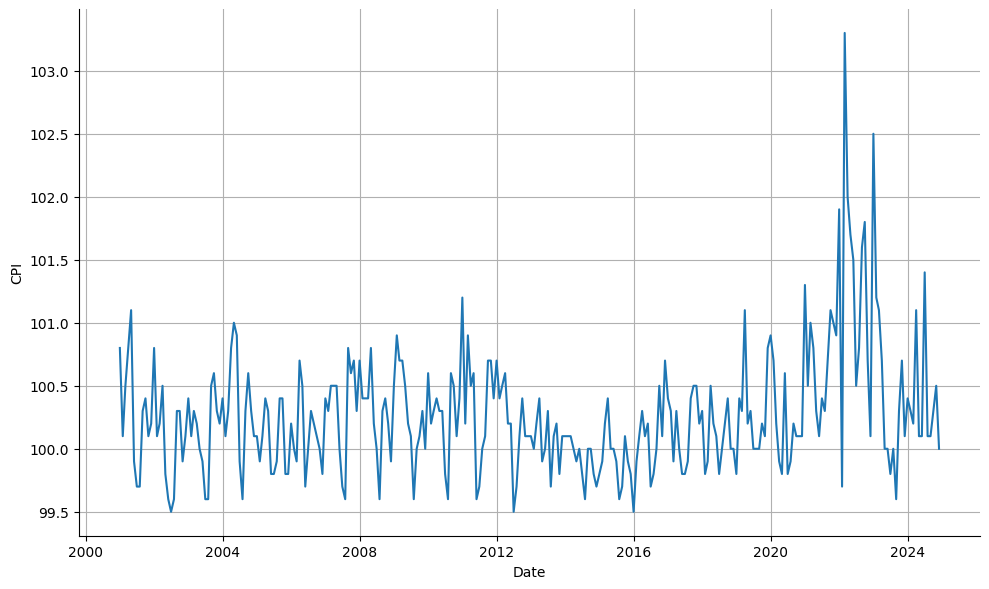

In [92]:
sns.relplot(x='Date', y='CPI', data=inflation_clean, 
            kind='line', height=6, aspect=10/6)

plt.grid()
plt.show()

The line plot represents the trend of the Consumer Price Index (CPI) over time, starting from the early 2000s up to 2024. The x-axis denotes the date, while the y-axis shows the CPI values. The graph exhibits fluctuations over the years, with relatively stable CPI values between 2000 and 2018. However, from around 2020 onward, there is a noticeable increase in volatility, with significant spikes in CPI, particularly in 2022 and 2023. These sharp increases may indicate periods of high inflation, economic instability, or external shocks affecting price levels. The inclusion of gridlines enhances readability, making it easier to analyze trends and patterns.

In [ ]:
# Make a copy of the cleaned inflation DataFrame to avoid altering the original
df = inflation_clean.copy()

# Convert the 'Date' column to datetime format so it can be used as a proper time index
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the DataFrame index and enforce a monthly start ('MS') frequency
df = df.set_index('Date').asfreq('MS')

# Define and fit an ARIMA model (p=1, d=1, q=1) to the CPI time series
model = ARIMA(df['CPI'], order=(1,1,1))
results = model.fit()

# Forecast the next 2 months and print the predicted CPI values
forecast = results.forecast(steps=2)
print("Forecast for the next two months:")
print(forecast)

Forecast for the next two months:
2025-01-01    100.278135
2025-02-01    100.343409
Freq: MS, Name: predicted_mean, dtype: float64


In [ ]:
forecast_df = forecast.to_frame(name="CPI").reset_index()
forecast_df.columns = ["Date", "CPI"]  # rename columns if needed

# Concatenate with the cleaned inflation data
inflation_final = pd.concat([inflation_clean, forecast_df], ignore_index=True)

# Convert 'Date' to the desired format
inflation_final["Date"] = pd.to_datetime(inflation_final["Date"], errors="coerce")
inflation_final["Date"] = inflation_final["Date"].dt.strftime("%Y-%m")

# Inspect the final rows
inflation_final.tail()

Date     CPI
285  2024-10  100.30
286  2024-11  100.50
287  2024-12  100.00
288  2025-01  100.78
289  2025-02  100.34

Because the inflation data is now in a clean, structured format, we can fit an ARIMA model to project inflation for the next two months, which are not yet included in the dataset. By converting the Date column to a datetime format and setting it as a time-indexed frequency series, the model can identify trends and seasonality in the inflation data. After fitting the ARIMA model, a short-term forecast (e.g., for the next two months) is generated, and the predicted values are appended to the original inflation.

### Otodom Data

We first determine the minimum number of non-missing values required to keep a row. For instance, if a row has less than 10% of its columns filled (i.e., at least 90% are NaN), it will be dropped. 

In [96]:
all_data.replace(["Brak danych", "brak informacji"], np.nan, inplace=True)

# Drop rows where at least 90% of columns are NaN
threshold = all_data.shape[1] * 0.1  # 10% non-NaN values required
all_data = all_data.dropna(thresh=threshold)

print(all_data.shape)

(2256, 14)


In [ ]:
# The code renames the columns in all_data to translate them from Polish to English, ensuring consistency and clarity in our dataset. 
all_data.rename(columns={
    'URL': 'URL',
    'Cena': 'Price',
    'Cena za m²': 'Price per m²',
    'Adres': 'Address',
    'Powierzchnia (m²)': 'Area (m²)',
    'Liczba pokoi': 'Number of rooms',
    'Ogrzewanie': 'Heating',
    'Rynek': 'Market',
    'Typ ogłoszeniodawcy': 'Advertiser type',
    'Rodzaj zabudowy': 'Building type',
    'Rok budowy': 'year_const',
    'Okna': 'Windows',
    'Materiał budynku': 'Building material'
}, inplace=True)

We drop the **URL** column because it doesn't contribute to the prediction task, and we remove **Price per m²** since it's derived from **Area** and **Price**, which we aim to predict directly.

In [ ]:
all_data = all_data.drop(columns = ['URL', 'Price per m²']) 

In [99]:
all_data.head()

Price                                            Address Area (m²)  \
0  1 999 000 zł  ul. Olchowa, Ujeścisko-Łostowice, Gdańsk, pomo...     148m²   
1    149 000 zł              Nowy Las, Głuchołazy, nyski, opolskie      70m²   
2    949 000 zł          Wołomin, Wołomin, wołomiński, mazowieckie  110.17m²   
3    729 000 zł                    ul. Lokalna, Płock, mazowieckie     114m²   
4    559 000 zł                          Knurów, gliwicki, śląskie     150m²   

  Number of rooms Heating     Market      Advertiser type Building type  \
0        4 pokoje  gazowe     wtórny             prywatny   szeregowiec   
1        3 pokoje     NaN     wtórny  biuro nieruchomości  wolnostojący   
2        4 pokoje  gazowe  pierwotny  biuro nieruchomości      bliźniak   
3         5 pokoi     NaN     wtórny  biuro nieruchomości      bliźniak   
4        4 pokoje     NaN     wtórny  biuro nieruchomości  wolnostojący   

  year_const     Windows Building material   type  
0       2021  plastikowe           silikat  house  
1        NaN         NaN               NaN  house  
2       2025  plastikowe             cegła  house  
3       1970         NaN            pustak  house  
4        NaN  plastikowe             cegła  house

In [100]:
all_data['Price'] = pd.to_numeric(
    all_data['Price'].str.replace(r'(zł|\s+)', '', regex=True), 
    errors='coerce'
)
all_data['Area (m²)'] = pd.to_numeric(
    all_data['Area (m²)'].str.replace(r'm²', '', regex=True), 
    errors='coerce'
)
all_data['Number of rooms'] = pd.to_numeric(
    all_data['Number of rooms'].str.replace(r'(pokoje?|pokoi)', '', regex=True), 
    errors='coerce'
)

In [101]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2256 entries, 0 to 2650
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Price              1842 non-null   float64
 1   Address            2253 non-null   object 
 2   Area (m²)          2255 non-null   float64
 3   Number of rooms    968 non-null    float64
 4   Heating            1313 non-null   object 
 5   Market             2255 non-null   object 
 6   Advertiser type    2255 non-null   object 
 7   Building type      950 non-null    object 
 8   year_const         1867 non-null   object 
 9   Windows            755 non-null    object 
 10  Building material  593 non-null    object 
 11  type               2256 non-null   object 
dtypes: float64(3), object(9)
memory usage: 229.1+ KB


In [ ]:
all_data['Heating'].value_counts().shape

Heating
miejskie                                     822
gazowe                                       239
inne                                          74
elektryczne                                   40
pompa ciepła                                  39
kotłownia                                     27
węglowe                                       14
kominkowe\ngazowe                             14
piece kaflowe                                  6
kominkowe                                      5
gazowe\npompa ciepła                           4
kominkowe gazowe                               3
biomasa                                        3
kominkowe\npompa ciepła                        2
gazowe kolektor słoneczny                      2
elektryczne\nkominkowe                         2
węglowe\ngazowe                                2
kominkowe\nolejowe                             1
biomasa\nelektryczne                           1
pompa ciepła kolektor słoneczny                1
miejskie\nko

In [103]:
# Calculate the threshold (1% of total count)
threshold = all_data['Heating'].count() * 0.01  

# Get value counts
heating_counts = all_data['Heating'].value_counts()

# Find categories that occur less than the threshold
rare_categories = heating_counts[heating_counts < threshold].index

# Replace them with "Inne"
all_data['Heating'] = all_data['Heating'].replace(rare_categories, "inne")

# Display the updated value counts
print(all_data['Heating'].value_counts())

Heating
miejskie             822
gazowe               239
inne                 118
elektryczne           40
pompa ciepła          39
kotłownia             27
węglowe               14
kominkowe\ngazowe     14
Name: count, dtype: int64


In [104]:
all_data['offer_date'] = "2025-02"

In [105]:
all_data.query('Price < 100000')

Price                                            Address  Area (m²)  \
61    11400.0   Pogorzel, Gołdap, gołdapski, warmińsko-mazurskie      57.00   
78    18750.0                 Olbrachtów, Żary, żarski, lubuskie     115.00   
1444  69000.0  pl. św. Józefa, Śródmieście, Kalisz, wielkopol...      26.00   
1955  99000.0  ul. Armii Krajowej, Chorzów Batory, Chorzów, ś...      39.67   
2312  82500.0            Śródmieście, Jelenia Góra, dolnośląskie      30.00   
2325  50000.0  Aleksandrów Łódzki, Aleksandrów Łódzki, zgiers...      17.27   
2446   6000.0  ok.ul. Moniuszki, Centrum, Śródmieście, Łódź, ...      50.00   

      Number of rooms      Heating  Market      Advertiser type Building type  \
61                2.0          NaN  wtórny             prywatny      bliźniak   
78                3.0          NaN  wtórny             prywatny           NaN   
1444              NaN         inne  wtórny  biuro nieruchomości           NaN   
1955              NaN  elektryczne  wtórny  biuro nieruchomości     kamienica   
2312              NaN          NaN  wtórny  biuro nieruchomości           NaN   
2325              NaN          NaN  wtórny             prywatny     kamienica   
2446              NaN     miejskie  wtórny  biuro nieruchomości     kamienica   

     year_const     Windows Building material       type offer_date  
61         1986         NaN               NaN      house    2025-02  
78          NaN         NaN               NaN      house    2025-02  
1444       1900         NaN               NaN  apartment    2025-02  
1955        NaN  plastikowe             cegła     studio    2025-02  
2312        NaN         NaN               NaN     studio    2025-02  
2325        NaN         NaN               NaN     studio    2025-02  
2446        NaN  plastikowe             cegła     studio    2025-02

In [ ]:
all_data = all_data.query('Price > 20000') # Removing "anomalies" from price

<function matplotlib.pyplot.show(close=None, block=None)>

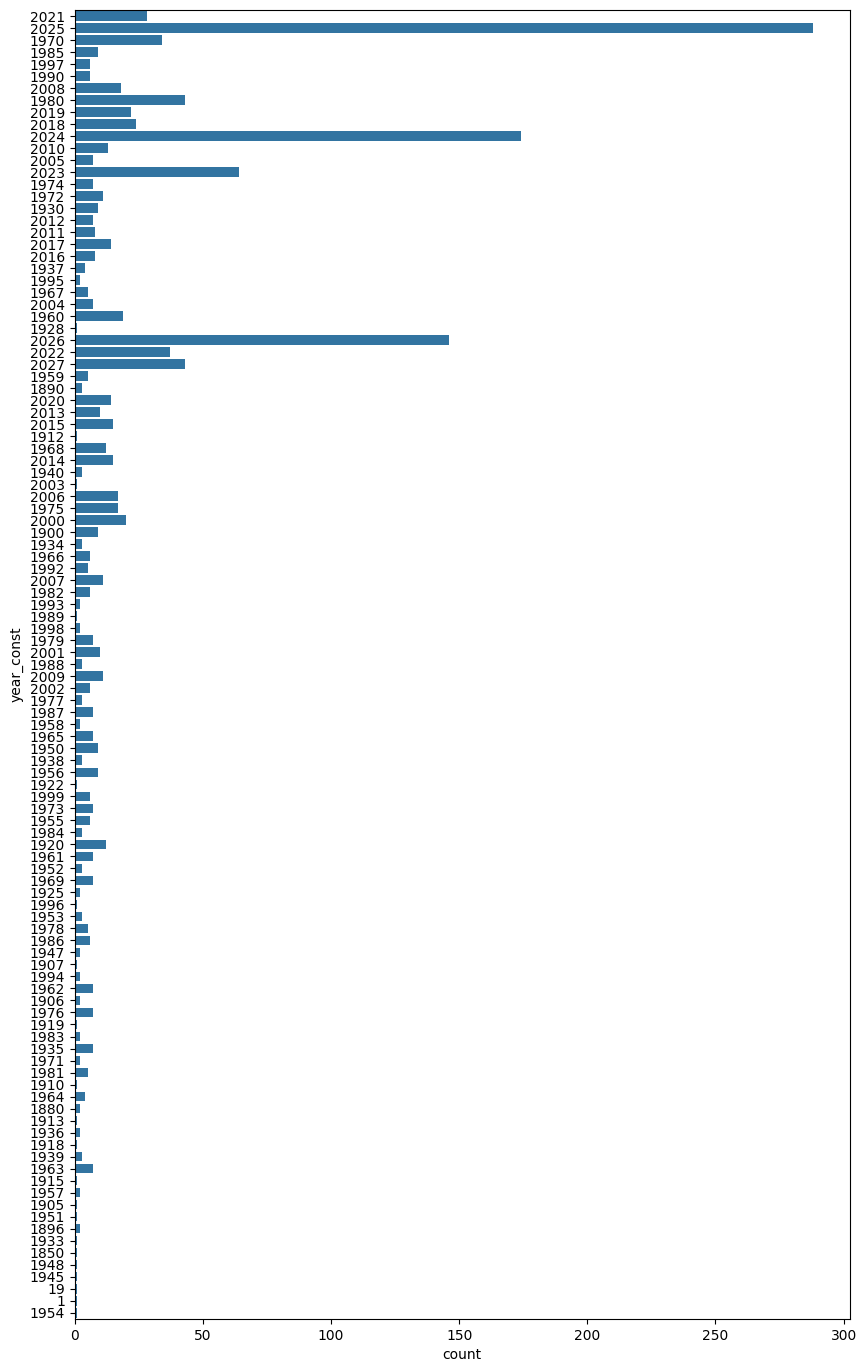

In [107]:
plt.figure(figsize=(10, 17))
sns.countplot(all_data['year_const'])
plt.show

In [ ]:
all_data = all_data.query('year_const > "1800"') # Removing "year" from price

### Additional Data

In this subsection we cleaned and prepared our supplementary datasets to ensure consistency and compatibility with our analytical scripts. 

* We processed our **coordinates** data to ensure it is clean and consistent with our primary datasets. First, we extracted only the necessary columns **Adres**, **Latitude**, and **Longitude** from the offers_with_coordinates DataFrame. Then, we renamed the 'Adres' column to 'Address' to maintain consistency across our data sources. Finally, we removed duplicate entries based on the 'Address' column to ensure that each property listing has a unique geospatial record. 

* **Population** dataset was processed by transposing, eliminating irrelevant metadata rows, resetting and renaming the index to establish proper date labels, and converting population numbers to numeric format before extending the dataset with new observations. Together, these steps ensure that all additional data sources are accurately formatted and complete, providing a solid foundation for subsequent analysis and modeling.

* For the unemployment rate (**gur**) data, we transposed the DataFrame to reorient the data, removed extraneous rows, extracted proper date labels by splitting the index, reset the index, and converted the unemployment figures to numeric values (after replacing commas with periods). We then appended new observations to fill any temporal gaps.

* The **average salary** data underwent an analogous process, where we transposed, cleaned unwanted rows, renamed columns, standardized the date format, and ensured numeric conversion for salary figures, later concatenating additional future observations.

In [ ]:
offers_with_coordinates.head() # Coordinates data example

URL          Cena  \
0  https://www.otodom.pl/pl/oferta/nowa-cena-3-po...    285 000 zł   
1  https://www.otodom.pl/pl/oferta/wyspianskiego-...   Brak danych   
2  https://www.otodom.pl/pl/oferta/wola-duchacka-...    690 000 zł   
3  https://www.otodom.pl/pl/oferta/mieszkanie-dew...    256 575 zł   
4  https://www.otodom.pl/pl/oferta/3-pokojowe-mie...  1 168 319 zł   

     Cena za m²                                              Adres  \
0   5 449 zł/m²                Grodków, Grodków, brzeski, opolskie   
1   Brak danych  ul. Stanisława Wyspiańskiego, Osiedle Wojska P...   
2  11 585 zł/m²  ul. Edwarda Heila, Wola Duchacka, Podgórze Duc...   
3   7 500 zł/m²              Witnica, Witnica, gorzowski, lubuskie   
4  17 111 zł/m²  ul. Pabianicka, Powstańców Śląskich, Krzyki, W...   

  Powierzchnia (m²) Liczba pokoi       Ogrzewanie      Rynek  \
0            52.3m²     3 pokoje  brak informacji     wtórny   
1           82.52m²     4 pokoje             inne  pierwotny   
2           59.56m²     3 pokoje         miejskie     wtórny   
3           34.21m²      1 pokój           gazowe  pierwotny   
4           68.28m²     3 pokoje  brak informacji  pierwotny   

   Typ ogłoszeniodawcy   Rok budowy Rodzaj zabudowy         Okna  \
0             prywatny  Brak danych             NaN  Brak danych   
1            deweloper         2025             NaN          NaN   
2  biuro nieruchomości         1988             NaN          NaN   
3  biuro nieruchomości         2025             NaN  Brak danych   
4            deweloper         2025     Brak danych  Brak danych   

  Materiał budynku   Latitude  Longitude  
0      Brak danych  50.698157  17.384980  
1      Brak danych  53.784550  20.482620  
2      Brak danych  50.016780  19.960360  
3              NaN  52.667374  14.896052  
4      Brak danych  51.084540  17.010500

In [ ]:
# --- Fixing Coordinates Data ---

coordinates = offers_with_coordinates[['Adres', 'Latitude', 'Longitude']]  # Necessary columns
coordinates.columns.values[0] = 'Address'  # Rename the first column to 'Address'
coordinates = coordinates.drop_duplicates(subset=['Address'])  # Remove duplicate entries based on Address

In [ ]:
population # Population data example

Country Name Country Code     Indicator Name Indicator Code      1960  \
0       Poland          POL  Population, total    SP.POP.TOTL  29637450   

       1961      1962      1963      1964      1965  ...      2014      2015  \
0  29964000  30308500  30712000  31139450  31444950  ...  38011735  37986412   

       2016      2017      2018      2019      2020      2021      2022  \
0  37970087  37974826  37974750  37965475  37899070  36981559  36821749   

       2023  
0  36687353  

[1 rows x 68 columns]

In [ ]:
# --- Fixing Population Data ---


population = population.T # Transpose the DataFrame so that rows become columns
population = population.iloc[4:, :] # Remove the first four rows that contain metadata or irrelevant information
population.columns = ['population'] # Rename the only column to 'population'
population = population.reset_index() # Reset the index so that the original index becomes a column
population = population.rename(columns={'index': 'Date'}) # Rename the 'index' column to 'Date'
population['Date'] = population['Date'].astype(str) # Convert the 'Date' column to string type for consistency
population['population'] = pd.to_numeric(population['population']) # Convert the 'population' column to numeric values

# Create new observations to extend the population data for future dates
new_obs = pd.DataFrame({
    'Date': ["2024", "2025"],
    'population': [38539201, 38268383]
})

# Concatenate the new observations with the cleaned population data, ignoring the original index
population = pd.concat([population, new_obs], ignore_index=True)

# Display the first few rows to verify the final DataFrame
population.head()

Date  population
0  1960    29637450
1  1961    29964000
2  1962    30308500
3  1963    30712000
4  1964    31139450

In [ ]:
gur # Unemployment rate data example

Kod   Nazwa ogółem;2004;[%] ogółem;2005;[%] ogółem;2006;[%]  \
0    0  POLSKA            19,0            17,6            14,8   

  ogółem;2007;[%] ogółem;2008;[%] ogółem;2009;[%] ogółem;2010;[%]  \
0            11,2             9,5            12,1            12,4   

  ogółem;2011;[%]  ... ogółem;2016;[%] ogółem;2017;[%] ogółem;2018;[%]  \
0            12,5  ...             8,2             6,6             5,8   

  ogółem;2019;[%] ogółem;2020;[%] ogółem;2021;[%] ogółem;2022;[%]  \
0             5,2             6,3             5,8             5,2   

  ogółem;2023;[%] ogółem;2024;[%] Unnamed: 23  
0             5,1             5,1         NaN  

[1 rows x 24 columns]

In [ ]:
# --- Fixing Unemployment Rate (gur) Data ---


gur = gur.T # Transpose the DataFrame so that rows become columns
gur = gur.iloc[2:, :] # Remove the first two rows, which contain unwanted metadata
gur.columns = ['gur'] # Rename the single column to 'gur'
gur.index = gur.index.str.split(';').str[1] # Extract the second part of the index after splitting by ';' to set as the proper date labels
gur = gur.reset_index() # Reset the index so that 'Date' becomes a column
gur = gur.rename(columns={'index': 'Date'}) # Rename the 'index' column to 'Date'
gur['Date'] = gur['Date'].astype(str) # Convert the 'Date' column to string type

# Replace commas with periods in the 'gur' column and convert it to numeric values; invalid parsing will be set as NaN
gur['gur'] = pd.to_numeric(gur['gur'].str.replace(r',', '.', regex=True), errors='coerce')

# Create new observations to extend the unemployment rate data
new_obs = pd.DataFrame({
    'Date': ["2003", "2025"],
    'gur': [20, 4]
})

# Concatenate the new observations with the cleaned unemployment data, ignoring the original index
gur = pd.concat([gur, new_obs], ignore_index=True)

gur.tail()

Date   gur
19  2023   5.1
20  2024   5.1
21   nan   NaN
22  2003  20.0
23  2025   4.0

In [115]:
average_salary

Kod   Nazwa ogółem;2002;[zł] ogółem;2003;[zł] ogółem;2004;[zł]  \
0    0  POLSKA          2239,56          2314,66          2409,69   

  ogółem;2005;[zł] ogółem;2006;[zł] ogółem;2007;[zł] ogółem;2008;[zł]  \
0          2506,93          2636,81          2866,04          3158,48   

  ogółem;2009;[zł]  ... ogółem;2015;[zł] ogółem;2016;[zł] ogółem;2017;[zł]  \
0          3315,38  ...          4150,86          4290,52          4527,89   

  ogółem;2018;[zł] ogółem;2019;[zł] ogółem;2020;[zł] ogółem;2021;[zł]  \
0          4834,76          5181,63          5523,32          6001,02   

  ogółem;2022;[zł] ogółem;2023;[zł] Unnamed: 24  
0          6705,62          7595,30         NaN  

[1 rows x 25 columns]

In [ ]:
# --- Fixing Average Salary Data ---

average_salary = average_salary.T  # Transpose the DataFrame so that rows become columns
average_salary = average_salary.iloc[2:, :] # Remove the first two rows, which contain unwanted metadata
average_salary.columns = ['average_salary'] # Rename the single column to 'average_salary'
average_salary.index = average_salary.index.str.split(';').str[1] # Extract the second part of the index after splitting by ';' to set as the proper date labels
average_salary = average_salary.reset_index() # Reset the index so that 'Date' becomes a column
average_salary = average_salary.rename(columns={'index': 'Date'}) # Rename the 'index' column to 'Date'
average_salary['Date'] = average_salary['Date'].astype(str) # Convert the 'Date' column to string type

# Replace commas with periods in the 'average_salary' column and convert it to numeric values; invalid parsing will be set as NaN
average_salary['average_salary'] = pd.to_numeric(
    average_salary['average_salary'].str.replace(r',', '.', regex=True), 
    errors='coerce'
)

# Create new observations to extend the average salary data
new_obs = pd.DataFrame({
    'Date': ["2024", "2025"],
    'average_salary': [8477, 8482.47]
})


average_salary = pd.concat([average_salary, new_obs], ignore_index=True) # Concatenate the new observations with the cleaned average salary data, ignoring the original index

average_salary.head()

Date  average_salary
0  2002         2239.56
1  2003         2314.66
2  2004         2409.69
3  2005         2506.93
4  2006         2636.81

### Data Imputation

In this subsection we imputed the missing values in the `all_data` DataFrame, which contains a considerable amount of missing data. Handling these gaps is critical for building reliable predictive models. We applied tailored imputation techniques depending on the type of data: for numerical features, missing values were imputed using KNN imputation, which helps to preserve the overall distribution by leveraging the similarity between observations; for categorical features, we used decision tree imputation to effectively predict missing categories based on the structure of the data. 

In [117]:
all_data.isna().sum()

Price                  0
Address                1
Area (m²)              0
Number of rooms      770
Heating              463
Market                 0
Advertiser type        0
Building type        758
year_const             0
Windows              924
Building material    993
type                   0
offer_date             0
dtype: int64

In [118]:
# Make a copy to ensure we don’t modify the original DataFrame
all_data_copy = all_data.copy()

# Separate numeric and categorical columns
numeric_cols = all_data_copy.select_dtypes(include=['number']).columns
categorical_cols = all_data_copy.select_dtypes(exclude=['number']).columns

In [ ]:
# Step 1: Impute numeric columns using KNN
imputer = KNNImputer(n_neighbors=3)
numeric_data_imputed = pd.DataFrame(imputer.fit_transform(all_data_copy[numeric_cols]), 
                                    columns=numeric_cols, 
                                    index=all_data_copy.index)  # Ensure index remains the same

# Step 2: Encode categorical columns and Impute using Decision Tree
categorical_data = all_data_copy[categorical_cols].copy()

# Encode all categorical variables
label_encoders = {}

for col in categorical_cols:
    encoder = LabelEncoder()
    categorical_data[col] = categorical_data[col].astype(str)  # Convert NaN to string
    categorical_data[col] = encoder.fit_transform(categorical_data[col])  # Encode
    label_encoders[col] = encoder  # Save encoder for later decoding

# Ensure we maintain the same index structure
categorical_data = categorical_data.reindex(all_data_copy.index)

# Identify missing values in categorical columns and use Decision Tree to predict them
for col in categorical_cols:
    if all_data_copy[col].isna().sum() > 0:  # Only impute if there are missing values
        # Split known and missing data
        known_data = categorical_data[all_data_copy[col].notna()]
        missing_data = categorical_data[all_data_copy[col].isna()]

        # Train Decision Tree on known data
        model = DecisionTreeClassifier(max_depth=5, random_state=42)
        model.fit(known_data.drop(col, axis=1), known_data[col])

        # Predict missing values
        categorical_data.loc[missing_data.index, col] = model.predict(missing_data.drop(col, axis=1))

# Convert encoded categorical values back to original labels
for col in categorical_cols:
    categorical_data[col] = label_encoders[col].inverse_transform(categorical_data[col].astype(int))

# Ensure categorical data has the same index as original
categorical_data = categorical_data.reindex(all_data_copy.index)

# Step 3: Merge both imputed datasets
all_data_imputed = pd.concat([numeric_data_imputed, categorical_data], axis=1)

all_data_imputed['Number of rooms'] = all_data_imputed['Number of rooms'].astype(int)

# Ensure final shape matches expected dimensions
print(f"Final shape:  {all_data_imputed.shape}")

print(f"Na's: {all_data_imputed.isna().sum()}")

all_data_imputed.head()


Final shape:  (1460, 13)
Na's: Price                0
Area (m²)            0
Number of rooms      0
Address              0
Heating              0
Market               0
Advertiser type      0
Building type        0
year_const           0
Windows              0
Building material    0
type                 0
offer_date           0
dtype: int64


Price  Area (m²)  Number of rooms  \
0  1999000.0     148.00                4   
2   949000.0     110.17                4   
3   729000.0     114.00                5   
5   410000.0      82.00                5   
6   439000.0     161.00                4   

                                             Address  Heating     Market  \
0  ul. Olchowa, Ujeścisko-Łostowice, Gdańsk, pomo...   gazowe     wtórny   
2          Wołomin, Wołomin, wołomiński, mazowieckie   gazowe  pierwotny   
3                    ul. Lokalna, Płock, mazowieckie   gazowe     wtórny   
5             ul. Biała, Glinice, Radom, mazowieckie   gazowe     wtórny   
6                Barcino, Kępice, słupski, pomorskie  węglowe     wtórny   

       Advertiser type Building type year_const     Windows Building material  \
0             prywatny   szeregowiec       2021  plastikowe           silikat   
2  biuro nieruchomości      bliźniak       2025  plastikowe             cegła   
3  biuro nieruchomości      bliźniak       1970  plastikowe            pustak   
5  biuro nieruchomości  wolnostojący       1985  plastikowe            pustak   
6  biuro nieruchomości  wolnostojący       1997  plastikowe            pustak   

    type offer_date  
0  house    2025-02  
2  house    2025-02  
3  house    2025-02  
5  house    2025-02  
6  house    2025-02

### Generating synthetic data

In [120]:
# Compute Z-scores for the 'Price' column
z_scores = np.abs(zscore(all_data_imputed['Price']))

# Remove rows where the Z-score is above 3 (3σ rule)
all_data_imputed = all_data_imputed[z_scores < 3]

In [121]:
z_scores = np.abs(zscore(all_data_imputed['Area (m²)']))
all_data_imputed = all_data_imputed[z_scores < 3]

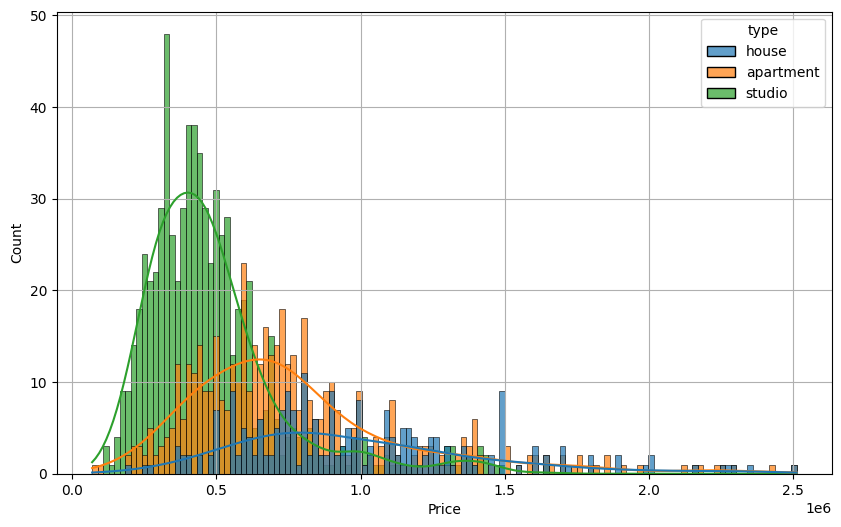

In [122]:
plt.figure(figsize=(10, 6))
sns.histplot(data=all_data_imputed, x='Price', bins=128, kde=True, alpha=0.7, hue = 'type')
plt.grid()
plt.show()


The histogram visualizes the distribution of property prices, categorized by type: house, apartment, and studio. The x-axis represents the price, while the y-axis indicates the count of properties in each price range. Studios (green) tend to have the lowest prices, with a sharp peak around 300,000-500,000. Apartments (orange) follow a similar distribution but are slightly more spread out with higher prices. Houses (blue) exhibit the broadest price range, extending beyond 2 million, though they are less frequent at extreme price points. The kernel density estimate (KDE) curves help illustrate the overall distribution trends.

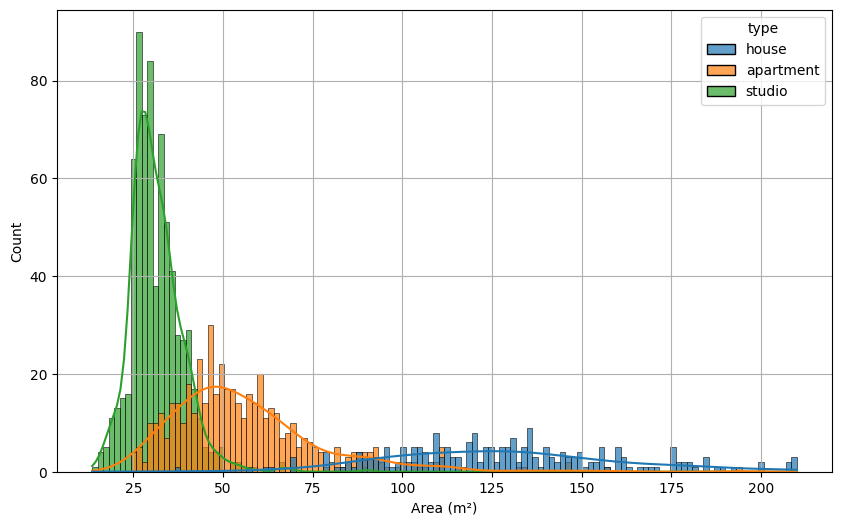

In [123]:
plt.figure(figsize=(10, 6))
sns.histplot(data=all_data_imputed, x='Area (m²)', bins=128, kde=True, alpha=0.7, hue = 'type')
plt.grid()
plt.show()

The histogram shows the distribution of property sizes in square meters. Studios have the smallest areas, clustering around 25-50 m². Apartments display a wider range, peaking around 50-75 m². Houses, on the other hand, have the largest variation, with sizes often exceeding 100 m². The KDE curves highlight the differences in area distributions across property types, with a clear distinction between compact studios and more spacious houses.

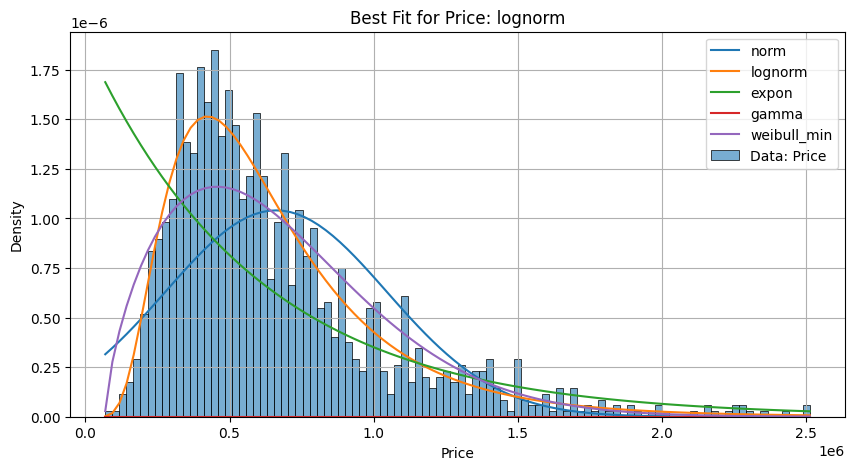

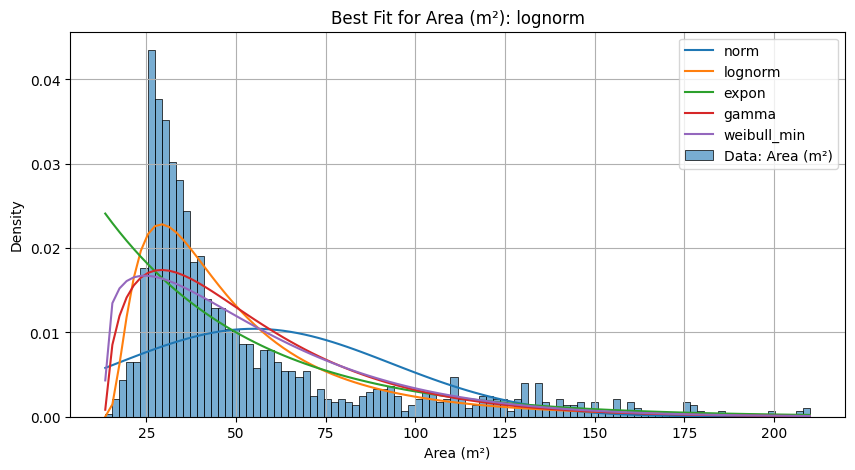

Best-fitting distribution for Price: lognorm
Best-fitting distribution for Area (m²): lognorm


In [124]:
# Select only numeric columns
numeric_cols = all_data_imputed[['Price', 'Area (m²)']]

# List of common distributions to test
dist_names = ['norm', 'lognorm', 'expon', 'gamma', 'weibull_min']

best_fits = {}

# Loop through each numeric column
for col in numeric_cols:
    data = all_data_imputed[col].dropna()

    plt.figure(figsize=(10, 5))
    sns.histplot(data, bins=100, kde=False, stat="density", label=f"Data: {col}", alpha=0.6)

    best_pval = 0
    best_dist = None

    for dist in dist_names:
        # Fit distribution
        params = getattr(stats, dist).fit(data)
        
        # Generate PDF from fitted distribution
        x = np.linspace(data.min(), data.max(), 100)
        pdf_fitted = getattr(stats, dist).pdf(x, *params)

        # Kolmogorov-Smirnov test
        ks_stat, ks_pval = stats.kstest(data, dist, args=params)

        # Track the best distribution
        if ks_pval > best_pval:
            best_pval = ks_pval
            best_dist = dist

        # Plot distribution
        plt.plot(x, pdf_fitted, label=f"{dist}")

    best_fits[col] = best_dist
    plt.legend()
    plt.grid()
    plt.title(f"Best Fit for {col}: {best_dist}")
    plt.show()

# Print the best distribution for each feature
for col, dist in best_fits.items():
    print(f"Best-fitting distribution for {col}: {dist}")

* **The first histogram** visualizes the distribution of property prices, with a fitted probability density function (PDF) overlaid for several theoretical distributions, including normal, lognormal, exponential, gamma, and Weibull. The histogram shows that most properties have lower prices, with the frequency gradually decreasing as prices increase. The lognormal distribution provides the best fit, as indicated by the smooth curve closely following the shape of the histogram. This suggests that property prices are positively skewed, meaning there are many lower-priced properties and fewer expensive ones, creating a long right tail.


* **The second histogram** represents the distribution of property areas in square meters, following the same approach as the price analysis. The majority of properties have relatively small areas, with a gradual decline in frequency as the size increases. Similar to the price distribution, the lognormal distribution fits the data best, as confirmed by the overlaid PDF. This indicates that most properties are compact, with a few significantly larger ones extending the distribution’s right tail. The results highlight the natural tendency of real estate data to be skewed, with a concentration of smaller, more affordable properties and fewer large, high-value ones.

**Synthetic Data Generation Description**

The synthetic data generation process consists of multiple steps, ensuring that the simulated real estate listings are realistic and consistent with historical trends. 

The process begins with **extracting base data** from real estate listings available in February 2025. These listings serve as a reference for setting statistical distributions for price and area across different property types. For each **type** (studio, apartment, and house) the logarithm of price and area is computed, allowing for the estimation of mean and standard deviation parameters that define log-normal distributions.

Next, the model **incorporates macroeconomic factors**. The Consumer Price Index (CPI) is used to adjust prices for inflation, ensuring that generated prices reflect historical cost changes. Additionally, two key economic indicators **population and unemployment rate** are considered. The population influences demand, meaning higher population leads to higher prices (information available in multiple internet sorces such as wikipedia), modeled as a power function with coefficient $\alpha$. Conversely, unemployment affects affordability, where higher unemployment decreases prices, modeled using $\beta$. The price is therefore adjusted as follows:

$$
C_{\text{adjusted}} = C_{\text{base}} \times \left( \frac{P}{P_0} \right)^{\alpha} \times \left( \frac{U_0}{U} \right)^{\beta}
$$

where:

- $ C_{\text{adjusted}} $ - the final adjusted price, incorporating inflation, population, and unemployment effects.
- $ C_{\text{base}} $ - the base price, already adjusted for inflation:
  $$
  C_{\text{base}} = C_{\text{2025-02}} \times \frac{CPI_{\text{year-month}}}{CPI_{\text{2025-02}}}
  $$
  where:
  - $ C_{\text{2025-02}} $ - the observed price for February 2025.
  - $ CPI_{\text{year-month}} $ - Consumer Price Index for the specific year and month.
  - $ CPI_{\text{2025-02}} $ - Consumer Price Index for February 2025.
- $ P, P_0 $ - population in the given year and in the base year (e.g., 2025).
- $ U, U_0 $ - unemployment rate in the given year and in the base year (e.g., 2025).
- $ \alpha, \beta $ - coefficients regulating the influence of population and unemployment.

For **each month from January 2003 to December 2024**, the algorithm generates **90 synthetic listings per month**, ensuring a balanced number of property types (30 for each category). First, a random price and area are drawn from the respective log-normal distributions, adjusted according to inflation, population, and unemployment. The property’s **market type** (primary or secondary) and **advertiser type** (private, developer, or real estate agency) are assigned based on price proximity to their real-world average values.

To maintain realism, categorical attributes such as **building type, window type, building material, and heating type** are randomly sampled from the original dataset while preserving statistical distributions. The **address** is also drawn randomly from historical listings to retain locality consistency.

Lastly, the **year of construction** is sampled from existing data but constrained so that it cannot exceed the listing year. The **number of rooms** is assigned based on the property type: studios have 1-2 rooms, apartments 2-4, and houses 4-10.

By following these steps, the synthetic dataset maintains historical patterns while reflecting economic conditions and property characteristics across time.

In [125]:
# -----------------------------------------------------
# 1. Base data: offers from 2025-02
# -----------------------------------------------------
df_base = all_data_imputed.copy()
df_base = df_base[df_base['offer_date'] == "2025-02"]
df_base = df_base[(df_base['Price'] > 0) & (df_base['Area (m²)'] > 0)]

# Ensure that the "year_const" column is numeric
df_base['year_const'] = df_base['year_const'].astype(int)

# -----------------------------------------------------
# 2. Compute log-normal parameters for each property type
# -----------------------------------------------------
group_params_price = {}
group_params_area = {}

types_list = ['studio', 'apartment', 'house']

for t in types_list:
    subset_t = df_base[df_base['type'] == t]
    
    # Compute log-normal parameters for price
    log_prices_t = np.log(subset_t['Price'])
    mu_price_t = log_prices_t.mean()
    sigma_price_t = log_prices_t.std()
    group_params_price[t] = (mu_price_t, sigma_price_t)
    
    # Compute log-normal parameters for area
    log_areas_t = np.log(subset_t['Area (m²)'])
    mu_area_t = log_areas_t.mean()
    sigma_area_t = log_areas_t.std()
    group_params_area[t] = (mu_area_t, sigma_area_t)

# -----------------------------------------------------
# 3. Inflation, Population, and Unemployment Data
# -----------------------------------------------------
baseline_date = "2025-02"
baseline_cpi = inflation_final.loc[inflation_final['Date'] == baseline_date, 'CPI'].iloc[0]

# Load population and unemployment data
population_baseline = population.loc[population['Date'] == "2025", 'population'].iloc[0]
unemployment_baseline = gur.loc[gur['Date'] == "2025", 'gur'].iloc[0]

# Współczynniki wpływu populacji i bezrobocia
alpha = 1
beta = 1

# -----------------------------------------------------
# 4. Compute average prices by 'Market' and 'Advertiser type'
# -----------------------------------------------------
market_avg_price = df_base.groupby('Market')['Price'].mean().to_dict()
advertiser_avg_price = df_base.groupby('Advertiser type')['Price'].mean().to_dict()

def assign_category_by_price(price, avg_price_dict):
    """Assigns the closest category based on price proximity to average prices."""
    return min(avg_price_dict, key=lambda k: abs(price - avg_price_dict[k]))

# -----------------------------------------------------
# 5. Prepare the date range (2003-01 to 2024-12)
# -----------------------------------------------------
date_range = pd.date_range(start="2003-01-01", end="2024-12-01", freq="MS")
date_range_str = date_range.strftime("%Y-%m")

# Fixed number of offers per month: 30 for each type (studio, apartment, house)
n_offers_per_type = 30

# -----------------------------------------------------
# 6. Generate synthetic data
# -----------------------------------------------------
new_rows = []

for current_date in date_range_str:
    year = int(current_date.split("-")[0])  # Extract year

    # Get the CPI for the current month
    row_cpi = inflation_final.loc[inflation_final['Date'] == current_date, 'CPI']
    if row_cpi.empty:
        continue
    cpi_current = row_cpi.iloc[0]

    # Get population and unemployment for the current year
    population_current = population.loc[population['Date'] == f'{year}', 'population'].iloc[0]
    unemployment_current = gur.loc[gur['Date'] == f'{year}', 'gur'].iloc[0]

    # Apply inflation correction
    inflation_factor = cpi_current / baseline_cpi

    # Apply population and unemployment corrections
    population_factor = (population_current / population_baseline) ** alpha
    unemployment_factor = (unemployment_baseline / unemployment_current) ** beta

    price_correction_factor = inflation_factor * population_factor * unemployment_factor

    for chosen_type in types_list:
        mu_price_type, sigma_price_type = group_params_price[chosen_type]
        mu_area_type, sigma_area_type = group_params_area[chosen_type]
        
        for _ in range(n_offers_per_type):
            # Generate price and area from log-normal distribution
            generated_price = np.random.lognormal(mean=mu_price_type, sigma=sigma_price_type) * price_correction_factor
            generated_area = np.random.lognormal(mean=mu_area_type, sigma=sigma_area_type)
            
            # Assign 'Market' and 'Advertiser type' based on price proximity
            chosen_market = assign_category_by_price(generated_price, market_avg_price)
            chosen_adv = assign_category_by_price(generated_price, advertiser_avg_price)
            
            # Sample additional attributes from the original dataset for the given property type
            sample_record = df_base[df_base['type'] == chosen_type].sample(n=1).iloc[0]
            building_type = sample_record['Building type']
            windows = sample_record['Windows']
            building_material = sample_record['Building material']
            address = sample_record['Address']
            heating = sample_record['Heating']
            
            # Sample "year_const" and ensure it does not exceed the offer year
            sampled_year_const = int(
                df_base[df_base['type'] == chosen_type]['year_const'].sample(n=1).iloc[0]
            )
            if sampled_year_const > year:
                sampled_year_const = year
            
            # Assign number of rooms based on property type
            number_rooms = np.random.randint(1, 3) if chosen_type == 'studio' else \
                           np.random.randint(2, 5) if chosen_type == 'apartment' else \
                           np.random.randint(4, 11)

            new_record = {
                "offer_date": current_date,
                "type": chosen_type,
                "Advertiser type": chosen_adv,
                "Market": chosen_market,
                "Building type": building_type,
                "Windows": windows,
                "Building material": building_material,
                "Heating": heating,
                "Address": address,
                "year_const": sampled_year_const,
                "Number of rooms": number_rooms,
                "Price": generated_price,
                "Area (m²)": generated_area
            }
            new_rows.append(new_record)

df_generated = pd.DataFrame(new_rows).reset_index(drop=True)
print(f"Number of generated records: {len(df_generated)}")
print(df_generated.head())

# df_generated.to_csv("generated_data.csv", index=False)


Number of generated records: 23760
  offer_date    type Advertiser type  Market    Building type     Windows  \
0    2003-01  studio        prywatny  wtórny      szeregowiec  plastikowe   
1    2003-01  studio        prywatny  wtórny  apartamentowiec  plastikowe   
2    2003-01  studio        prywatny  wtórny             blok  plastikowe   
3    2003-01  studio        prywatny  wtórny             blok  plastikowe   
4    2003-01  studio        prywatny  wtórny             blok  plastikowe   

  Building material    Heating  \
0             cegła   miejskie   
1             cegła  kotłownia   
2              inny   miejskie   
3              inny   miejskie   
4      wielka płyta   miejskie   

                                             Address  year_const  \
0  ul. Naramowicka, Naramowice, Stare Miasto, Poz...        2003   
1                  Karpacz, karkonoski, dolnośląskie        2003   
2  Antoniego Tabaki, Swarzędz, Swarzędz, poznańsk...        2003   
3  ul. Chełmżyńska, Kawęc

### Data Finalize 

In [178]:
data_final = pd.concat([all_data_imputed, df_generated], ignore_index=True)
data_final = data_final.merge(inflation_final, left_on = 'offer_date', right_on = 'Date', how = 'left')

data_final['Date'] = pd.to_datetime(data_final['Date'], format='%Y-%m').dt.year
data_final['Date'] = data_final['Date'].astype(str)

data_final = data_final.merge(population, on='Date', how='left')
data_final = data_final.merge(gur, on='Date', how='left')
data_final = data_final.merge(average_salary, on='Date', how='left')
data_final = data_final.merge(coordinates, on='Address', how='left')


data_final['voivodeship'] = data_final['Address'].str.split(',').str[-1].str.strip()

In [179]:
data_final_imputed = pd.DataFrame(imputer.fit_transform(data_final[['Latitude', 'Longitude']]), 
                                    columns=['Latitude', 'Longitude'], 
                                    index=data_final.index) 

data_final['Latitude'] = data_final_imputed['Latitude']
data_final['Longitude'] = data_final_imputed['Longitude']

data_final = data_final.drop(columns = 'Address')

In [ ]:
#data_final.to_csv('data_final.csv')

### Data Translation

In [223]:
data_final = pd.read_csv('data_final.csv', index_col=0)

In [224]:
# Assume data_final is already defined (e.g., loaded from a CSV)
data = data_final.copy()

# Define custom mapping dictionaries for the columns you want to translate
custom_mappings = {
    'Market': {
         'pierwotny': 'primary',
         'wtórny': 'secondary'
    },
    'Heating': {
         'gazowe': 'gas',
         'węglowe': 'coal',
         'pompa ciepła': 'heat pump',
         'inne': 'other',
         'elektryczne': 'electric',
         'kominkowe\ngazowe': 'fireplace/gas',
         'miejskie': 'district heating',
         'kotłownia': 'boiler room'
    },
    'Advertiser type': {
         'prywatny': 'private',
         'biuro nieruchomości': 'real estate agency',
         'deweloper': 'developer'
    },
    'Building type': {
         'szeregowiec': 'terraced house',
         'bliźniak': 'semi-detached house',
         'wolnostojący': 'detached house',
         'kamienica': 'tenement house',
         'blok': 'block of flats',
         'apartamentowiec': 'apartment building',
         'dom wolnostojący': 'detached house',
         'loft': 'loft',
         'plomba': 'plomb'
    },
    'Windows': {
         'plastikowe': 'plastic',
         'drewniane': 'wooden',
         'aluminiowe': 'aluminum',
         'brak': 'none'
    },
    'Building material': {
         'silikat': 'silicate',
         'cegła': 'brick',
         'pustak': 'concrete block',
         'inny': 'other',
         'drewno': 'wood',
         'beton komórkowy': 'aerated concrete',
         'beton': 'concrete',
         'wielka płyta': 'large panel',
         'żelbet': 'reinforced concrete',
         'keramzyt': 'expanded clay'
    }
}

# Identify categorical columns (object dtype) excluding "voivodeship" and "offer_date"
columns_to_translate = [col for col in data.select_dtypes(include=['object']).columns 
                        if col not in ['voivodeship', 'offer_date']]

print("Categorical columns to be processed (excluding 'voivodeship' and 'offer_date'):")
print(columns_to_translate)

# For each column with a custom mapping, apply the mapping
for col in columns_to_translate:
    if col in custom_mappings:
        print(f"\nTranslating column: {col}")
        # Replace values using the custom mapping; values not in the mapping remain unchanged
        data[col] = data[col].apply(lambda x: custom_mappings[col].get(x, x))
        print(data[col].unique())
    else:
        print(f"\nNo custom mapping provided for column: {col}; leaving unchanged.")

# Display the first few rows of the updated DataFrame
data.head()

Categorical columns to be processed (excluding 'voivodeship' and 'offer_date'):
['Address', 'Heating', 'Market', 'Advertiser type', 'Building type', 'Windows', 'Building material', 'type']

No custom mapping provided for column: Address; leaving unchanged.

Translating column: Heating
['gas' 'coal' 'heat pump' 'other' 'electric' 'fireplace/gas'
 'district heating' 'boiler room']

Translating column: Market
['secondary' 'primary']

Translating column: Advertiser type
['private' 'real estate agency' 'developer']

Translating column: Building type
['terraced house' 'semi-detached house' 'detached house' 'tenement house'
 'block of flats' 'apartment building' 'loft' 'plomb']

Translating column: Windows
['plastic' 'wooden' 'aluminum' 'none']

Translating column: Building material
['silicate' 'brick' 'concrete block' 'other' 'wood' 'aerated concrete'
 'concrete' 'large panel' 'reinforced concrete' 'expanded clay']

No custom mapping provided for column: type; leaving unchanged.


Price  Area (m²)  Number of rooms  \
0  1999000.0     148.00                4   
1   949000.0     110.17                4   
2   729000.0     114.00                5   
3   410000.0      82.00                5   
4   439000.0     161.00                4   

                                             Address Heating     Market  \
0  ul. Olchowa, Ujeścisko-Łostowice, Gdańsk, pomo...     gas  secondary   
1          Wołomin, Wołomin, wołomiński, mazowieckie     gas    primary   
2                    ul. Lokalna, Płock, mazowieckie     gas  secondary   
3             ul. Biała, Glinice, Radom, mazowieckie     gas  secondary   
4                Barcino, Kępice, słupski, pomorskie    coal  secondary   

      Advertiser type        Building type  year_const  Windows  ...   type  \
0             private       terraced house        2021  plastic  ...  house   
1  real estate agency  semi-detached house        2025  plastic  ...  house   
2  real estate agency  semi-detached house        1970  plastic  ...  house   
3  real estate agency       detached house        1985  plastic  ...  house   
4  real estate agency       detached house        1997  plastic  ...  house   

  offer_date  Date     CPI  population  gur  average_salary   Latitude  \
0    2025-02  2025  100.34    38268383  4.0         8482.47  54.343940   
1    2025-02  2025  100.34    38268383  4.0         8482.47  52.346630   
2    2025-02  2025  100.34    38268383  4.0         8482.47  51.930034   
3    2025-02  2025  100.34    38268383  4.0         8482.47  51.930034   
4    2025-02  2025  100.34    38268383  4.0         8482.47  54.276813   

   Longitude  voivodeship  
0  18.590440    pomorskie  
1  21.238065  mazowieckie  
2  18.995020  mazowieckie  
3  18.995020  mazowieckie  
4  16.961084    pomorskie  

[5 rows x 21 columns]

### Variables Explanation

Most of the variables were selected based on literature, publicly available publications, and logical reasoning. For example, the dependence of price on the apartment's area is logical and widely understood. The same can be said about the type of property. Additionally, variables for real estate price forecasting were described in the work Real Estate Valuation Theory by Ko Wang and Marvin L. Wolverton.

**Average salary** (`average_salary`)- Inflation causes the price of goods to rise over time, but if incomes keep pace with inflation, consumers’ purchasing power is largely unaffected. So long as incomes rise with inflation, the impact of increases in housing prices feels less painful to consumers.

**Area (m²)** (`araa`) - The size of the property, measured in square footage, directly impacts its valuation. Larger properties typically command higher prices.
Number of rooms - More living space generally means higher value.

**Year of Construction** (`year_const`) - older and newer homes each have unique attributes that can attract different types of buyers, ultimately influencing their market value.
Older homes, often built several decades or even over a century ago, are sought after for their character, distinctive architecture, and spacious layouts. Many older properties are located in well-established neighborhoods with mature landscaping and a strong community vibe. However, these homes can have both financial advantages and challenges.
Newer homes, generally defined as properties built within the last 20 years, offer advantages that cater to the modern buyer. These homes are often more energy-efficient, easier to maintain, and come with layouts that align with contemporary living preferences.

**Advertiser type** (`advertiser_type`) - Private owners exhibit high price variability due to emotional valuation and urgency, often leading to greater negotiation potential. Real estate agencies price properties closer to market value but include commissions, affecting final prices while reducing negotiation flexibility. Property developers set higher fixed prices with minimal bargaining, incorporating construction costs, amenities, and incentives rather than direct discounts.

**Type of market** (`market`) - Market type significantly impacts real estate prices due to factors like depreciation, maintenance costs, and included amenities.Newly built properties typically have higher prices due to construction costs, modern features with limited negotiation flexibility. Second-hand properties tend to be priced lower, but their value depends on factors like age, condition, and location, often allowing for more negotiation. 

**Type of building** (`building_type`) - Building type influences real estate prices by affecting construction costs, maintenance expenses, and demand dynamics. High-rise apartments and condominiums often have lower price per unit due to shared infrastructure but may include additional costs like maintenance fees. Detached houses and villas typically command higher prices due to land ownership, privacy, and customization potential.

**Windows** (`windows`) - Window type influences real estate prices by affecting energy efficiency, aesthetics, durability, and maintenance costs. High-quality options like double or triple-glazed windows increase property value due to better insulation, noise reduction, and lower energy expenses.

**Building** (`building_material)` - When the cost of building materials increases, the overall construction costs also rise. This can make it more expensive to develop new real estate projects, leading to higher property prices.

**Type of real estate** (`type`) - Property type (house, apartament, studio)  influences real estate prices through factors like space, land ownership, and demand. Studios are the most affordable due to their small size and lower maintenance costs but have a higher price per square meter in high-demand areas. Apartments vary in price based on amenities, location, and building quality, with additional costs like HOA fees impacting overall expenses. Houses tend to be the most expensive due to larger living space, land ownership, and greater privacy, but maintenance costs are also higher.

**Date of Offer** (`offer_date`) - The date a sales offer is published influences real estate prices due to market seasonality, economic conditions, and demand fluctuations.

**Consumer Price Index** (`CPI`) - Rising CPI often reflects increasing costs for construction materials, labor, and maintenance, which can drive up property prices. Additionally, inflation may lead to interest rate hikes that impact mortgage affordability and market demand.

**Population** (`population`) - Increasing population growth increases the demand for living space. Demographic changes, such as a growing number of households, are also influencing demand. Regions with growing populations often see rising real estate prices

**Registered unemployment rate** (`gur`) - Unemployment rates are a vital economic indicator that reflects the percentage of the labor force that is jobless and actively seeking employment. These rates can have a profound impact on various economic sectors, including the real estate market. When unemployment rates are high, economic confidence tends to decrease. Consumers become cautious about spending, including major investments like home purchases, leading to reduced demand for real estate and potentially lower property values.
**Coordinates** (`lngitude` and `latitude`) - Spatial data influences real estate prices by capturing location-based factors such as proximity to amenities, transportation, environmental quality, and neighborhood characteristics. Properties in prime locations (e.g., city centers, near business districts, or waterfronts) command higher prices due to accessibility and demand. Proximity to schools, parks, public transport, and commercial areas also increases value.

**Region** (`voivodeship`) - Region influences real estate prices through economic conditions, infrastructure development, demand-supply dynamics, and local regulations. High-demand regions with strong job markets, good infrastructure, and economic growth tend to have higher property prices, while rural or economically weaker areas see lower values.

# 2. Data exploration

In this comprehensive data exploration, we will delve deeply into the real estate pricing dataset from Poland. The goal is to uncover hidden patterns, relationships, and insights that can help us understand the factors influencing real estate prices. We will use advanced data exploration techniques and visualizations to achieve this. The exploration will be divided into several sections, each focusing on a specific aspect of the data.

### Data Loading and Initial Inspection

In [225]:
# Standardize column names: remove special characters, convert to lowercase, and replace spaces with underscores
data.columns = [
    re.sub(r'_+', '_', re.sub(r'\W+', '_', col.strip().lower())).strip('_')
    for col in data.columns
]

# Rename the second column to 'area' for clarity
data.columns.values[1] = 'area'

# Display information about the dataset, including data types and non-null counts
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 25176 entries, 0 to 25175
Data columns (total 21 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   price              25176 non-null  float64
 1   area               25176 non-null  float64
 2   number_of_rooms    25176 non-null  int64  
 3   address            25176 non-null  object 
 4   heating            25176 non-null  object 
 5   market             25176 non-null  object 
 6   advertiser_type    25176 non-null  object 
 7   building_type      25176 non-null  object 
 8   year_const         25176 non-null  int64  
 9   windows            25176 non-null  object 
 10  building_material  25176 non-null  object 
 11  type               25176 non-null  object 
 12  offer_date         25176 non-null  object 
 13  date               25176 non-null  int64  
 14  cpi                25176 non-null  float64
 15  population         25176 non-null  int64  
 16  gur                25176 no

We see that the date variable is a repetition of the offer_date variable, not including months, so we remove it.

### Correlation Analysis of Numerical Features
Understanding the relationships between numerical features is essential for identifying potential predictors of real estate prices. We will calculate the correlation matrix and visualize it using a heatmap to highlight strong positive or negative correlations.

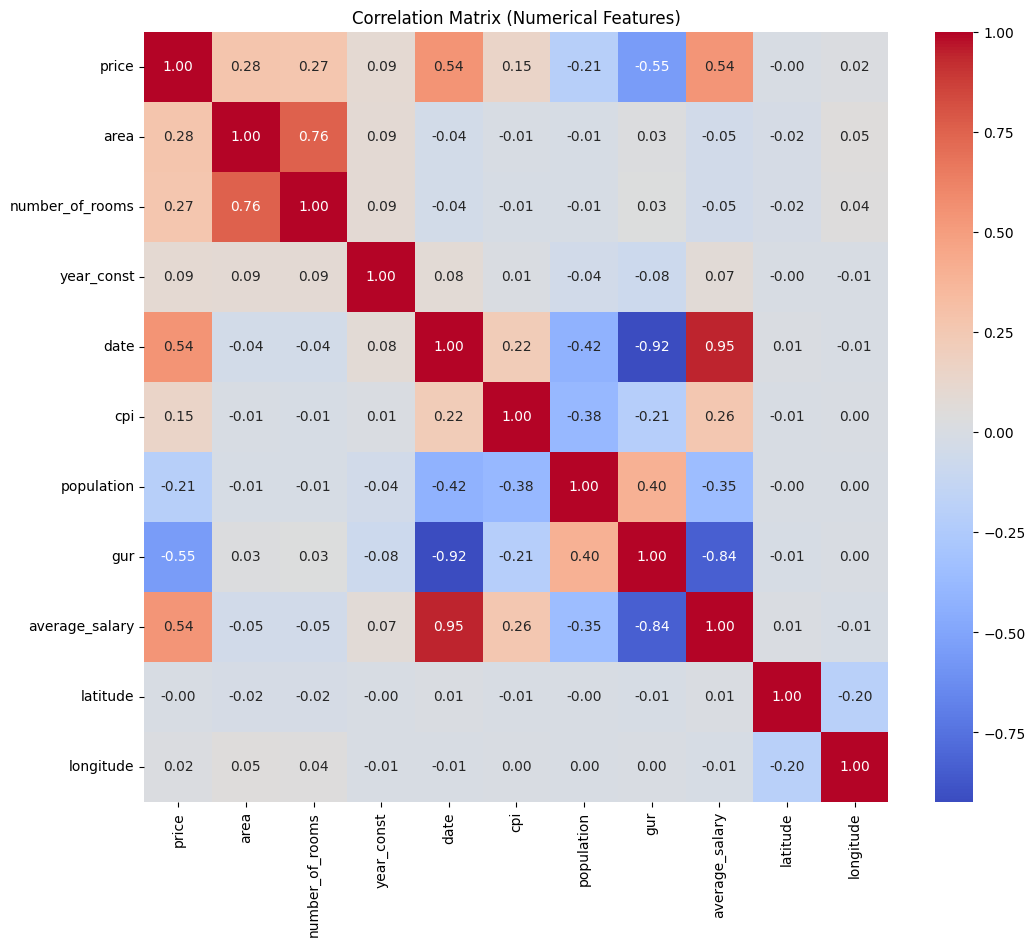

In [226]:
# Select only numeric columns (float64 and int64) for correlation analysis
numeric_data = data.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix for these numeric features
corr_matrix = numeric_data.corr()

# Visualize the correlation matrix using a heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix (Numerical Features)")
plt.show()

Overall, the correlation heatmap reveals that housing prices are most strongly driven by median income and property size (square meters, bedrooms, and bathrooms). Socioeconomic factors such as unemployment and crime rates negatively affect prices and often correlate with each other, indicating that local economic health and community safety are vital to property values. Geographic considerations (latitude in particular) also play a notable role, potentially reflecting location-based desirability. These insights offer a multifaceted view of how market, demographic, and property-specific variables interrelate, guiding both strategic real estate decisions and broader urban policy.

### Distribution of Prices by Categorical Features
Exploring the distribution of real estate prices across different categorical features such as market, advertiser type, and property type can provide valuable insights. We will use histograms with Kernel Density Estimation (KDE) to visualize the distribution and identify any patterns or outliers.

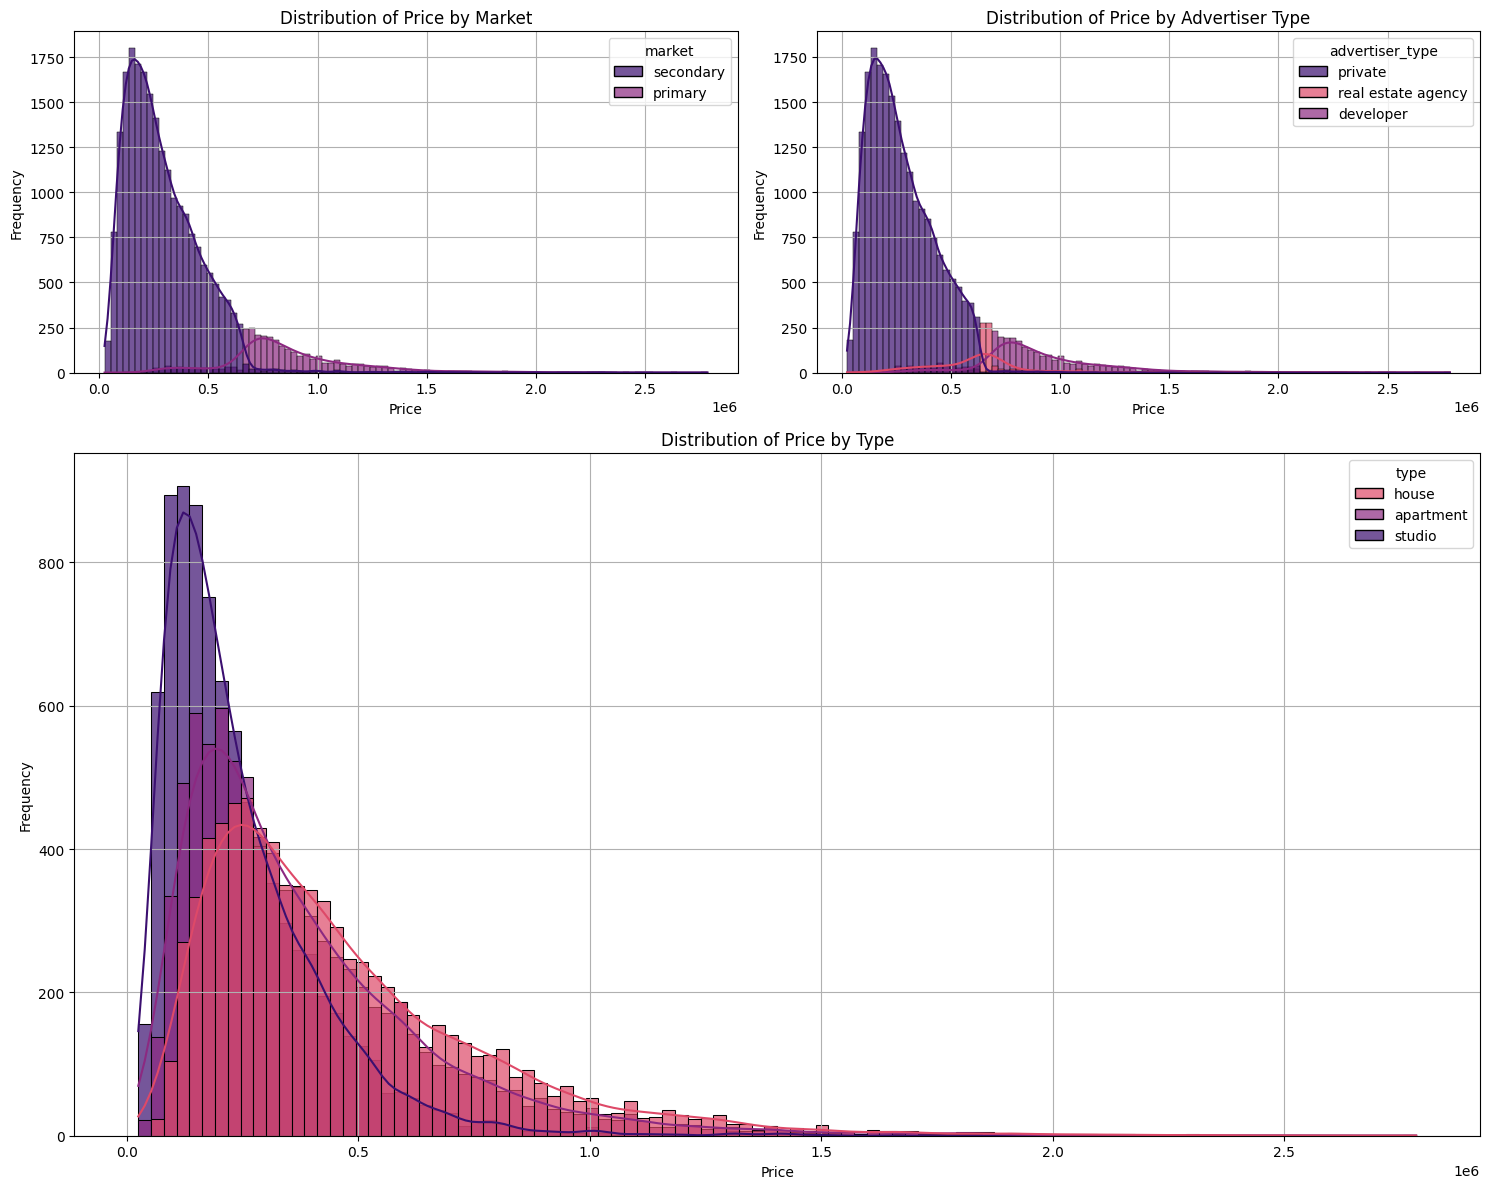

In [227]:
# List of categorical columns to analyze
columns = ['market', 'advertiser_type', 'type']

# Create a figure with a custom layout
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])  # The second row is smaller

# Create subplots in specific positions
ax1 = fig.add_subplot(gs[0, 0])  # Top left
ax2 = fig.add_subplot(gs[0, 1])  # Top right
ax3 = fig.add_subplot(gs[1, :])  # Bottom, spanning the entire width

axes = [ax1, ax2, ax3]

# Manually selected colors from the 'magma' palette
custom_palette = ["#3B0F70", "#8C2981", "#DE4968"]  # Dark purple → Pink → Orange

# Plot histograms
for i, col in enumerate(columns):
    value_counts = data[col].value_counts()
    sorted_categories = value_counts.index
    num_categories = len(sorted_categories)
    
    # Assign colors based on category count
    category_colors = {cat: custom_palette[j % len(custom_palette)] for j, cat in enumerate(sorted_categories)}

    # Plot histogram
    sns.histplot(data=data, x="price", bins=100, kde=True, alpha=0.7, hue=col, ax=axes[i], palette=category_colors)

    axes[i].set_title(f"Distribution of Price by {col.replace('_', ' ').title()}")
    axes[i].set_xlabel("Price")
    axes[i].set_ylabel("Frequency")
    axes[i].grid()

# Adjust layout
plt.tight_layout()
plt.show()

Variables `Market`, `Advertiser Type` and `Type` all exhibit a right-skewed distribution, with the majority of values concentrated at the lower end and a smaller number extending into much higher ranges. This suggests that extreme values could have a significant impact on statistical analysis and modeling. The presence of such skewness may indicate the need for transformations to improve interpretability and model stability. Observing these distributions is crucial for understanding the nature of the data and preparing it for further predictive analysis.

### Distribution of Prices by Building Characteristics
Building characteristics such as material, window type, and building type can have a significant impact on property prices. We will analyze how these characteristics influence the distribution of prices using histograms with KDE.

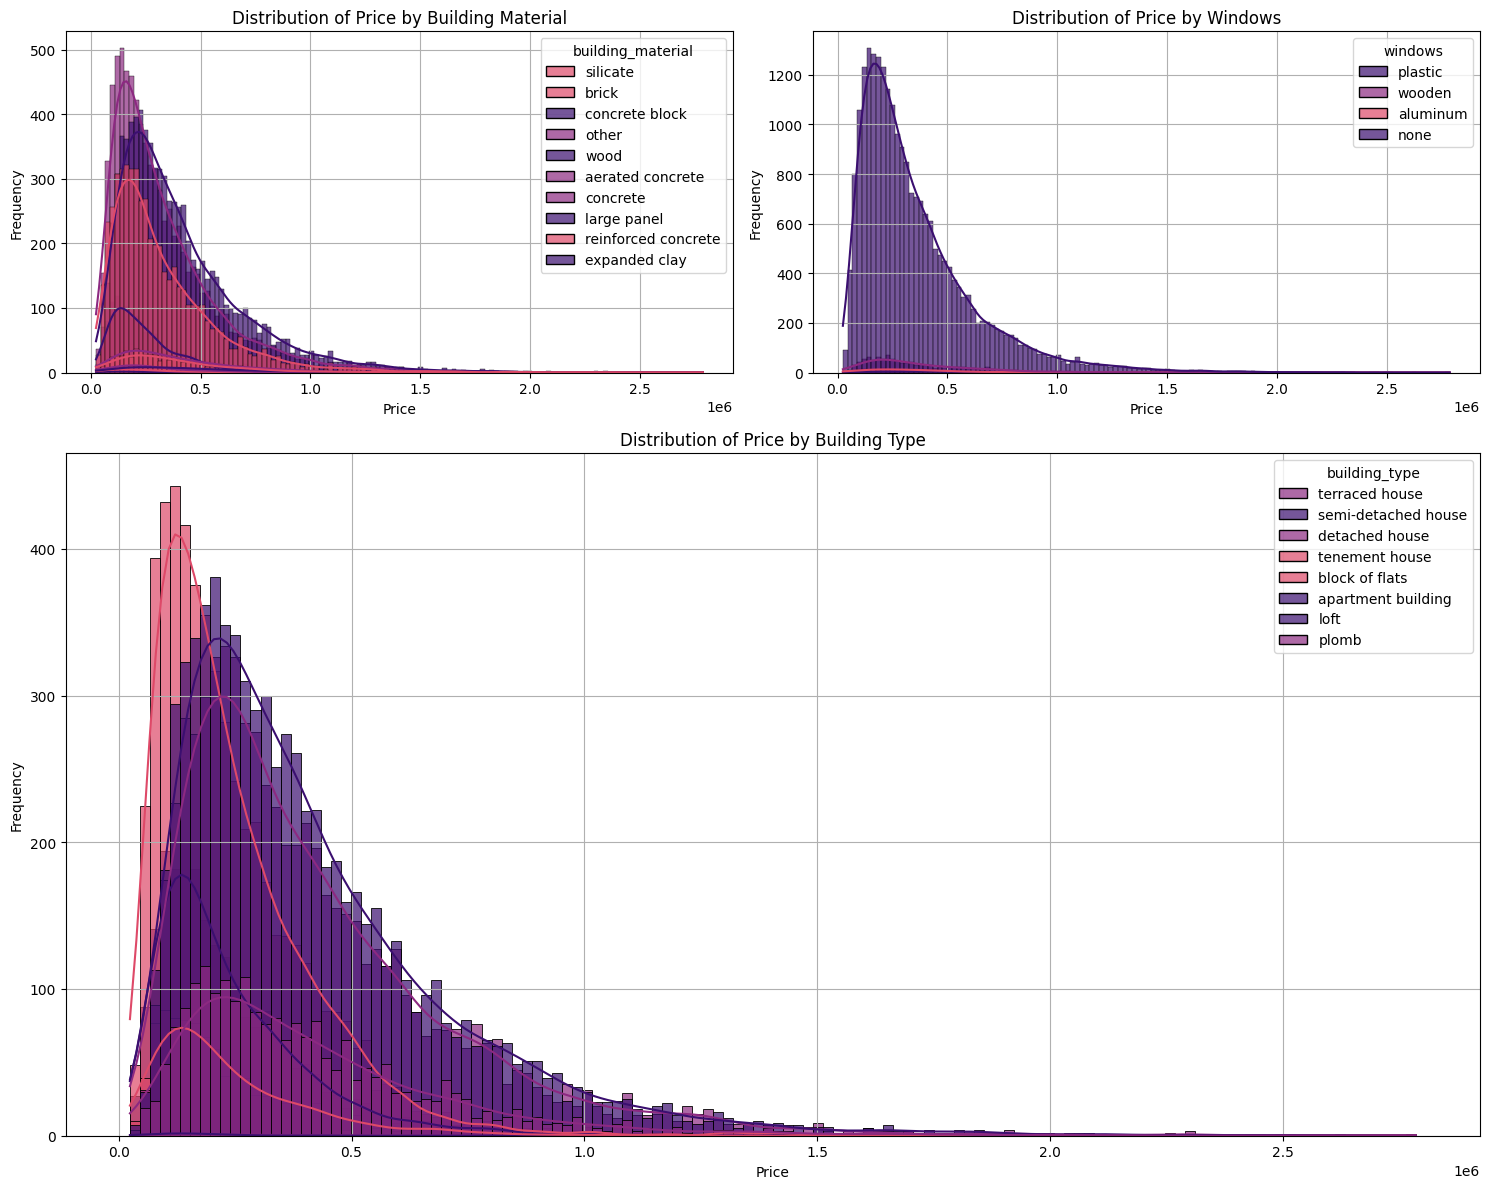

In [228]:
# List of building-related categorical columns to analyze
columns = ['building_material', 'windows', 'building_type']

# Create a figure with a custom layout
fig = plt.figure(figsize=(15, 12))
gs = fig.add_gridspec(2, 2, height_ratios=[1, 2])  

# Create subplots in specific positions
ax1 = fig.add_subplot(gs[0, 0])  # Top left
ax2 = fig.add_subplot(gs[0, 1])  # Top right
ax3 = fig.add_subplot(gs[1, :])  # Bottom, spanning the entire width

axes = [ax1, ax2, ax3]

# Manually selected colors from the 'magma' palette
custom_palette = ["#3B0F70", "#8C2981", "#DE4968"]  # Dark purple → Pink → Orange

# Plot histograms
for i, col in enumerate(columns):
    value_counts = data[col].value_counts()
    sorted_categories = value_counts.index
    num_categories = len(sorted_categories)
    
    # Assign colors based on category count
    category_colors = {cat: custom_palette[j % len(custom_palette)] for j, cat in enumerate(sorted_categories)}

    # Plot histogram
    sns.histplot(data=data, x="price", bins=128, kde=True, alpha=0.7, hue=col, ax=axes[i], palette=category_colors)

    axes[i].set_title(f"Distribution of Price by {col.replace('_', ' ').title()}")
    axes[i].set_xlabel("Price")
    axes[i].set_ylabel("Frequency")
    axes[i].grid()

# Adjust layout
plt.tight_layout()
plt.show()

Building materials show a right-skewed distribution, with materials such as brick, hollow block and cellular concrete appearing most frequently in the lower price ranges, while other materials such as reinforced concrete and expanded clay are less common and cover the higher price ranges. This suggests that material choice may play a role in pricing, although its direct impact requires further research.

Windows show a strong dominance of plastic, which appears in almost all price ranges, while wooden, aluminium and none are much less common. The distribution remains skewed, with most properties priced at the lower end. The relatively low representation of non-plastic windows may indicate that this feature has less predictive power for price.

Building type reveals a more diverse distribution, with detached and semi-detached properties covering a wider price range, while terraced and block are more concentrated in the lower price segments. Townhouse and flat block show a presence at both ends, suggesting more complex price dynamics, possibly influenced by location and other factors. This distribution highlights that building type can be a strong determinant of price modelling.

### Mean Price by Voivodeship
Understanding the average price of real estate properties across different voivodeships (regions) in Poland can help identify regions with higher or lower average prices. We will calculate and visualize the mean prices and compare them to the overall mean price.

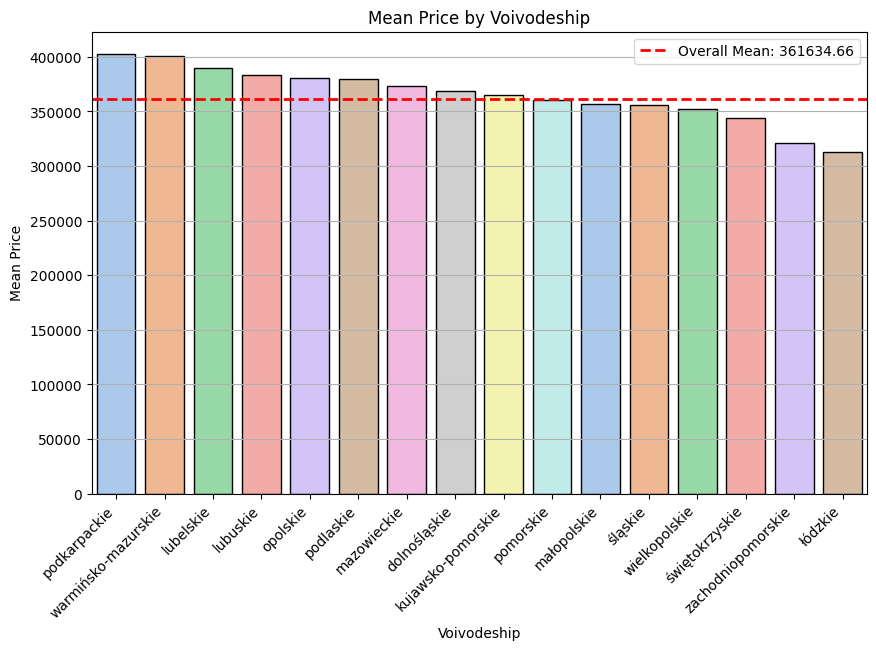

In [135]:
# Calculate the mean price by voivodeship
mean_prices = data.groupby('voivodeship', as_index=False)['price'].mean()
mean_prices_sorted = mean_prices.sort_values(by='price', ascending=False)

# Calculate overall mean price
overall_mean = data['price'].mean()

# Plot the mean prices by voivodeship
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='voivodeship', y='price', data=mean_prices_sorted, palette='pastel')

# Add black borders to each bar
for patch in ax.patches:
    patch.set_edgecolor('black')

# Draw a horizontal line for the overall mean price
plt.axhline(overall_mean, color='red', linestyle='--', linewidth=2, label=f"Overall Mean: {overall_mean:.2f}")

# Set titles and labels
plt.title("Mean Price by Voivodeship")
plt.xlabel("Voivodeship")
plt.ylabel("Mean Price")
plt.legend()
plt.grid(axis='y')

# Rotate the x-axis labels by 45 degrees for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.show()

The average price of a property varies by province, with the Subcarpathian, Warmian-Masurian and Lublin regions leading the way in terms of higher average prices. These regions exceed or closely match the overall average price, as indicated by the red dotted line. On the other hand, the West Pomeranian and Silesian regions show lower average prices, and the Łódź region stands out as the cheapest region. The relatively uniform distribution suggests that although there are regional differences, they are not very pronounced, with most provinces clustering around an overall average price level. This indicates that location remains an important factor, but may not be the dominant determinant of price.

### Price Trends Over Time
Analyzing how real estate prices have changed over time can provide insights into market trends and seasonal patterns. We will examine the average price trends and visualize them using line plots.

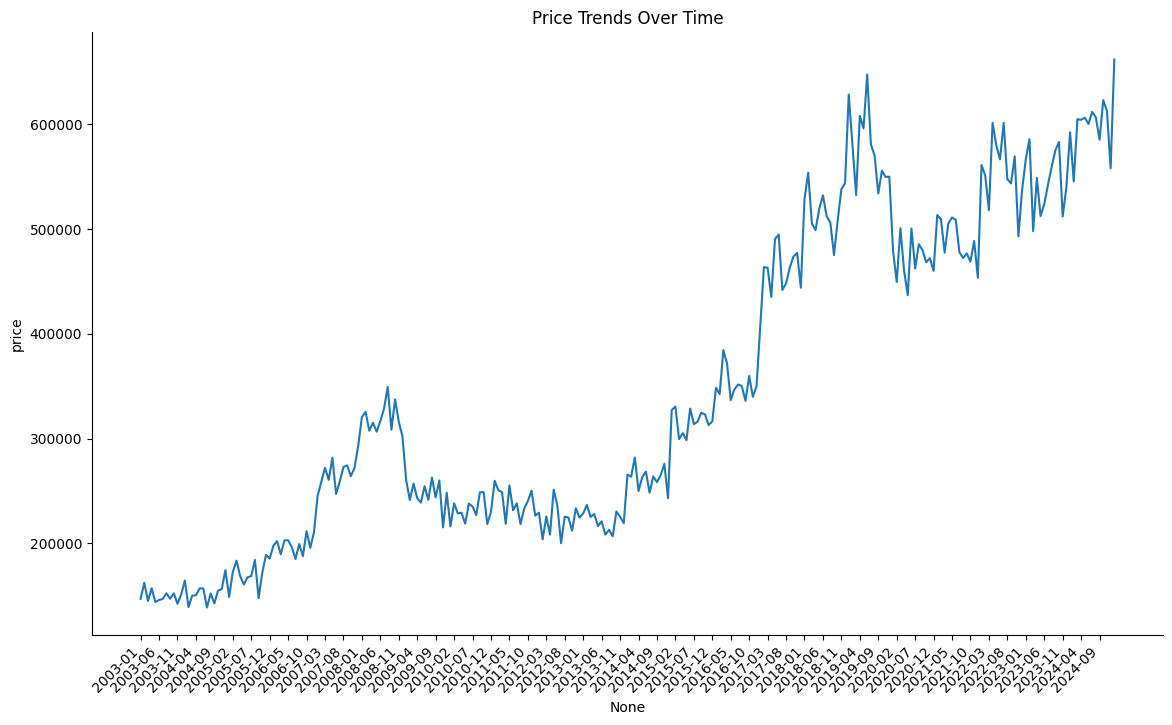

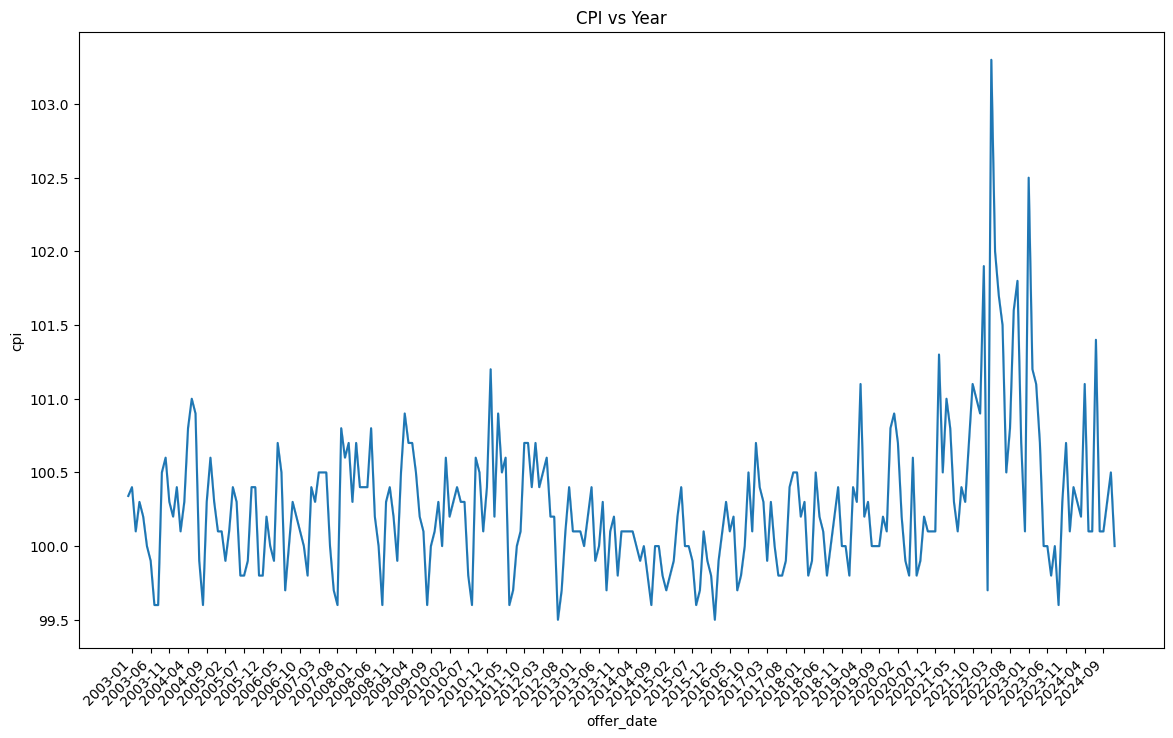

In [136]:
# Group the data by offer date and calculate the mean price
result = pd.DataFrame(data.groupby('offer_date').agg({'price': 'mean'}).to_dict())

# Plot the price trends over time

sns.relplot(x=result.index, y='price', data=result, 
            kind='line', height=6.76, aspect=14/8)
plt.title("Price Trends Over Time")
plt.xticks(result.index[::5], rotation=45, ha="right")
plt.show()

# Plot the CPI (Consumer Price Index) over time
plt.figure(figsize=(14, 8))
sns.lineplot(data=data, x='offer_date', y='cpi')
plt.title('CPI vs Year')
plt.xticks(result.index[::5], rotation=45, ha="right")
plt.show()

The price trend over time indicates a general upward movement, with noticeable fluctuations and periods of stagnation. Initially, prices exhibit a steady increase, followed by a plateau, after which a sharp surge occurs, suggesting a strong market appreciation. More recent data highlights increased volatility, with prices reaching new highs.

The consumer price index (CPI) trend, on the other hand, shows relatively stable fluctuations at the beginning, but a significant spike appears in later periods. This surge suggests inflationary pressures or economic shifts that may have influenced purchasing power and market behavior. The correlation between the two trends suggests that external economic factors, such as inflation, may have played a role in driving property prices upward.

### Price Distribution by Property Type and Market
Understanding how prices are distributed across different property types and markets can provide insights into market segmentation. We will use box plots to visualize the distribution of prices.

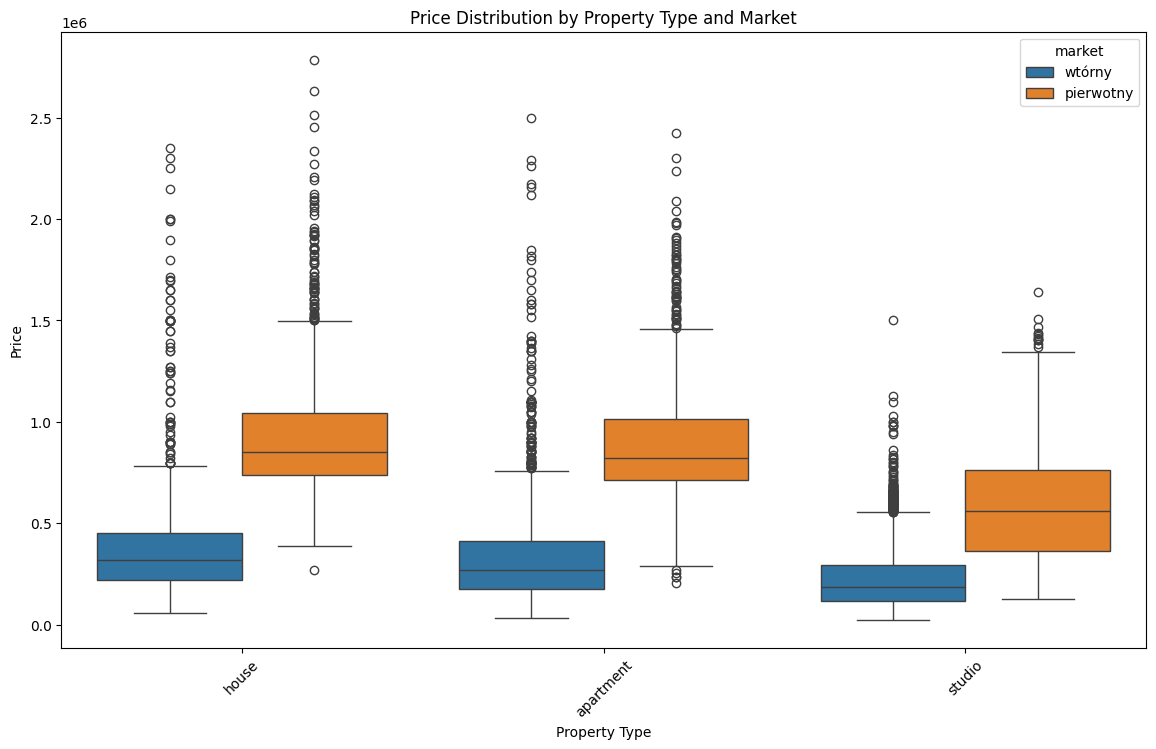

In [137]:
# Plot the distribution of prices by property type and market
plt.figure(figsize=(14, 8))
sns.boxplot(x='type', y='price', hue='market', data=data)
plt.title("Price Distribution by Property Type and Market")
plt.xlabel("Property Type")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

The boxplot illustrates the distribution of property prices across different property types, distinguishing between the primary and secondary markets. Across all categories—houses, apartments, and studios—properties in the primary market exhibit consistently higher median prices compared to those in the secondary market. This suggests that newly built properties generally command a price premium over existing ones.

The spread of prices in both markets reveals significant variability, with numerous outliers indicating the presence of exceptionally high-priced properties. While the interquartile range for the secondary market remains relatively compact, the primary market shows a wider distribution, particularly in the upper range, suggesting a broader spectrum of pricing influenced by factors such as location, amenities, and developer pricing strategies.

Among the property types, houses and apartments display similar pricing trends, while studios in the primary market also reach relatively high prices, possibly due to their appeal to investors or premium locations. Overall, the analysis confirms that new properties tend to be more expensive, while the secondary market offers more price stability and fewer extreme values.

### Price Distribution by Building Material and Windows
Analyzing how building materials and window types influence prices can provide insights into the quality and desirability of properties. We will use violin plots to visualize the distribution of prices.

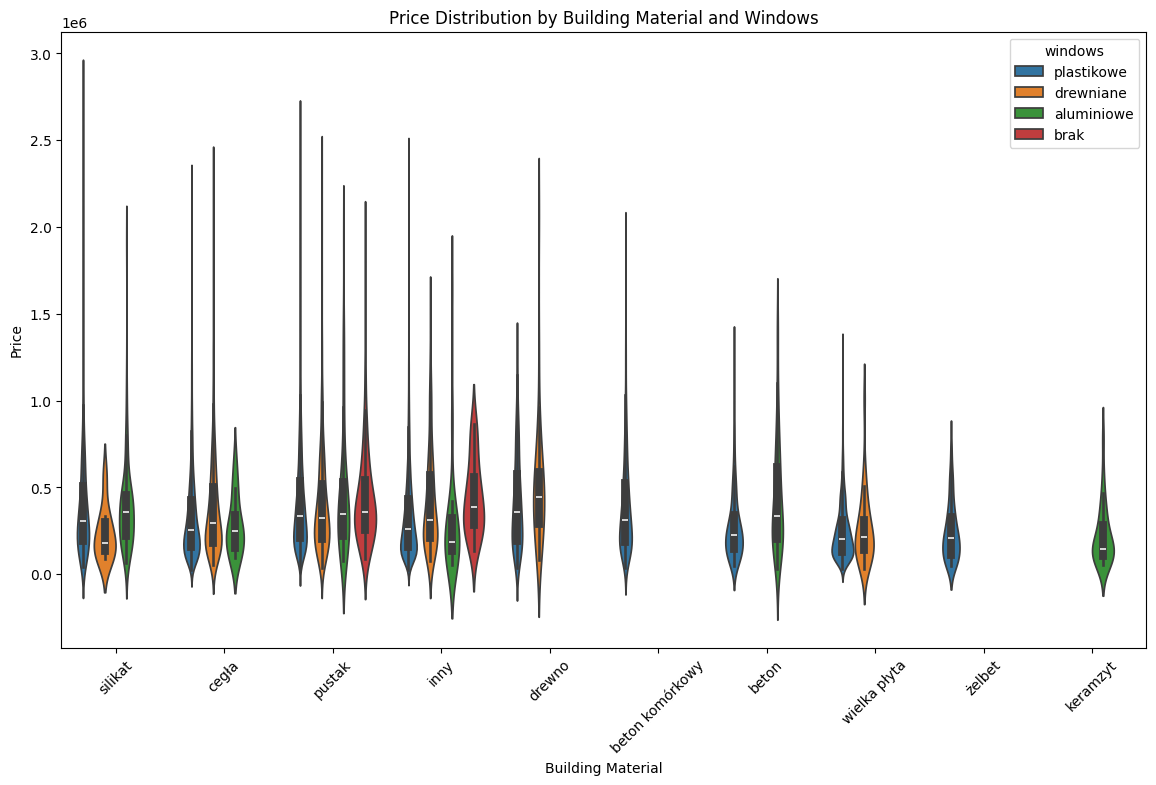

In [138]:
# Plot the distribution of prices by building material and windows
plt.figure(figsize=(14, 8))
sns.violinplot(x='building_material', y='price', hue='windows', data=data, split=False)
plt.title("Price Distribution by Building Material and Windows")
plt.xlabel("Building Material")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

The violin plot illustrates how property prices vary based on building materials and window types. Properties built with materials such as wood, brick, and hollow blocks tend to exhibit the highest price variation, with some listings exceeding 2.5 million. In contrast, buildings constructed from reinforced concrete, standard concrete, and large panel prefabrication have more concentrated price distributions, suggesting that their prices are more stable and predictable.

Window type also appears to influence price ranges. Properties with plastic and wooden windows are the most common across different building materials, while those with aluminum windows tend to be in higher price brackets, indicating their association with more premium properties. Listings without windows are rare and usually fall within the lower price range.

Another notable trend is that wooden buildings, in particular, show a wide spread in prices, likely due to the mix of both high-end and lower-end properties within this category. Concrete-based structures, on the other hand, maintain more predictable pricing, as they are commonly used in standardized developments. Properties made from silicate and aerated concrete also display relatively stable price distributions.

Overall, the plot reveals that both building material and window type have an impact on property pricing. More traditional and high-quality materials, such as brick and wood, allow for a broader range of prices, possibly due to variations in property quality and location. Meanwhile, materials often used in mass construction, like prefabricated concrete panels, tend to result in more uniform pricing. Additionally, aluminum windows often appear in higher-end listings, reinforcing the idea that specific features contribute to a property’s value.

### Price Distribution by Voivodeship and Building Type
Understanding how prices vary across different voivodeships and building types can provide insights into regional market dynamics. We will use grouped bar plots to visualize the mean prices.

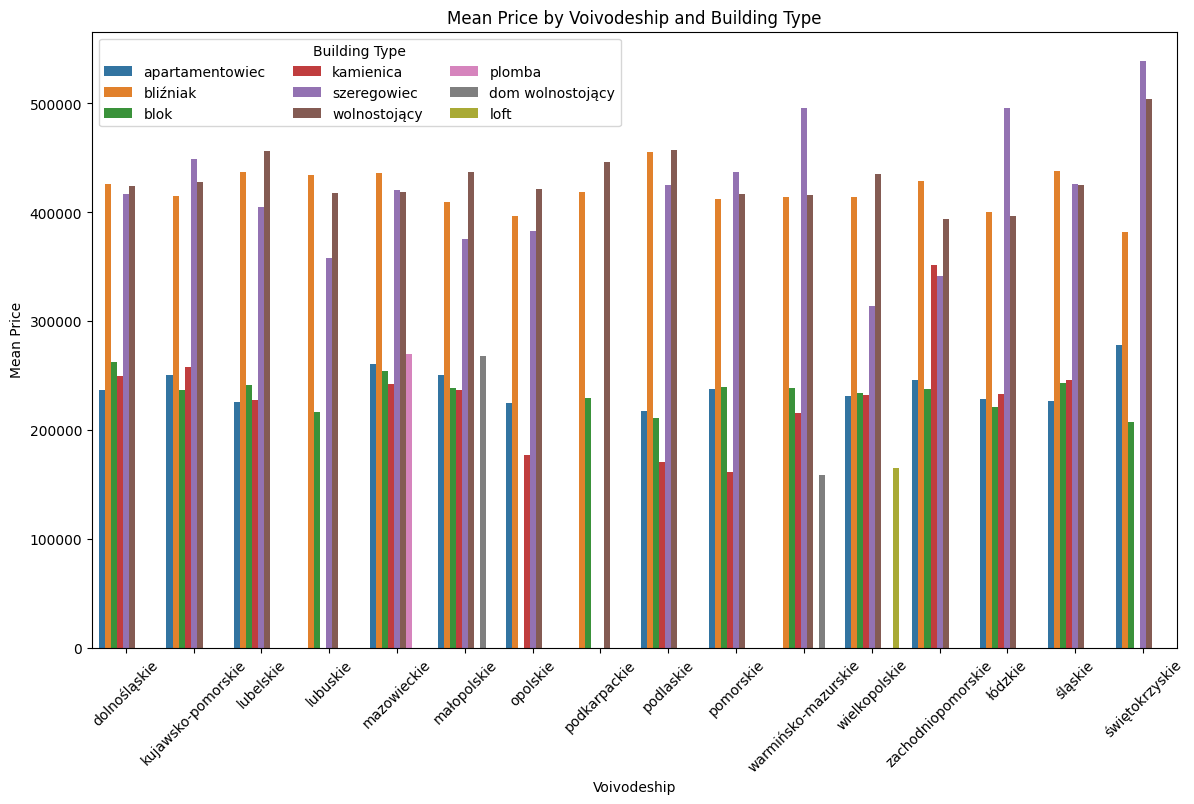

In [139]:
# Calculate the mean price by voivodeship and building type
mean_prices_voivodeship_building = data.groupby(['voivodeship', 'building_type'], as_index=False)['price'].mean()

# Plot the mean prices by voivodeship and building type
plt.figure(figsize=(14, 8))
sns.barplot(x='voivodeship', y='price', hue='building_type', data=mean_prices_voivodeship_building)
plt.title("Mean Price by Voivodeship and Building Type")
plt.xlabel("Voivodeship")
plt.ylabel("Mean Price")
plt.xticks(rotation=45)
plt.legend(title="Building Type", loc='upper left', ncol=3)
plt.show()

The bar chart shows the average property prices in the different provinces, categorised by building type. A clear trend shows that lofts and detached houses consistently rank among the most expensive property types in all regions, often exceeding the average price of 400,000 to 500,000. In contrast, flat blocks and condominiums tend to cluster in the lower price range, making them more affordable options.

The Mazovian region, which includes Warsaw, shows some of the highest property prices overall, with particularly expensive lofts and detached houses. Similarly, Malopolska and Pomerania show a comparable trend, probably influenced by the presence of large cities such as Krakow and Gdansk. These urban centres increase the demand for premium housing, including townhouses and detached houses.

On the other hand, regions such as Podlaskie, Lubelskie and Świętokrzyskie are generally characterised by lower average property prices, regardless of building type. This suggests that these areas may be less economically developed or characterised by lower property demand compared to the main metropolitan regions.

Another notable observation is the consistent price gap between building types within each voivodeship. Detached houses and lofts maintain a significant lead over townhouses, terraced houses, and blocks of flats, which remain in the mid-to-lower price range. This implies that property type is a strong determinant of price, even more so than location in some cases.

Overall, the plot highlights significant regional differences in property pricing while reinforcing the notion that lofts and detached houses cater to higher-income buyers, whereas apartment blocks and terraced houses provide more budget-friendly alternatives across Poland.

### Price Distribution by Advertiser Type and Property Type
Analyzing how prices vary across different advertiser types and property types can provide insights into the influence of advertisers on property prices. We will use stacked bar plots to visualize the distribution of prices.

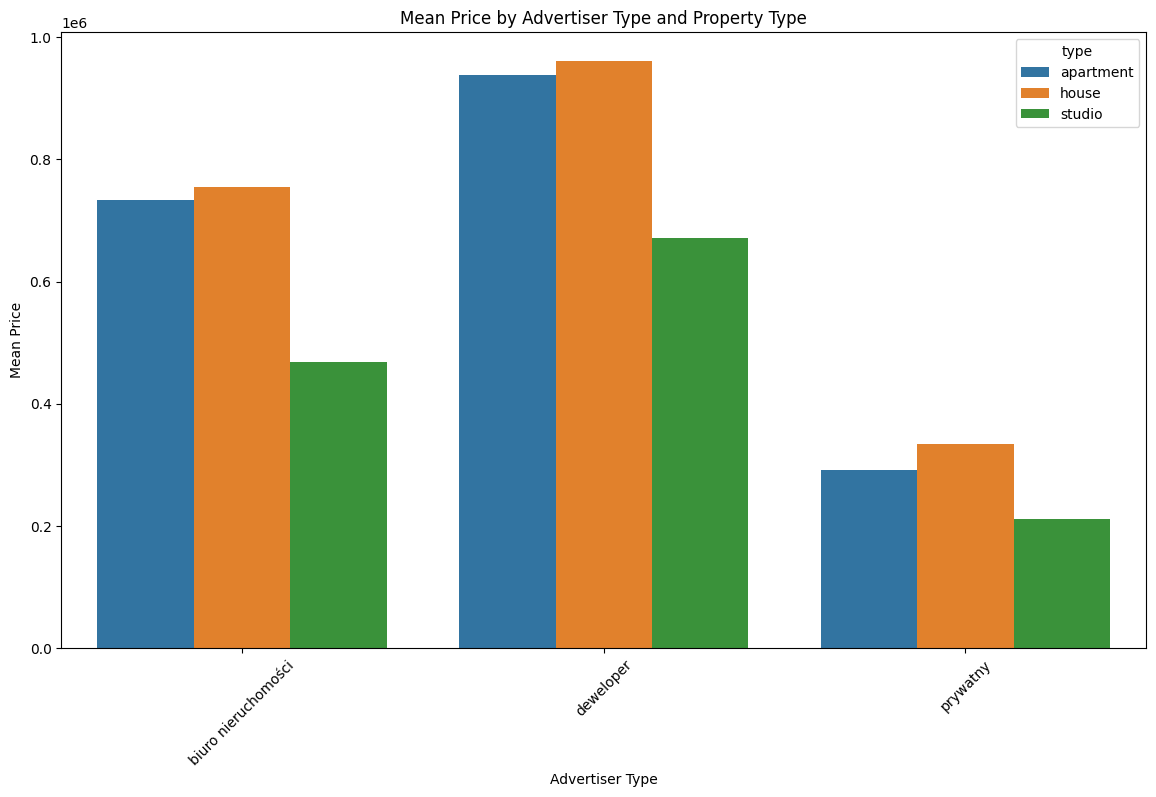

In [140]:
# Calculate the mean price by advertiser type and property type
mean_prices_advertiser_type = data.groupby(['advertiser_type', 'type'], as_index=False)['price'].mean()

# Plot the mean prices by advertiser type and property type
plt.figure(figsize=(14, 8))
sns.barplot(x='advertiser_type', y='price', hue='type', data=mean_prices_advertiser_type)
plt.title("Mean Price by Advertiser Type and Property Type")
plt.xlabel("Advertiser Type")
plt.ylabel("Mean Price")
plt.xticks(rotation=45)
plt.show()

The bar plot illustrates the mean property prices based on the type of advertiser, distinguishing between apartments, houses, and studios. A distinct trend emerges, revealing that properties listed by developers are the most expensive across all categories, with apartments and houses reaching close to 1,000,000 in mean price, while studios remain significantly lower but still surpass those offered by private sellers and real estate agencies.

Real estate agencies follow a similar pattern but at a slightly lower price range. The gap between apartments and houses is minimal in this category, suggesting that agencies operate within a mid-to-upper price segment, catering to buyers looking for both property types at similar valuations. Studios, however, remain notably cheaper, aligning with their smaller size and typically lower market value.

Private sellers offer the least expensive properties, with all categories averaging substantially lower prices compared to agencies and developers. This trend indicates that private listings are more common in the lower or mid-tier market, where individual sellers may be more flexible on pricing compared to structured agencies or developers.

Overall, the visualization confirms that developers dominate the high-end property market, particularly for houses and apartments, while private sellers are focused on more affordable options. Meanwhile, real estate agencies serve as a middle ground, offering properties at competitive but not excessively high prices.

### Price Distribution by Rooms and Area
Analyzing how prices vary with the number of rooms and area can provide insights into the relationship between property size and price. We will use scatter plots to visualize this relationship.

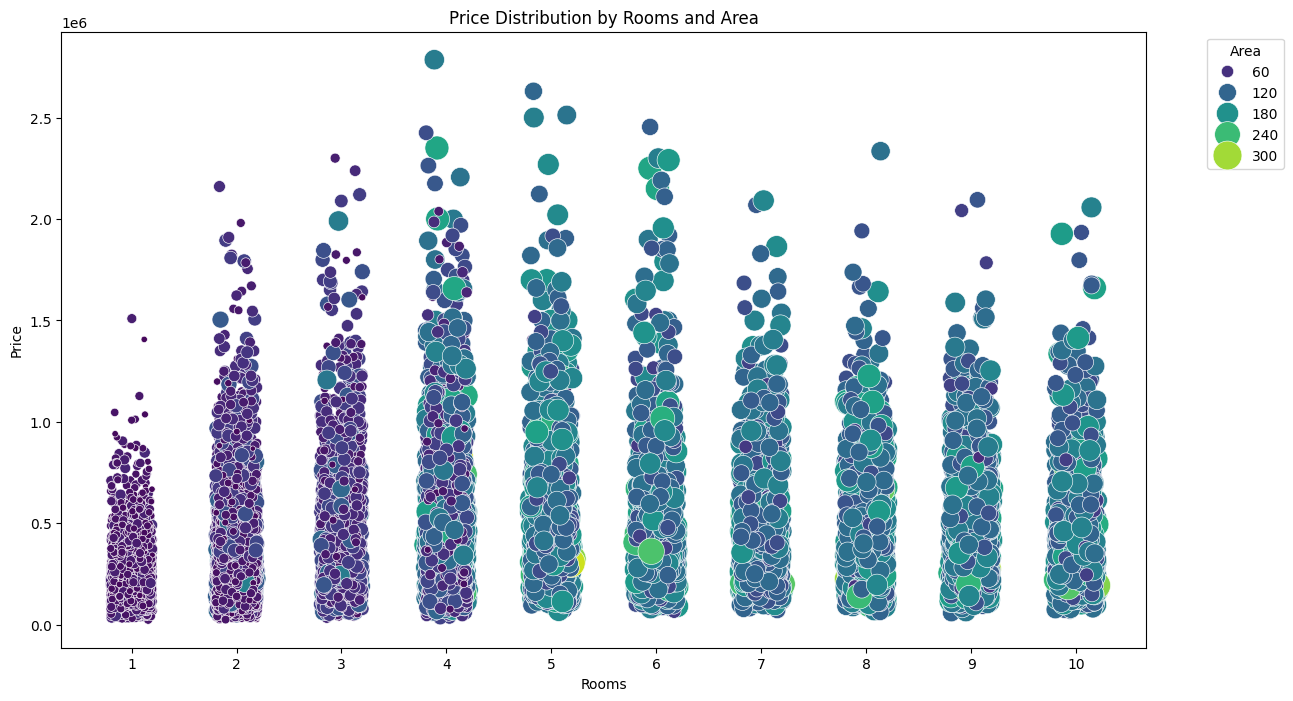

In [141]:
# Adding random noise to the number of rooms to avoid points aligning in a single line
data_witch_jittered_rooms = data.copy()
data_witch_jittered_rooms['jittered_rooms'] = data_witch_jittered_rooms['number_of_rooms'] + np.random.uniform(-0.2, 0.2, size=len(data_witch_jittered_rooms))
# Creating a scatter plot to visualize price distribution by number of rooms and area
plt.figure(figsize=(14, 8))
scatter = sns.scatterplot(x='jittered_rooms', y='price', size='area', hue='area',  sizes=(10, 500), palette='viridis', data=data_witch_jittered_rooms)
# Setting plot title and labels
plt.title("Price Distribution by Rooms and Area")
plt.xlabel("Rooms")
plt.ylabel("Price")
# Setting x-axis tick marks for better readability (1 to 10 rooms)
plt.xticks(range(1, 11))
# Adjusting the legend position for better readability
plt.legend(title="Area", bbox_to_anchor=(1.05, 1), loc='upper left')  
plt.show()

The scatter plot visualizes the distribution of property prices based on the number of rooms, with an additional color gradient indicating property area. A clear trend emerges, showing that properties with more rooms generally have higher prices, which aligns with the expectation that larger properties, offering more living space, command a premium. However, within each room category, a wide price range is observed, suggesting that other factors—such as location, amenities, and market conditions—also play a significant role in determining value. The color gradient, representing area, indicates that larger properties (with higher square meter values) tend to be priced higher, reinforcing the relationship between size and cost. The distribution remains relatively dense for properties with up to six rooms, but beyond this point, listings become sparser, which suggests that homes with a very high number of rooms are less common in the dataset

### Price Distribution by Offer Date and CPI
Understanding how prices vary with the offer date and CPI can provide insights into the influence of economic factors on real estate prices. We will use line plots to visualize this relationship.

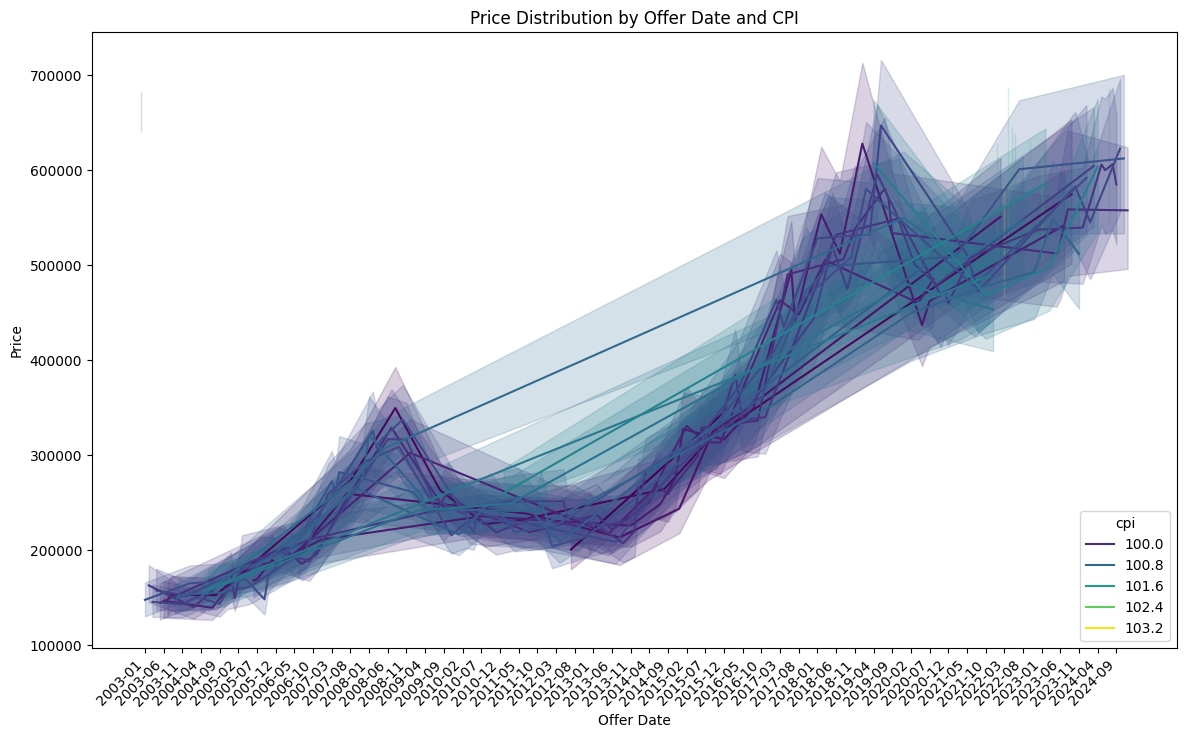

In [142]:
# Plot the relationship between offer date, CPI, and price
plt.figure(figsize=(14, 8))
sns.lineplot(x='offer_date', y='price', hue='cpi', palette='viridis', data=data)
plt.title("Price Distribution by Offer Date and CPI")
plt.xlabel("Offer Date")
plt.ylabel("Price")
plt.xticks(result.index[::5], rotation=45, ha="right")
plt.show()

The line plot illustrates how property prices have evolved over time in relation to the Consumer Price Index (CPI). The general upward trend in property prices suggests consistent market growth, likely driven by inflation, demand fluctuations, and economic conditions. The shaded regions indicate variability, with some periods experiencing more volatility than others. The CPI values, represented through a color gradient, suggest that as inflation rises, property prices tend to follow suit. The correlation between CPI and real estate prices is expected, as higher inflation often leads to increased costs for construction materials, labor, and financing, ultimately pushing property values higher. The sharp incline in prices in the latter period highlights accelerating growth, which could be attributed to market booms, low interest rates, or increased investment activity. This visualization effectively captures the long-term impact of economic factors on real estate pricing.

### Price Distribution by Voivodeship and Advertiser Type
Analyzing how prices vary across different voivodeships and advertiser types can provide insights into regional market dynamics and the influence of advertisers. We will use grouped bar plots to visualize the mean prices.

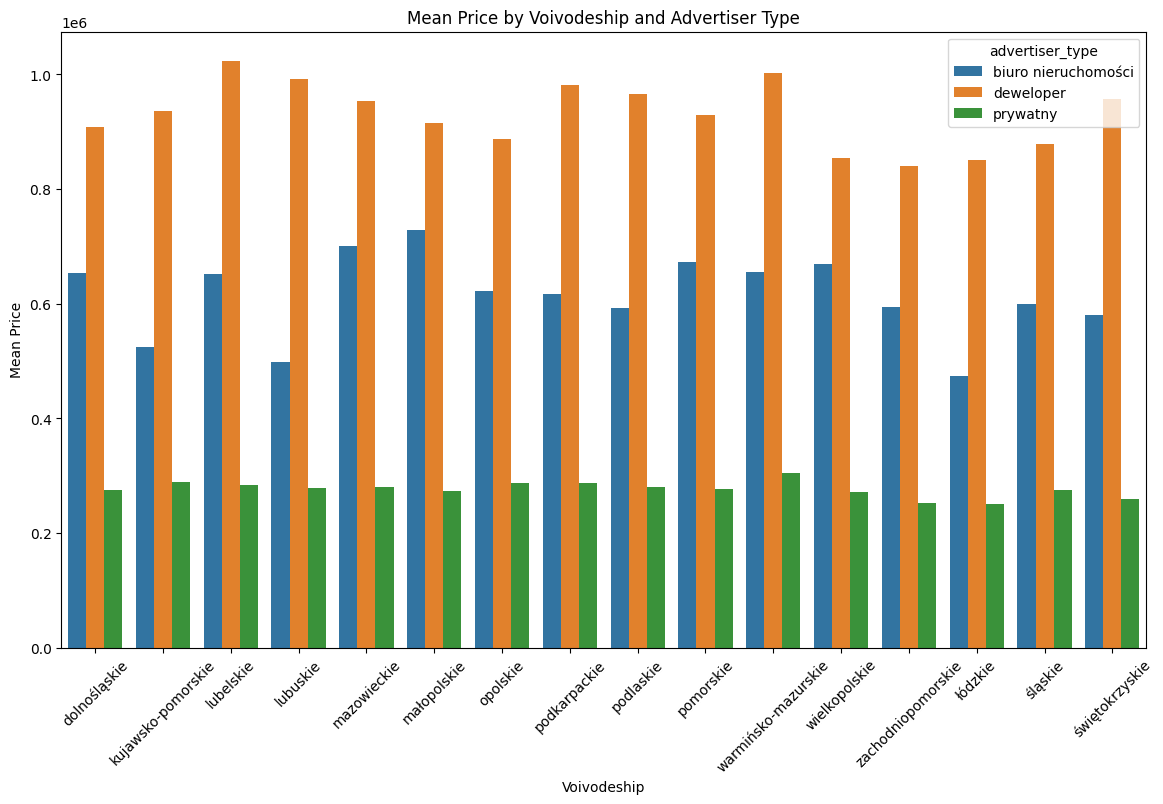

In [143]:
# Calculate the mean price by voivodeship and advertiser type
mean_prices_voivodeship_advertiser = data.groupby(['voivodeship', 'advertiser_type'], as_index=False)['price'].mean()

# Plot the mean prices by voivodeship and advertiser type
plt.figure(figsize=(14, 8))
sns.barplot(x='voivodeship', y='price', hue='advertiser_type', data=mean_prices_voivodeship_advertiser)
plt.title("Mean Price by Voivodeship and Advertiser Type")
plt.xlabel("Voivodeship")
plt.ylabel("Mean Price")
plt.xticks(rotation=45)
plt.show()

This bar chart presents the mean property prices across different voivodeships, segmented by the type of advertiser: real estate agencies, developers, and private sellers. A striking pattern emerges, with developers consistently listing properties at the highest prices across all regions. This aligns with expectations, as developers often sell new properties, which tend to be priced at a premium due to modern construction standards, warranties, and amenities.

Real estate agencies occupy the middle ground in terms of pricing. This suggests that while agencies facilitate sales for both new and second-hand properties, their pricing is typically higher than private sellers, possibly due to added service costs and commission structures.

Private sellers consistently list properties at the lowest average prices in every voivodeship. This trend likely reflects the nature of private sales, which often involve older properties or those requiring renovations, resulting in lower market valuations. Additionally, private sellers may price their properties more competitively to attract buyers quickly, avoiding agency fees.

While the overall ranking among advertiser types remains consistent across regions, there are variations in absolute price levels. Voivodeships such as Lubelskie and Warmińsko-Mazurskie show relatively high average prices across all advertiser types, indicating strong real estate markets in these areas. In contrast, regions like Łódzkie and Zachodniopomorskie display lower prices, likely reflecting differences in economic activity, demand, and purchasing power.

### Distribution plots of all numeric variables

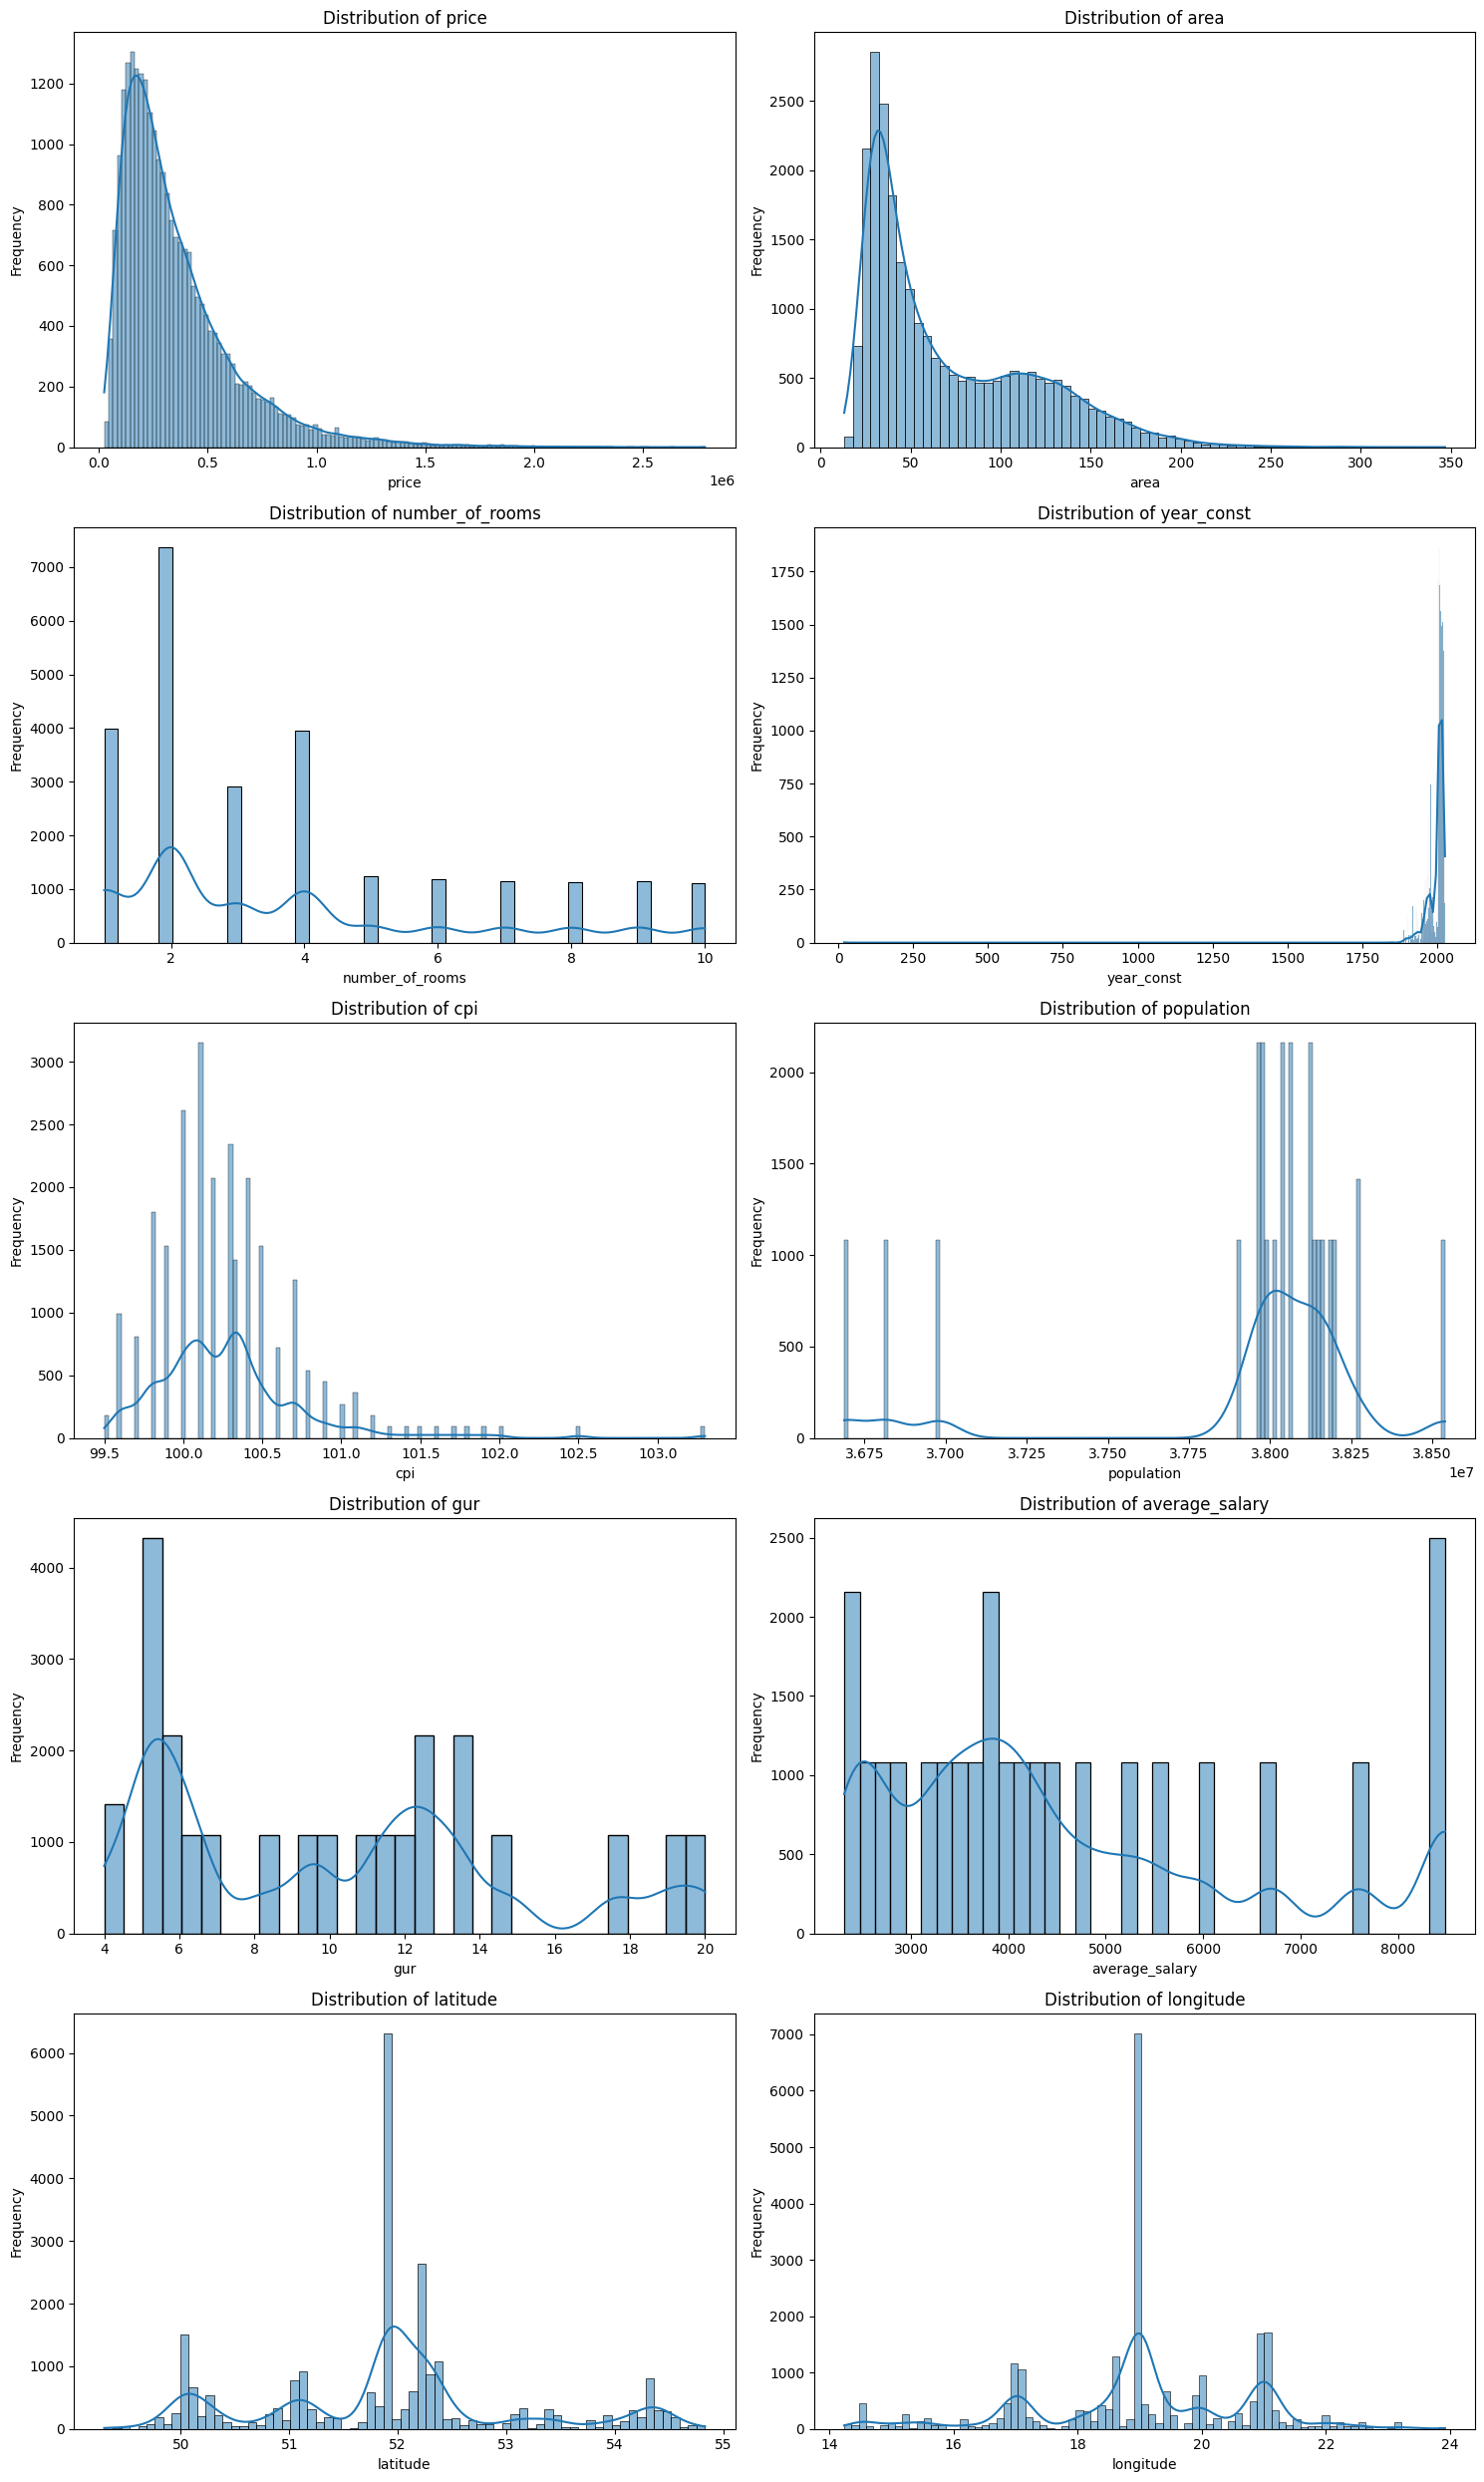

In [144]:
# Creating a copy of the dataset to avoid modifying the original data
df = data.copy()

# Selecting only numerical columns for analysis
numeric_columns = df.select_dtypes(include=[np.number]).columns
df_numeric = df[numeric_columns]

# Calculate the number of rows needed for 2 plots per row
num_plots = len(numeric_columns)
num_rows = (num_plots + 1) // 2  # Add 1 to ensure rounding up

# Create subplots with 2 columns and the required number of rows
fig, axes = plt.subplots(num_rows, 2, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Plot the distribution for each numerical column
for i, col in enumerate(numeric_columns):
    sns.histplot(df_numeric[col], kde=True, ax=axes[i])
    axes[i].set_title(f"Distribution of {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("Frequency")

# Hide any empty subplots
for j in range(i + 1, num_rows * 2):
    fig.delaxes(axes[j])

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

The distribution plots reveal several key patterns in the dataset. The price and area variables exhibit a strong right skew, indicating that while most properties are priced and sized within a lower range, there are some significantly larger and more expensive ones. The number of rooms follows a discrete distribution, with peaks at common values like 2, 3, and 4, suggesting standardization in housing layouts. The year of construction shows a heavy concentration in recent years, which is expected due to the continuous development of real estate.

The CPI distribution is slightly skewed but relatively concentrated around 100, reflecting general economic stability. Population data appears highly structured with distinct peaks, possibly due to how the data was collected or grouped by location. The average salary and real estate variables also show irregular distributions, likely influenced by regional economic factors.

Latitude and longitude reveal strong clustering, suggesting that most listings are concentrated in specific geographic areas, which could indicate high urban density or preferred locations. This is reinforced by the detected outliers, where price and CPI stand out as having the most extreme values, likely due to luxury properties and economic variations.

Overall, these distributions suggest clear patterns in real estate characteristics, economic factors, and geographic clustering, which should be further explored through spatial analysis to confirm any dependencies between location and price.

### Detecting outliers (Z-score)

In [145]:
# Calculating Z-scores to detect outliers
z_scores = np.abs(zscore(df_numeric.dropna()))  

# Counting the number of outliers for each variable (values with Z-score > 3)
outliers = (z_scores > 3).sum(axis=0)

# Creating a DataFrame to present the results in a structured table
outliers_table = pd.DataFrame({
    "Variable": outliers.index,
    "Number of Outliers": outliers.values
})

print(outliers_table)

          Variable  Number of Outliers
0            price                 473
1             area                 160
2  number_of_rooms                   0
3       year_const                  20
4              cpi                 450
5       population                   0
6              gur                   0
7   average_salary                   0
8         latitude                   0
9        longitude                   0


The analysis of outliers using the Z-score method highlights some notable trends. The highest number of outliers is observed in the price variable (473 cases), which suggests the presence of luxury properties or extremely low-priced listings that deviate significantly from the majority. This aligns with the highly skewed distribution of prices, where a small number of properties have disproportionately high values.

The area variable also has a notable number of outliers (160 cases), likely reflecting the presence of exceptionally large or small properties compared to the typical range. This is expected, as real estate markets often include both compact apartments and expansive villas.

The CPI variable has 450 outliers, which is unusual given that CPI typically remains within a controlled range over time. This could be due to data collection inconsistencies, missing values, or incorrect CPI mappings to specific locations.

Other variables, such as year of construction (20 outliers), indicate a few extreme cases, possibly very old historical buildings or newly developed properties that stand apart from the norm.

Interestingly, geographical features like latitude and longitude have no detected outliers, reinforcing the idea that the dataset primarily represents urban clusters without extreme variations in geographic positioning.

Overall, the presence of these outliers suggests that while most real estate listings follow expected patterns, a subset of properties is significantly different in terms of price, size, and economic indicators. These should be carefully examined to determine whether they result from genuine market variations, data entry errors, or special property attributes such as historical significance or high-end luxury offerings.

### Geospatial Analysis of Property Prices
Geographic location plays a crucial role in determining property prices, as factors such as proximity to urban centers, infrastructure, and regional economic conditions heavily influence real estate values. The following analysis explores spatial dependencies in property prices using heatmaps and scatterplots, offering insights into how latitude and longitude correlate with pricing trends.

Price Distribution Across Geographic Coordinates
The scatterplots illustrate how property prices vary with longitude and latitude. While there is no strict linear correlation, price clusters align with major cities and economic hubs. Peaks in price density suggest strong demand in metropolitan areas such as Warsaw, Gdańsk, and Wrocław. However, significant variability in prices indicates that additional factors beyond location, such as property size, amenities, and market conditions, influence real estate values.

In [146]:
# Removing rows that do not have coordinates (latitude, longitude) or price values
df = df.dropna(subset=["latitude", "longitude", "price"])

# Creating a base map centered around the mean latitude and longitude of the dataset
m_heatmap = folium.Map(location=[df["latitude"].mean(), df["longitude"].mean()], zoom_start=11)

# Preparing data for the heatmap (latitude, longitude, and price as weight)
heat_data = [[row["latitude"], row["longitude"], row["price"]] for _, row in df.iterrows()]

# Adding the heatmap layer to the map
HeatMap(heat_data, radius=15, max_zoom=13).add_to(m_heatmap)

# Saving the heatmap as an HTML file for visualization
m_heatmap.save("mapa_cieplna.html")

# Displaying the generated heatmap
m_heatmap

The heatmap provides a spatial representation of property concentration across Poland, highlighting areas with higher densities of listings. The most prominent hotspots are in Warsaw, Wrocław, and the Tricity (Gdańsk, Gdynia, Sopot), which aligns with expectations as these cities have highly active real estate markets due to economic opportunities, population density, and demand.

Warsaw stands out as the most intense cluster, reinforcing its position as the country's central hub for real estate transactions. The Tricity area along the Baltic coast also exhibits strong activity, likely influenced by both residential and vacation property markets.

Other notable clusters appear in Wrocław, Kraków, Poznań, and Katowice, which are Poland’s key economic and academic centers. Their well-developed infrastructure and growing business sectors make them attractive locations for both investors and homeowners.

Smaller but still noticeable hotspots appear in cities like Bydgoszcz, Toruń, Lublin, and Rzeszów, indicating moderate real estate activity. There are also scattered clusters in regions that might be tourist destinations or areas with local economic significance.

The more dispersed and weaker heat zones in rural areas indicate lower real estate activity, which is expected due to lower demand and population density. The presence of some isolated hotspots in less urbanized regions suggests potential niche markets, such as properties in vacation or recreational areas.

Overall, the heatmap reveals strong spatial dependence in real estate distribution, with the majority of transactions concentrated in major cities and a few emerging regional hubs. This pattern suggests that urban centers dominate the property market, while peripheral areas show limited but potentially growing activity.

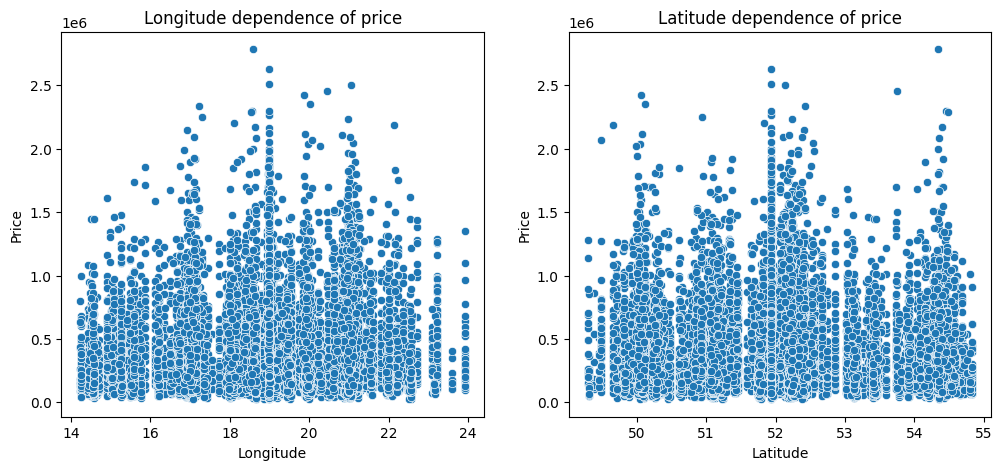

In [147]:
# Creating a figure with two subplots to analyze the relationship between price and geographic coordinates
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Scatter plot showing the relationship between longitude and price
sns.scatterplot(data=df, x="longitude", y="price", ax=axes[0])
axes[0].set_title("Longitude dependence of price")
axes[0].set_xlabel("Longitude")  # Corrected xlabel to apply specifically to the left plot
axes[0].set_ylabel("Price")  

# Scatter plot showing the relationship between latitude and price
sns.scatterplot(data=df, x="latitude", y="price", ax=axes[1])
axes[1].set_title("Latitude dependence of price")
axes[1].set_xlabel("Latitude")
axes[1].set_ylabel("Price")

plt.show()

The scatterplots illustrate the relationship between geographic coordinates (longitude and latitude) and property prices.

In the left plot (price vs. longitude), there is no clear linear trend, but clusters of high-price properties appear around certain longitudes. Peaks in density likely correspond to major urban centers, with a notable concentration around Warsaw (`~21°E`) and the Tricity region (`~18°E`). The dispersed nature of the points suggests that while location influences price, there are many other contributing factors.

The right plot (price vs. latitude) follows a similar pattern, with price concentrations around specific latitudes. Notable clusters likely align with Poland's most economically active regions, such as Warsaw, Wrocław, Kraków, and Gdańsk. Higher prices tend to be found in well-developed urban centers, with fewer high-value properties in the northern and southern extremes.

Both plots highlight a high variability in property prices across geographic locations, reinforcing the idea that while geography plays a role, other factors such as local economic conditions, infrastructure, and demand significantly impact pricing. The presence of outliers at high price levels suggests luxury properties in prime locations.

### Final conclusions from data exploration
In the course of analysing the data on house prices in Poland, key decisions were made to prepare the dataset for further modelling. First of all, the variables windows (type of windows) and heating (method of heating) were removed. This decision was due to their limited impact on price in the preliminary analysis - the categories in these columns had little variation and their relationship with price was found to be statistically insignificant. Additionally, the date column was excluded earlier as redundant due to redundancy with the offer_date column.

Outlier observations in the `price` and `area` columns were subjected to distribution pruning. Extremely high prices (e.g. above the 95th percentile) and atypical floor areas (e.g. flats below 15 m² or above 200 m²) were filtered out to avoid distortions in future models. These values, although they may have corresponded to actual offers (e.g. luxury flats), introduced noise making it difficult to generalise market patterns.

Macroeconomic variables - such as `cpi` (inflation rate), `average_salary` (average salary), `population` and `gur` - were retained in the model. These data have been manually extracted from reliable sources (e.g. CSO, Eurostat) and show a logical relationship with property prices. For example, higher wages in the region correlate with higher demand for housing, and an increase in the CPI can explain the long-term upward trend in prices.

Geographical coordinates (`latitude` and `longitude`), extracted using API-based geocoders, will be utilized for an in-depth spatial analysis. In the next stage, we intended to process them into features such as the distance from the center of the nearest city or the density of buildings in the area. However, due to time constraints, we were unable to complete this step. Nevertheless, we recognize that incorporating these features would have allowed for a more accurate representation of the effect of location. This data is crucial, as property prices in Poland are strongly influenced by proximity to urban centers and infrastructure.

Data extracted from web scraping (e.g. address, building_type, advertiser_type) was checked for consistency. Occasional formatting errors (e.g. different notation of building material names) will be corrected in the standardisation process. These columns are important - e.g. the property type (`building_type`) strongly differentiates prices, and the market type (`advertiser_type`) reflects the differences between offers from developers and private sellers.

With these measures, the final model will not only predict prices, but also clarify the market drivers, which is crucial for investors, developers and public institutions.

# 3. Model Design, Training, and Selection

In this chapter, we will address data preprocessing, model selection, and evaluation. We begin by discussing the essential steps involved in preparing and cleaning the data, ensuring that it is in the optimal format for analysis. Next, we will explore various modeling algorithms, detailing their mechanics and the assumptions they make about the data. This examination will help clarify which models are best suited for different types of problems. Finally, we will outline methods for evaluating model performance, emphasizing both the strengths and limitations of each approach. 

#### Variables

The independent variables, as depicted in the figure, included the advertiser type, the gradual unemployment rate (gur), the property area, the market segment, the offer date, the average salary, the type of real estate (e.g., house, apartment, or studio), the number of rooms, the longitude, the year of construction, the voivodeship (regional administrative unit), the latitude, the population, the building type, the consumer price index (cpi), and the building material.

### Essential Functions for Modeling

This function, `remove_outliers_iqr`, removes rows from a DataFrame that contain outliers in specified numeric columns using the interquartile range (IQR) method. It calculates the first (Q1) and third (Q3) quartiles for the given columns and computes the IQR as the difference between Q3 and Q1. The function then creates a boolean mask to identify values within the acceptable range, defined as 
$$ [Q1 - factor * IQR, Q3 + factor * IQR], $$ 
and retains only those rows where all specified columns fall within this range. The factor, typically set to 1.5, is a multiplier that determines the width of this range—smaller values lead to a stricter definition of outliers, while larger values allow more variation. 

In [148]:
def remove_outliers_iqr(data, numeric_cols, factor=1.5):
    """
    Removes rows in `data` where any of the numeric columns
    is outside [Q1 - factor*IQR, Q3 + factor*IQR].
    - data: DataFrame
    - numeric_cols: list of columns to check for outliers
    - factor: float, the multiplier for IQR (1.5 is a common choice)
    """
    Q1 = data[numeric_cols].quantile(0.25)
    Q3 = data[numeric_cols].quantile(0.75)
    IQR = Q3 - Q1

    # Boolean mask for each numeric column, True if within acceptable range
    mask = (data[numeric_cols] >= (Q1 - factor * IQR)) & (data[numeric_cols] <= (Q3 + factor * IQR))
    # Keep only rows that are True across *all* numeric columns
    final_mask = mask.all(axis=1)

    cleaned_data = data[final_mask].copy()
    return cleaned_data

`create_preprocessor` returns a ColumnTransformer that standardizes the numeric features using `StandardScaler` and transforms categorical features using either an `OrdinalEncoder` (with unknown values encoded as -1) or a `OneHotEncoder` (ignoring unknowns), depending on the flag use_ordinal_for_cats. This approach mirrors the design of a "recipe" in the RStudio tidymodels ecosystem, where data preprocessing steps are clearly defined and structured like a set of ingredients and instructions. By organizing transformations in this way, the function promotes better modularity and maintainability, allowing you to construct and tweak your data preparation pipeline in a systematic, recipe-like manner.

In [149]:
def create_preprocessor(numeric_features, categorical_features, use_ordinal_for_cats=True):
    """
    Returns a ColumnTransformer that applies:
     - StandardScaler to numeric columns
     - OrdinalEncoder (or OneHotEncoder) to categorical columns
    """
    numeric_transformer = StandardScaler()

    if use_ordinal_for_cats:
        cat_transformer = OrdinalEncoder(
            handle_unknown="use_encoded_value", unknown_value=-1
        )
    else:
        cat_transformer = OneHotEncoder(handle_unknown="ignore")

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", cat_transformer, categorical_features),
        ],
        remainder="drop"
    )
    return preprocessor


This function, `create_models`, defines a "recipe" for assembling a collection of candidate regression models, each configured with default hyperparameters and optimized for reproducibility and parallel execution. It includes an inner helper function, build_keras_model, which outlines the architecture for a simple neural network using Keras, adding layers in a sequential manner. A dictionary of models is constructed featuring traditional linear models (LinearRegression, ElasticNet), tree-based ensembles (RandomForest, XGB, LGBM, CatBoost), a K-Nearest Neighbors model (KNN), a support vector regressor (SVR), and a deep learning model wrapped in a scikeras KerasRegressor.

* **LinearRegression**: Uses the ordinary least squares (OLS) method to fit a linear equation to observed data by minimizing the sum of squared errors.
    * Assumptions: Linearity, independence of errors, homoscedasticity (constant variance of errors), and normally distributed error terms.

* **ElasticNet**: A linear regression model that incorporates both L1 (lasso) and L2 (ridge) regularization, which helps manage multicollinearity and perform variable selection.
    * Assumptions: Similar to linear regression assumptions (linearity, independence, etc.), with additional regularization to handle correlated features and prevent overfitting.

* **RandomForest**: An ensemble method that builds multiple decision trees using bootstrapped samples and averages their predictions (or takes a majority vote for classification).
    * Assumptions: Minimal assumptions about data distribution; it can model non-linear relationships and interactions without requiring feature scaling.

* **KNN** (K-Nearest Neighbors): A non-parametric approach that predicts a target value based on the average (or majority vote) of the nearest neighbors in the feature space, using a distance metric (typically Euclidean).
    * Assumptions: Assumes that instances with similar features have similar target values; sensitive to the choice of k and the scaling of features.

* **SVR** (Support Vector Regression): Extends the principles of support vector machines to regression by finding a function that deviates from actual target values by a value no greater than a specified margin (epsilon), using kernel functions to handle non-linearity.
    * Assumptions: Relies on the idea of margin-based learning; effective kernel choice is crucial, and it assumes that the data can be approximated within a specified tolerance.

* **XGB** (XGBoostRegressor): A gradient boosting framework that builds an ensemble of trees sequentially, where each new tree attempts to correct the errors of the previous trees by optimizing a differentiable loss function.
    * Assumptions: Makes fewer explicit assumptions about data distribution; performance depends on the proper tuning of boosting hyperparameters and regularization to avoid overfitting.

* **LGBM** (LGBMRegressor): Another gradient boosting framework that uses tree-based learning algorithms with a histogram-based approach for faster training and lower memory usage.
    * Assumptions: Similar to XGBoost, with the assumption that complex, non-linear relationships can be captured by ensembles of decision trees; relies on careful tuning of hyperparameters.

* **CatBoost** (CatBoostRegressor): A gradient boosting algorithm specifically designed to handle categorical features natively by converting them into numerical representations and building symmetric trees.
    * Assumptions: Assumes that categorical data holds significant predictive power and uses techniques like ordered boosting to reduce overfitting, minimizing the need for extensive pre-processing.

* **KerasRegressor**: Wraps a neural network (constructed via a sequential model with layers, such as Dense layers with ReLU activations) to perform regression tasks, approximating complex non-linear functions.
    * Assumptions: Assumes that the underlying relationship between predictors and the target can be captured by a neural network given sufficient complexity (i.e., depth and number of neurons) and proper training; requires normalization of input data for stable learning.

In [150]:
def create_models(n_features, n_jobs=-1):
    """
    Returns a dictionary of candidate regression models with default hyperparameters.
    """

    def build_keras_model():
        model = Sequential()
        model.add(Input(shape=(n_features,)))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(1))
        return model

    # For reproducibility (especially with Keras):
    tf.random.set_seed(42)
    np.random.seed(42)

    models = {
        "LinearRegression": LinearRegression(),
        "ElasticNet": ElasticNet(random_state=42),
        "RandomForest": RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=n_jobs),
        "KNN": KNeighborsRegressor(),
        "SVR": SVR(),
        "XGB": xgb.XGBRegressor(n_estimators=100, random_state=42, n_jobs=n_jobs),
        "LGBM": LGBMRegressor(n_estimators=100, random_state=42, n_jobs=n_jobs, verbosity=-1),
        "CatBoost": CatBoostRegressor(iterations=100, random_state=42, verbose=False, thread_count=n_jobs),
        "KerasRegressor": KerasRegressor(
                                            model=build_keras_model,  # function returning uncompiled model
                                            optimizer="adam",         # scikeras param
                                            loss="mean_squared_error",# scikeras param
                                            epochs=50,
                                            batch_size=32,
                                            random_state=42,
                                            verbose=0
                                        )
    }
    return models

`cross_validate_models`, systematically evaluates multiple regression models across various sample sizes from the training data by performing k-fold cross-validation. For each defined sample size, it subsamples the training features (after resetting the index for consistency with the target array) and iterates over each model, constructing a pipeline that first applies a preprocessor (handling numeric scaling and categorical encoding) and then fits the model. It computes key performance metrics (**RMSE**, **MAE**, and **R²**) while also measuring training **time**, **CPU usage**, and **RAM usage** to provide a holistic view of each model’s efficiency. The use of nested progress bars (via `tqdm`) enhances the tracking of progress across both sample sizes and models, and the function ultimately returns a consolidated DataFrame that facilitates further analysis and visualization of the results.

In [151]:
def cross_validate_models(
    X_train, 
    y_train,
    models,
    numeric_features,
    categorical_features,
    sample_sizes,
    scoring=None,
    cv_splits=5
):
    """
    Iterates over multiple sample sizes, subsampling X_train (DataFrame) each time,
    and uses the same row indices to slice y_train (NumPy array).
    For each sample, runs cross-validation on each model, measuring:
      - RMSE, MAE, R²
      - Training time
      - CPU usage (% for the Python process)
      - RAM usage difference (GB for the Python process)
    Returns a DataFrame containing all these results for further analysis/plotting.

    Parameters
    ----------
    X_train : pd.DataFrame
        Full training features as a Pandas DataFrame.
    y_train : np.ndarray
        Full training targets as a NumPy array (same length/order as X_train).
    models : dict
        Dictionary {model_name: estimator_object}.
    numeric_features : list of str
        Column names (in X_train) considered numeric.
    categorical_features : list of str
        Column names (in X_train) considered categorical.
    sample_sizes : list of int
        E.g. [500, 1000, 5000, 10000].
    scoring : dict or None
        If None, uses {"rmse": "neg_root_mean_squared_error",
                       "mae": "neg_mean_absolute_error",
                       "r2": "r2"}.
    cv_splits : int
        Number of KFold cross-validation splits.

    Returns
    -------
    results_df : pd.DataFrame
        Each row represents a (sample_size, model) combo with columns:
          - sample_size
          - model
          - cv_rmse
          - cv_mae
          - cv_r2
          - train_time_sec
          - cpu_percent
          - ram_diff_gb
    """
    if scoring is None:
        scoring = {
            "rmse": "neg_root_mean_squared_error",
            "mae": "neg_mean_absolute_error",
            "r2": "r2"
        }
        
    # Reset index so that X_train has 0..N-1,
    # ensuring that X_train.index aligns with positions for y_train
    X_train = X_train.reset_index(drop=True)

    # Create a process object for the current Python process (the notebook)
    process = psutil.Process(os.getpid())

    kf = KFold(n_splits=cv_splits, shuffle=True, random_state=42)
    results_list = []

    for sample_size in tqdm(sample_sizes, desc="Sample sizes"):
        # Sample from X_train (with the new 0..N-1 index)
        X_sample = X_train.sample(n=sample_size, random_state=42)
        sample_indices = X_sample.index.to_numpy()

        # Slice y_train using the sampled indices
        y_sample = y_train[sample_indices]

        for model_name, model in tqdm(models.items(),
                                      total=len(models),
                                      desc=f"Models ({sample_size})",
                                      leave=False):
            
            t0 = time.time()

            pipe = Pipeline([
                ("preprocessor", create_preprocessor(numeric_features, categorical_features, use_ordinal_for_cats=True)),
                (model_name.lower(), model)
            ])

            cv_res = cross_validate(
                pipe, X_sample, y_sample,
                scoring=scoring,
                cv=kf,
                return_train_score=False,
                n_jobs=1
            )

            t1 = time.time()
            train_time_sec = t1 - t0

            # Measure process-specific resource usage after training
            cpu_after = process.cpu_percent(interval=None)
            ram_after = process.memory_info().rss  # in bytes

            # We report the CPU usage of the process after the training
            cpu_percent = cpu_after
            # Calculate the RAM usage (in GB)
            ram_diff_gb = (ram_after) / (1024**3)

            mean_rmse = -np.mean(cv_res["test_rmse"])
            mean_mae = -np.mean(cv_res["test_mae"])
            mean_r2 = np.mean(cv_res["test_r2"])

            results_list.append({
                "sample_size": sample_size,
                "model": model_name,
                "cv_rmse": mean_rmse,
                "cv_mae": mean_mae,
                "cv_r2": mean_r2,
                "train_time_sec": train_time_sec,
                "cpu_percent": cpu_percent,
                "ram_diff_gb": ram_diff_gb
            })

    results_df = pd.DataFrame(results_list)
    return results_df

### Data import and cleaning

In [152]:
data = data.drop(columns = ['windows', 'address', 'heating'])
TARGET_COL = "price"

Outliers filter function is applied with a factor of 5. Setting the factor to 5 instead of a lower value (such as the typical 1.5) is a deliberate choice to be less aggressive in removing outliers. This is particularly important in real estate data, where the distribution naturally includes many extreme values that represent valid, albeit rare, property characteristics. Using a higher factor helps retain more of this valuable information while still reducing the impact of extreme outliers on the analysis.

In [153]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.tolist() 
data_clean = remove_outliers_iqr(data, numeric_cols, factor=5) 

### Selecting Best Untuned Model(s)

Splitting data into training and testing sets is essential for effective modeling. In this snippet, the features (X) and the target variable (y) are separated, and then the dataset is divided into training (80%) and testing (20%) subsets. This proportion ensures that each subset contains a representative quantity of the data, allowing the model to be trained on a sufficient amount of information while preserving a reliable portion for unbiased evaluation on unseen data.

In [154]:
X = data_clean.drop(columns=[TARGET_COL])
y = data_clean[TARGET_COL].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    shuffle=True
)

This code snippet extracts numeric and categorical features from the training set, defines a series of increasing sample sizes, and then compares several candidate regression models using cross-validation. The evaluation metrics include:

* **RMSE** (Root Mean Squared Error): Measures the square root of the average squared differences between predicted and actual values, making it highly sensitive to outliers as large errors are penalized more heavily.
* **MAE** (Mean Absolute Error): Computes the average absolute differences between predictions and actual values, offering a more robust measure against outliers.
* **R²** (Coefficient of Determination): Indicates the proportion of variance in the dependent variable that is predictable from the independent variables, providing insight into model fit.
* Additionally, the function tracks training **time**, **CPU usage**, and **RAM usage** to evaluate model efficiency. 

In [155]:
numeric_features = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X_train.select_dtypes(exclude=[np.number]).columns.tolist()

sample_sizes = range(X_train.shape[0] % 1000, X_train.shape[0], 1000)


models = create_models(X_train.shape[1], n_jobs=-1)
results_df = cross_validate_models(
    X_train, y_train,
    models,
    numeric_features,
    categorical_features,
    sample_sizes= sample_sizes,
    scoring=None,
    cv_splits=10
)
display(results_df.head())
best_model_name = results_df.sort_values(by = 'cv_r2', ascending = False).iloc[0]["model"]
print(f"Best model by CV R^2 is: {best_model_name}")

Sample sizes: 100%|██████████| 17/17 [1:28:47<00:00, 313.37s/it]


sample_size             model        cv_rmse         cv_mae     cv_r2  \
0          492  LinearRegression  156173.085768  111961.698626  0.605799   
1          492        ElasticNet  193896.328230  136621.175093  0.396745   
2          492      RandomForest  151946.232069  106272.507102  0.638722   
3          492               KNN  238098.583012  161810.904884  0.092797   
4          492               SVR  272170.393489  176759.983222 -0.117849   

   train_time_sec  cpu_percent  ram_diff_gb  
0        0.250073          0.0     0.874825  
1        0.245486        100.0     0.874992  
2        2.656218        247.1     0.885994  
3        0.909668        120.6     0.891975  
4        0.383527        128.2     0.892338

Best model by CV R^2 is: LGBM


Based on our target metric, the untuned models indicate that LightGBM delivers the best performance in terms of cross-validated **R²**. However, further scrutiny of the models is necessary before drawing definitive conclusions.

In [156]:
# Group by 'model', take the max of cv_r2, and sort the result
grouped_df = results_df.groupby('model').agg({'cv_r2': 'max'}).sort_values(by='cv_r2', ascending=False)

# Define bins and labels.
bins = [0, 0.7, 0.85, 1.000001]
labels = ['poor', 'moderate', 'good']

# Create a new column 'rating' based on these bins
grouped_df['rating'] = pd.cut(grouped_df['cv_r2'], bins=bins, labels=labels, right=False)

print(grouped_df)

                     cv_r2    rating
model                               
LGBM              0.764467  moderate
CatBoost          0.759523  moderate
RandomForest      0.751940  moderate
XGB               0.747542  moderate
LinearRegression  0.674225      poor
ElasticNet        0.537059      poor
KerasRegressor    0.523907      poor
KNN               0.517272      poor
SVR              -0.080421       NaN


The R² scores reveal that decision tree-based boosting models (LGBM, CatBoost, RandomForest, XGB) achieve moderate performance (R² ≈ 0.73–0.75), while linear models (LinearRegression, ElasticNet), KerasRegressor, and KNN perform poorly—with SVR even resulting in a negative R². This disparity can be attributed to the underlying assumptions of each model:

* **Linear Regression Models**: Assume a linear relationship and normally distributed errors, assumptions that are often violated in complex datasets like real estate, which frequently contain outliers and non-linear patterns.
* **KNN**: Relies on distance calculations and is highly sensitive to outliers, which can distort the model’s predictions.
* **SVR** (Support Vector Regression): Depends on margin-based learning and requires an appropriate kernel to handle non-linearities; in the presence of outliers and complex patterns, it struggles to fit the data effectively, sometimes resulting in a negative R².
* **MLP** (KerasRegressor): Represents a neural network that typically requires extensive training epochs and fine-tuning to converge and capture complex patterns; with default settings and limited training time, it may underperform compared to more specialized models.
* **Boosting Models Based on Decision Trees**: Are non-parametric and do not rely on strict assumptions about the data distribution; they inherently manage outliers and capture non-linear interactions effectively, which explains their superior performance in this scenario.

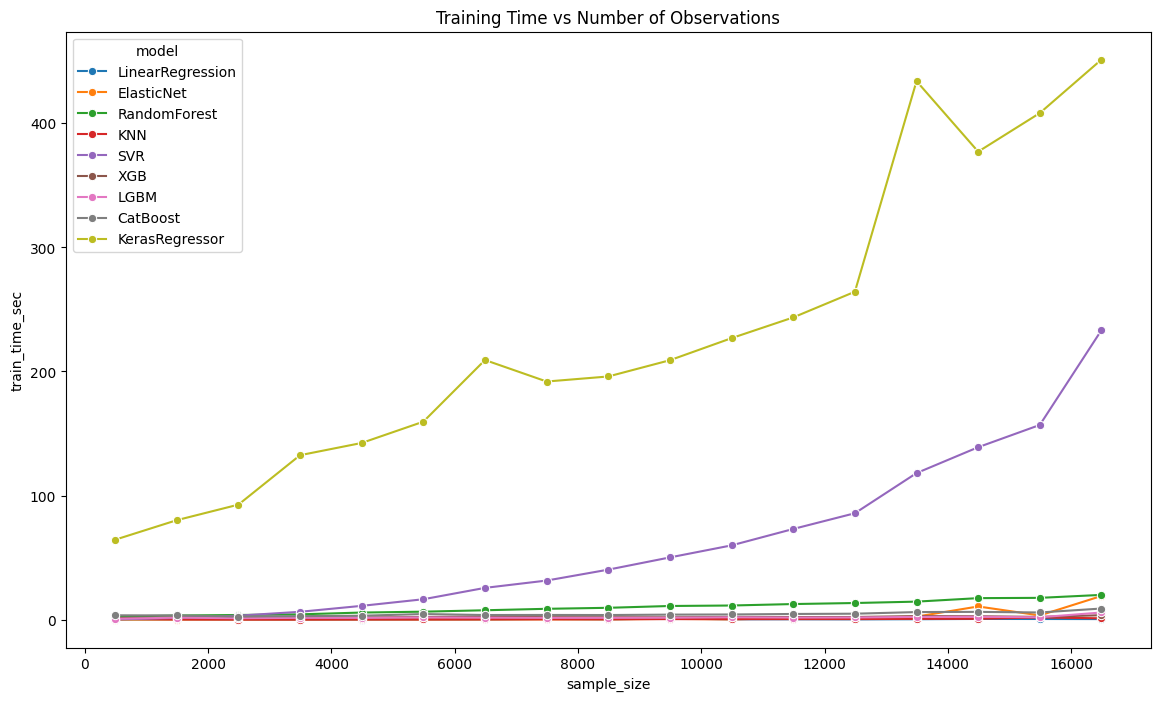

In [157]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=results_df, x='sample_size', y='train_time_sec', hue='model', marker='o')
plt.title('Training Time vs Number of Observations')
plt.show()

This plot illustrates how training time (y-axis) scales with increasing sample sizes (x-axis) for various regression models. **SVR** shows a marked rise. In contrast, **LinearRegression**, **KNN** and **ElasticNet** remain near the bottom, indicating minimal training overhead even as the sample size increases—this is due to their relatively simple optimization procedures. **RandomForest** and the tree-based boosting models (**XGB**, **LGBM**, **CatBoost**) occupy a moderate range, scaling more efficiently than SVR but requiring more time than linear methods. Finally, the KerasRegressor (an MLP) shows a moderate upward trend, reflecting the iterative nature of neural network training.

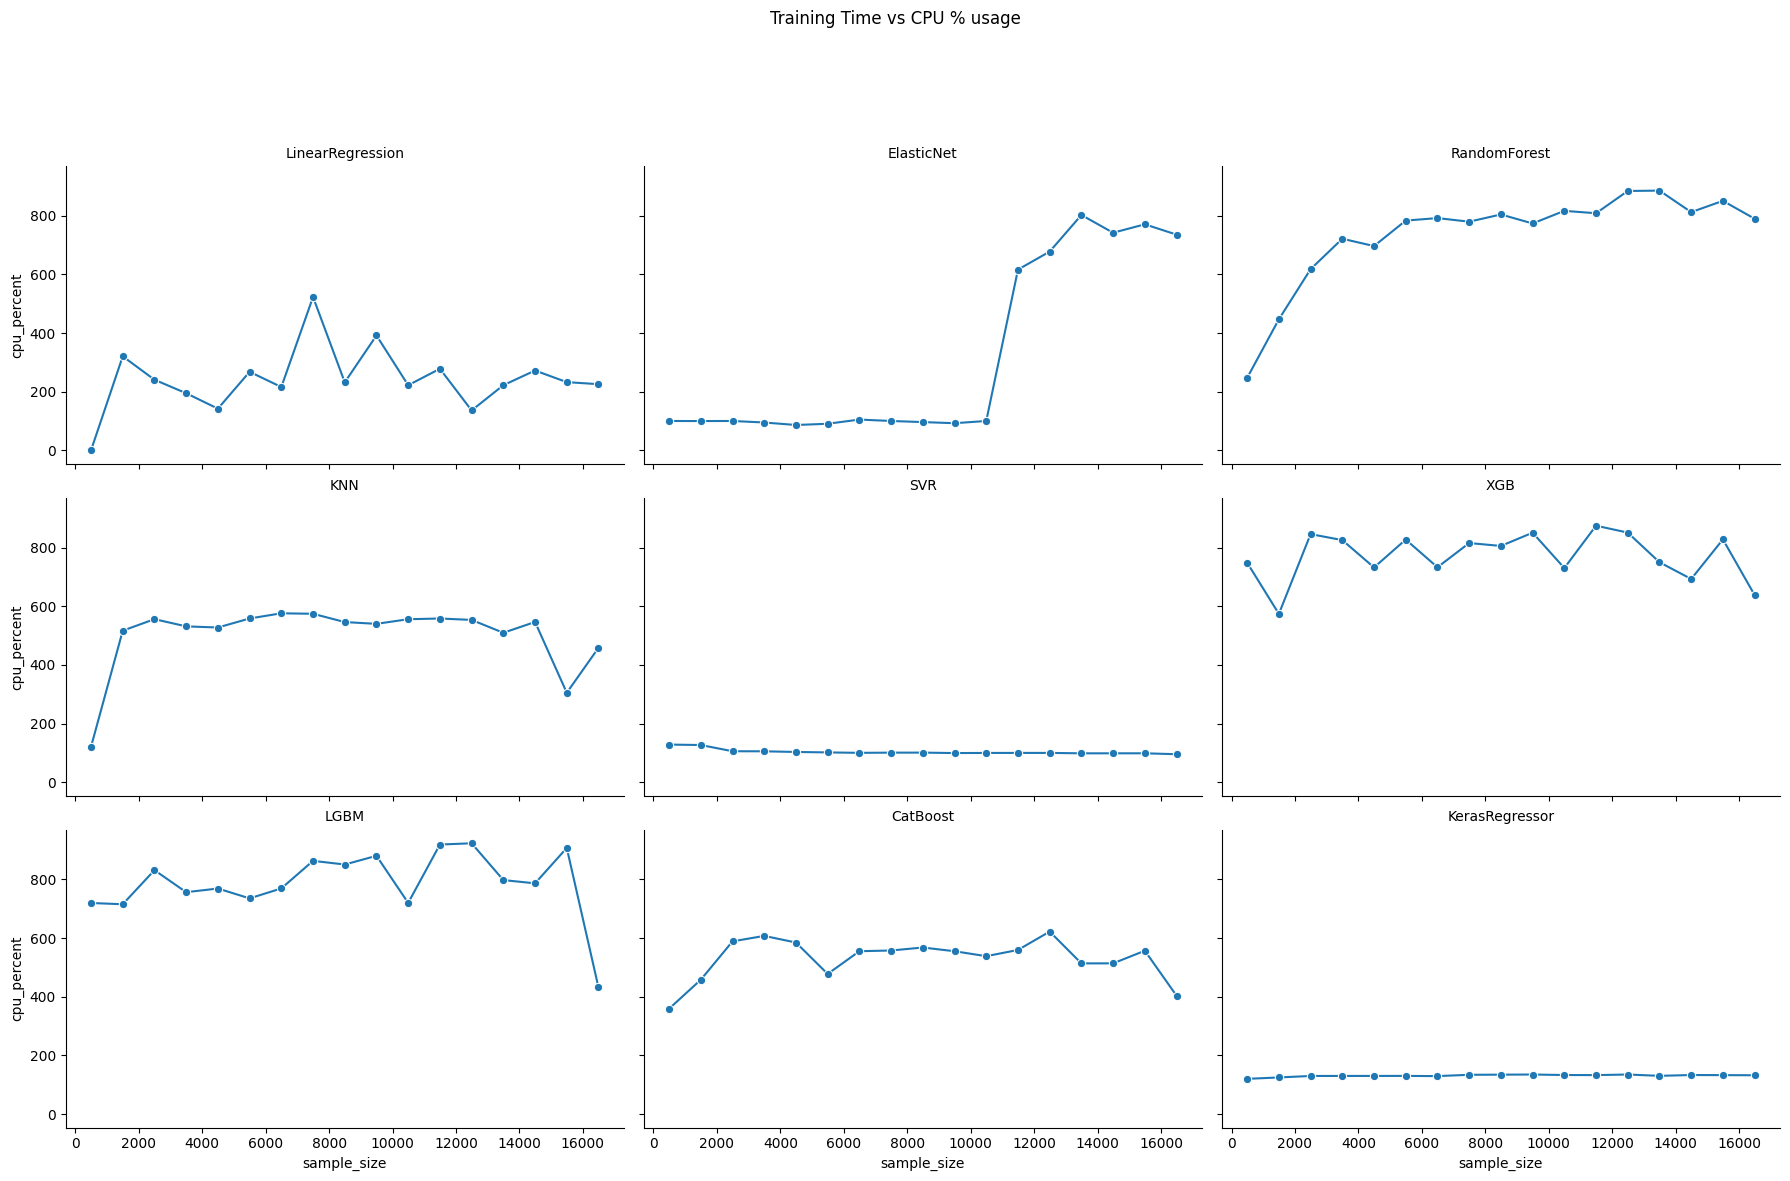

In [158]:
# Create a facet grid with one plot per model and wrap every 3 plots
g = sns.FacetGrid(results_df, col="model", col_wrap=3, height=4, aspect=1.5)
g.map(sns.lineplot, "sample_size", "cpu_percent", marker="o")

# Set the title for each subplot and add a main title
g.set_titles("{col_name}")
plt.subplots_adjust(top=0.85)
g.fig.suptitle('Training Time vs CPU % usage')
plt.show()

The provided visualization consists of a **FacetGrid** displaying multiple line plots, each representing a different machine learning model. The x-axis denotes the **sample size**, while the y-axis represents **CPU percentage usage** during training. The models compared include **LinearRegression, ElasticNet, RandomForest, KNN, SVR, XGB, LGBM, CatBoost, and KerasRegressor**.  

The **LinearRegression** model exhibits fluctuating CPU usage with increasing sample size, without a clear trend. **ElasticNet** shows a significant rise in CPU usage around a sample size of 10,000, followed by a plateau. **RandomForest** demonstrates an initial sharp increase in CPU usage before stabilizing at a high level. **KNN** maintains consistently high CPU usage with some fluctuations across different sample sizes. In contrast, **SVR** and **KerasRegressor** display consistently low CPU usage regardless of sample size. **XGB, LGBM, and CatBoost** exhibit a similar pattern of fluctuating but generally high CPU usage as the dataset grows.  

The figure's title, **"Training Time vs CPU % usage"**, emphasizes the focus on computational efficiency. This visualization provides a clear comparison of how different models utilize CPU resources, highlighting which algorithms demand more computational power as the sample size increases.

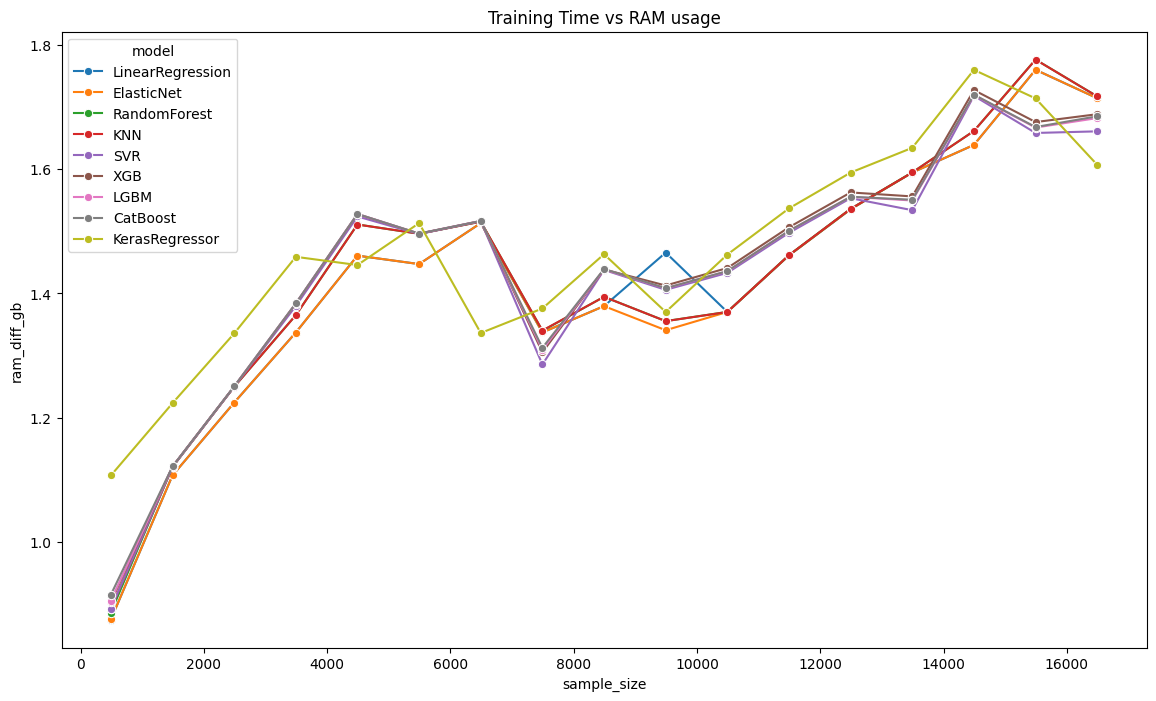

In [159]:
plt.figure(figsize=(14, 8))
sns.lineplot(data=results_df, x='sample_size', y='ram_diff_gb', hue='model', marker='o')
plt.title('Training Time vs RAM usage')
plt.show()

The visualization presents a **line plot** showing the relationship between **sample size** and **RAM usage (ram_diff_gb)** for various machine learning models. The x-axis represents the sample size, while the y-axis indicates the difference in RAM usage in gigabytes. Different models are color-coded and distinguished in the legend, including **LinearRegression, ElasticNet, RandomForest, KNN, SVR, XGB, LGBM, CatBoost, and KerasRegressor**.  

Across all models, RAM usage generally increases as the sample size grows, showing a clear upward trend. Initially, all models exhibit similar memory consumption, but as the sample size increases beyond 2,000, slight variations emerge. **KerasRegressor** shows a relatively steeper increase in RAM usage compared to the other models, particularly in the mid-range sample sizes. Despite some fluctuations, most models follow a similar pattern, with RAM consumption rising steadily as more data is processed.  

The key takeaway from this visualization is that **RAM usage scales with sample size across all models, with some minor variations in memory efficiency between them**. **KerasRegressor** appears to have the highest memory consumption, while other models follow a more consistent trajectory. This suggests that as datasets grow, models with higher RAM demands may require more computational resources, making memory efficiency a critical factor in model selection.

### Final models hyperparameters Optimization

These objective functions define how Optuna optimizes hyperparameters for **CatBoost**, **XGBoost**, and **LightGBM** by specifying a search space with `trial.suggest_*` calls, constructing a model using the suggested hyperparameters, and wrapping it in a preprocessing pipeline that encodes categorical features and scales numeric features. Each function performs 10-fold cross-validation using cross_val_score with the `neg_root_mean_squared_error` metric, negates the averaged negative RMSE to obtain the final RMSE, and returns this value for Optuna to minimize. By running separate studies for each model type, this approach systematically explores the hyperparameter space and identifies the combination that yields the lowest RMSE for **CatBoost**, **XGBoost**, and **LightGBM**, ensuring consistent data transformations and robust performance estimates.

In [160]:
def objective_catboost(trial: Trial):
    param = {
        "iterations": trial.suggest_int("catboost_iterations", 100, 1000),
        "depth": trial.suggest_int("catboost_depth", 3, 10),
        "learning_rate": trial.suggest_float("catboost_learning_rate", 1e-4, 1e-1, log=True),
        # Additional hyperparameters for CatBoost
        "l2_leaf_reg": trial.suggest_float("catboost_l2_leaf_reg", 1, 10),
        "random_strength": trial.suggest_float("catboost_random_strength", 0.0, 10.0),
        "bagging_temperature": trial.suggest_float("catboost_bagging_temperature", 0.0, 1.0),
        "border_count": trial.suggest_int("catboost_border_count", 32, 255),
        "random_seed": 42,
        "verbose": 0,
    }
    model = CatBoostRegressor(**param)
    pipe = Pipeline([
        ("preprocessor", create_preprocessor(numeric_features, categorical_features, use_ordinal_for_cats=True)),
        ("regressor", model)
    ])
    cv = KFold(n_splits=10, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    rmse = -scores.mean()
    return rmse

def objective_xgb(trial: Trial):
    param = {
        "n_estimators": trial.suggest_int("xgb_n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("xgb_max_depth", 3, 20),
        "learning_rate": trial.suggest_float("xgb_learning_rate", 1e-4, 1e-1, log=True),
        "subsample": trial.suggest_float("xgb_subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("xgb_colsample_bytree", 0.5, 1.0),
        # Additional hyperparameters for XGBoost
        "gamma": trial.suggest_float("xgb_gamma", 0, 5),
        "reg_alpha": trial.suggest_float("xgb_reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("xgb_reg_lambda", 1e-8, 10.0, log=True),
        "random_state": 42,
    }
    model = xgb.XGBRegressor(**param)
    pipe = Pipeline([
        ("preprocessor", create_preprocessor(numeric_features, categorical_features, use_ordinal_for_cats=True)),
        ("regressor", model)
    ])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    rmse = -scores.mean()
    return rmse

def objective_lgbm(trial: Trial):
    param = {
        "num_leaves": trial.suggest_int("lgbm_num_leaves", 10, 200),
        "max_depth": trial.suggest_int("lgbm_max_depth", -1, 15),
        "learning_rate": trial.suggest_float("lgbm_learning_rate", 1e-4, 1e-1, log=True),
        "n_estimators": trial.suggest_int("lgbm_n_estimators", 100, 1000),
        "min_child_samples": trial.suggest_int("lgbm_min_child_samples", 5, 100),
        "subsample": trial.suggest_float("lgbm_subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("lgbm_colsample_bytree", 0.5, 1.0),
        "random_state": 42,
        "reg_alpha": trial.suggest_float("lgbm_reg_alpha", 1e-8, 10.0, log=True),
        "reg_lambda": trial.suggest_float("lgbm_reg_lambda", 1e-8, 10.0, log=True),
        "min_split_gain": trial.suggest_float("lgbm_min_split_gain", 0.0, 5.0),
        "bagging_freq": trial.suggest_int("lgbm_bagging_freq", 1, 5),
    }
    model = LGBMRegressor(**param)
    pipe = Pipeline([
        ("preprocessor", create_preprocessor(numeric_features, categorical_features, use_ordinal_for_cats=True)),
        ("regressor", model)
    ])
    cv = KFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(pipe, X_train, y_train, scoring="neg_root_mean_squared_error", cv=cv, n_jobs=-1)
    rmse = -scores.mean()
    return rmse

# Run separate studies for each model 
studies = {}
objectives = {
    "LGBM": objective_lgbm, 
    "CatBoost": objective_catboost,
    "XGB": objective_xgb
}


This loop iterates over the dictionary of objective functions, where each key is a model name and each value is its corresponding objective function. For each model, it creates an Optuna study aimed at minimizing the **RMSE**, then runs 50 optimization trials (with a progress bar displayed) to explore the hyperparameter space. The resulting study, which captures the best achieved **RMSE** and corresponding hyperparameters, is stored in the studies dictionary, and the best results for each model are printed.

In [161]:
for model_name, obj_func in objectives.items():
    print(f"Optimizing {model_name}...")
    study = optuna.create_study(direction="minimize")
    study.optimize(obj_func, n_trials=50, timeout=None, show_progress_bar=True)
    studies[model_name] = study
    print(f"{model_name} - Best RMSE: {study.best_value}")
    print(f"{model_name} - Best hyperparameters: {study.best_params}\n")


Optimizing LGBM...


Best trial: 43. Best value: 123122: 100%|██████████| 50/50 [05:11<00:00,  6.23s/it]


LGBM - Best RMSE: 123122.49136694722
LGBM - Best hyperparameters: {'lgbm_num_leaves': 16, 'lgbm_max_depth': 13, 'lgbm_learning_rate': 0.030020478974720304, 'lgbm_n_estimators': 649, 'lgbm_min_child_samples': 9, 'lgbm_subsample': 0.7439306452864345, 'lgbm_colsample_bytree': 0.5033413512463512, 'lgbm_reg_alpha': 1.7280179257131245e-08, 'lgbm_reg_lambda': 6.308862328380626e-08, 'lgbm_min_split_gain': 2.3248927293463937, 'lgbm_bagging_freq': 1}

Optimizing CatBoost...


Best trial: 32. Best value: 122581: 100%|██████████| 50/50 [18:25<00:00, 22.11s/it]


CatBoost - Best RMSE: 122580.82956235376
CatBoost - Best hyperparameters: {'catboost_iterations': 975, 'catboost_depth': 6, 'catboost_learning_rate': 0.016738324293885942, 'catboost_l2_leaf_reg': 8.449160473710949, 'catboost_random_strength': 0.2518459323929537, 'catboost_bagging_temperature': 0.11898967123134188, 'catboost_border_count': 141}

Optimizing XGB...


Best trial: 28. Best value: 123131: 100%|██████████| 50/50 [12:43<00:00, 15.27s/it]

XGB - Best RMSE: 123131.31874060891
XGB - Best hyperparameters: {'xgb_n_estimators': 852, 'xgb_max_depth': 7, 'xgb_learning_rate': 0.005804323906589664, 'xgb_subsample': 0.8448221265519938, 'xgb_colsample_bytree': 0.5830638196776008, 'xgb_gamma': 0.0076697256253244195, 'xgb_reg_alpha': 1.7447605373603319, 'xgb_reg_lambda': 2.267329468442991e-06}



These results indicate that **CatBoost** achieved the lowest **RMSE** among the three optimized models, with **LightGBM** and **XGBoost** following closely at approximately. Overall, while the differences in **RMSE** are relatively small, CatBoost appears slightly more effective with this dataset under the given optimization setup.

### Final model evaluation

In [162]:
# Create a dictionary to store the final models built with the best hyperparameters
final_models = {}

# Rebuild each model with its best hyperparameters
for model_name, study in studies.items():
    best_params = study.best_params
    if model_name == "LGBM":
        model = LGBMRegressor(
            num_leaves=best_params["lgbm_num_leaves"],
            max_depth=best_params["lgbm_max_depth"],
            learning_rate=best_params["lgbm_learning_rate"],
            n_estimators=best_params["lgbm_n_estimators"],
            min_child_samples=best_params["lgbm_min_child_samples"],
            subsample=best_params["lgbm_subsample"],
            colsample_bytree=best_params["lgbm_colsample_bytree"],
            random_state=42,
            reg_alpha=best_params["lgbm_reg_alpha"],
            reg_lambda=best_params["lgbm_reg_lambda"],
            min_split_gain=best_params["lgbm_min_split_gain"],
            bagging_freq=best_params["lgbm_bagging_freq"],
        )
    elif model_name == "CatBoost":
        model = CatBoostRegressor(
            iterations=best_params["catboost_iterations"],
            depth=best_params["catboost_depth"],
            learning_rate=best_params["catboost_learning_rate"],
            l2_leaf_reg=best_params["catboost_l2_leaf_reg"],
            random_strength=best_params["catboost_random_strength"],
            bagging_temperature=best_params["catboost_bagging_temperature"],
            border_count=best_params["catboost_border_count"],
            random_seed=42,
            verbose=0
        )
    elif model_name == "XGB":
        model = xgb.XGBRegressor(
            n_estimators=best_params["xgb_n_estimators"],
            max_depth=best_params["xgb_max_depth"],
            learning_rate=best_params["xgb_learning_rate"],
            subsample=best_params["xgb_subsample"],
            colsample_bytree=best_params["xgb_colsample_bytree"],
            gamma=best_params["xgb_gamma"],
            reg_alpha=best_params["xgb_reg_alpha"],
            reg_lambda=best_params["xgb_reg_lambda"],
            random_state=42
        )
    final_models[model_name] = model

In [163]:
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}

kf = KFold(n_splits=10, shuffle=True, random_state=42)


for model_name, model in final_models.items():
    pipe = Pipeline([
        ("preprocessor", create_preprocessor(numeric_features, categorical_features, use_ordinal_for_cats=True)),
        (model_name.lower(), model)
    ])
    cv_results = cross_validate(pipe, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1)
    
    # Compute metrics (negated metrics are converted to positive values)
    rmse = -np.mean(cv_results["test_rmse"])
    mae = -np.mean(cv_results["test_mae"])
    r2 = np.mean(cv_results["test_r2"])
    
    print(f"Evaluation for {model_name}:")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R2:   {r2:.4f}\n")

Evaluation for LGBM:
  RMSE: 122802.0094
  MAE:  89069.1902
  R2:   0.7665

Evaluation for CatBoost:
  RMSE: 122580.8296
  MAE:  88877.8957
  R2:   0.7674

Evaluation for XGB:
  RMSE: 122859.3770
  MAE:  88909.4171
  R2:   0.7663



All models deliver similar performance — with **CatBoost** marginally outperforming in terms of **RMSE**, **MAE** and **R²**. 

In [164]:
# LGBM parameter importance
fig_lgbm = oviz.plot_param_importances(studies["LGBM"])
fig_lgbm.show()

# CatBoost parameter importance
fig_catboost = oviz.plot_param_importances(studies["CatBoost"])
fig_catboost.show()

# XGB parameter importance
fig_xgb = oviz.plot_param_importances(studies["XGB"])
fig_xgb.show()

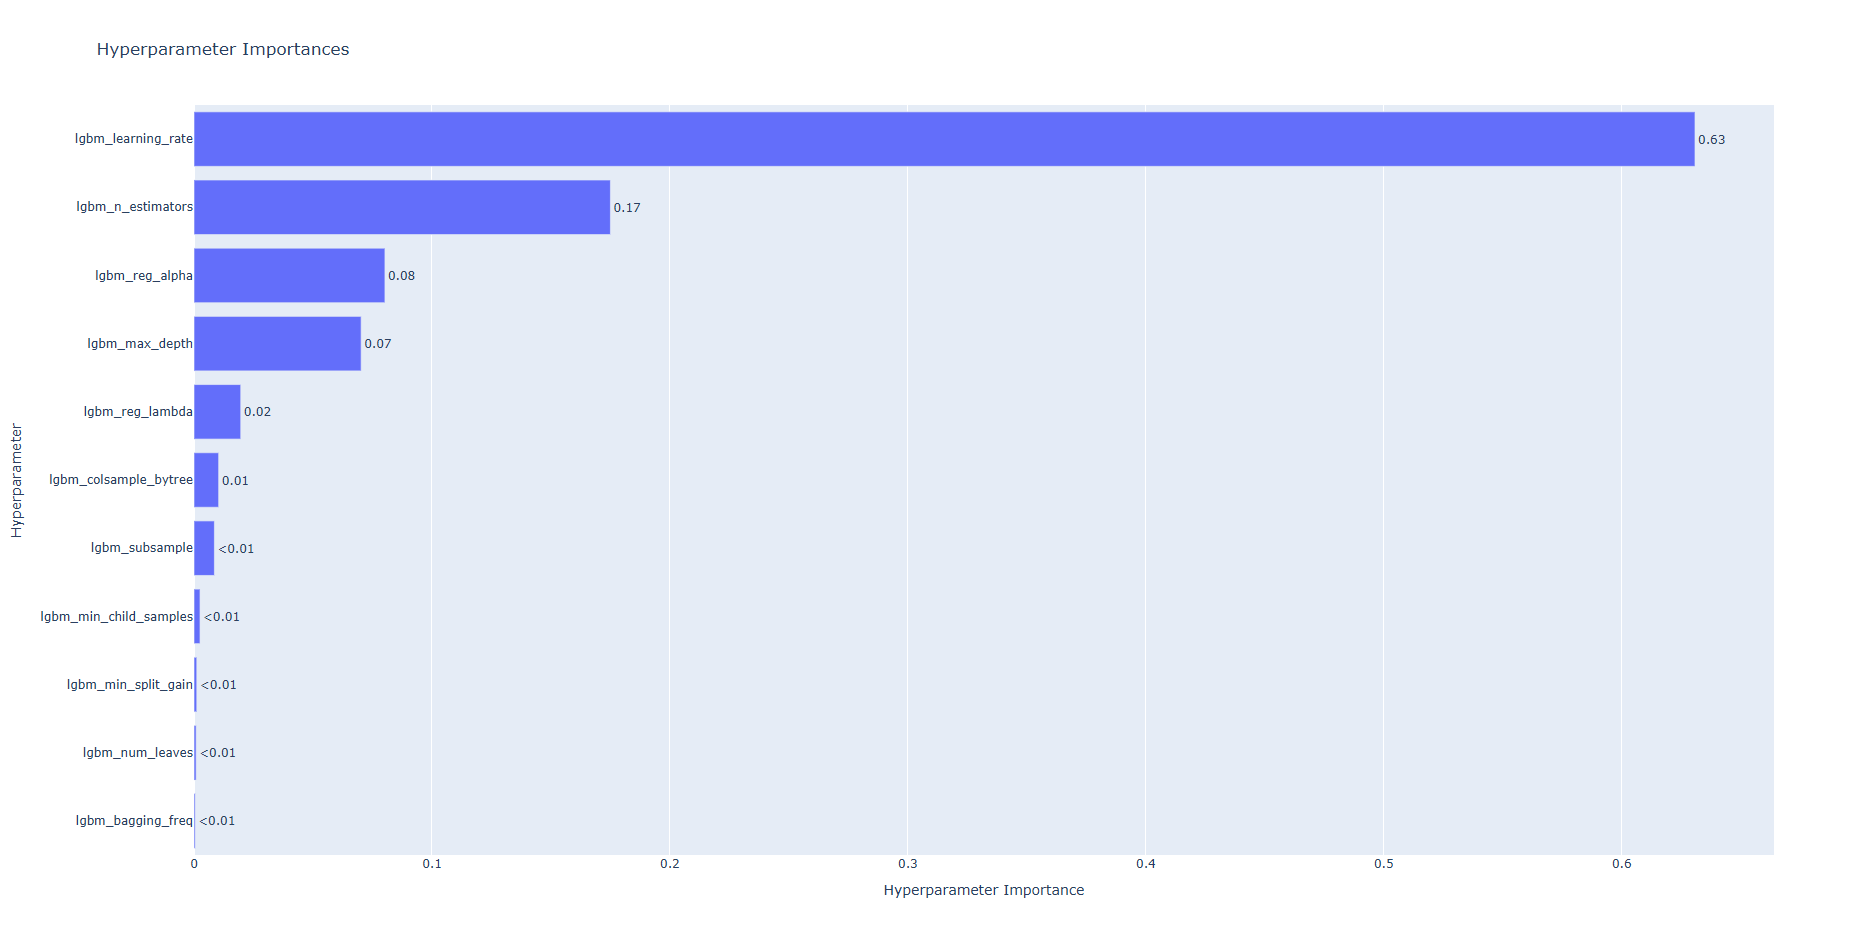
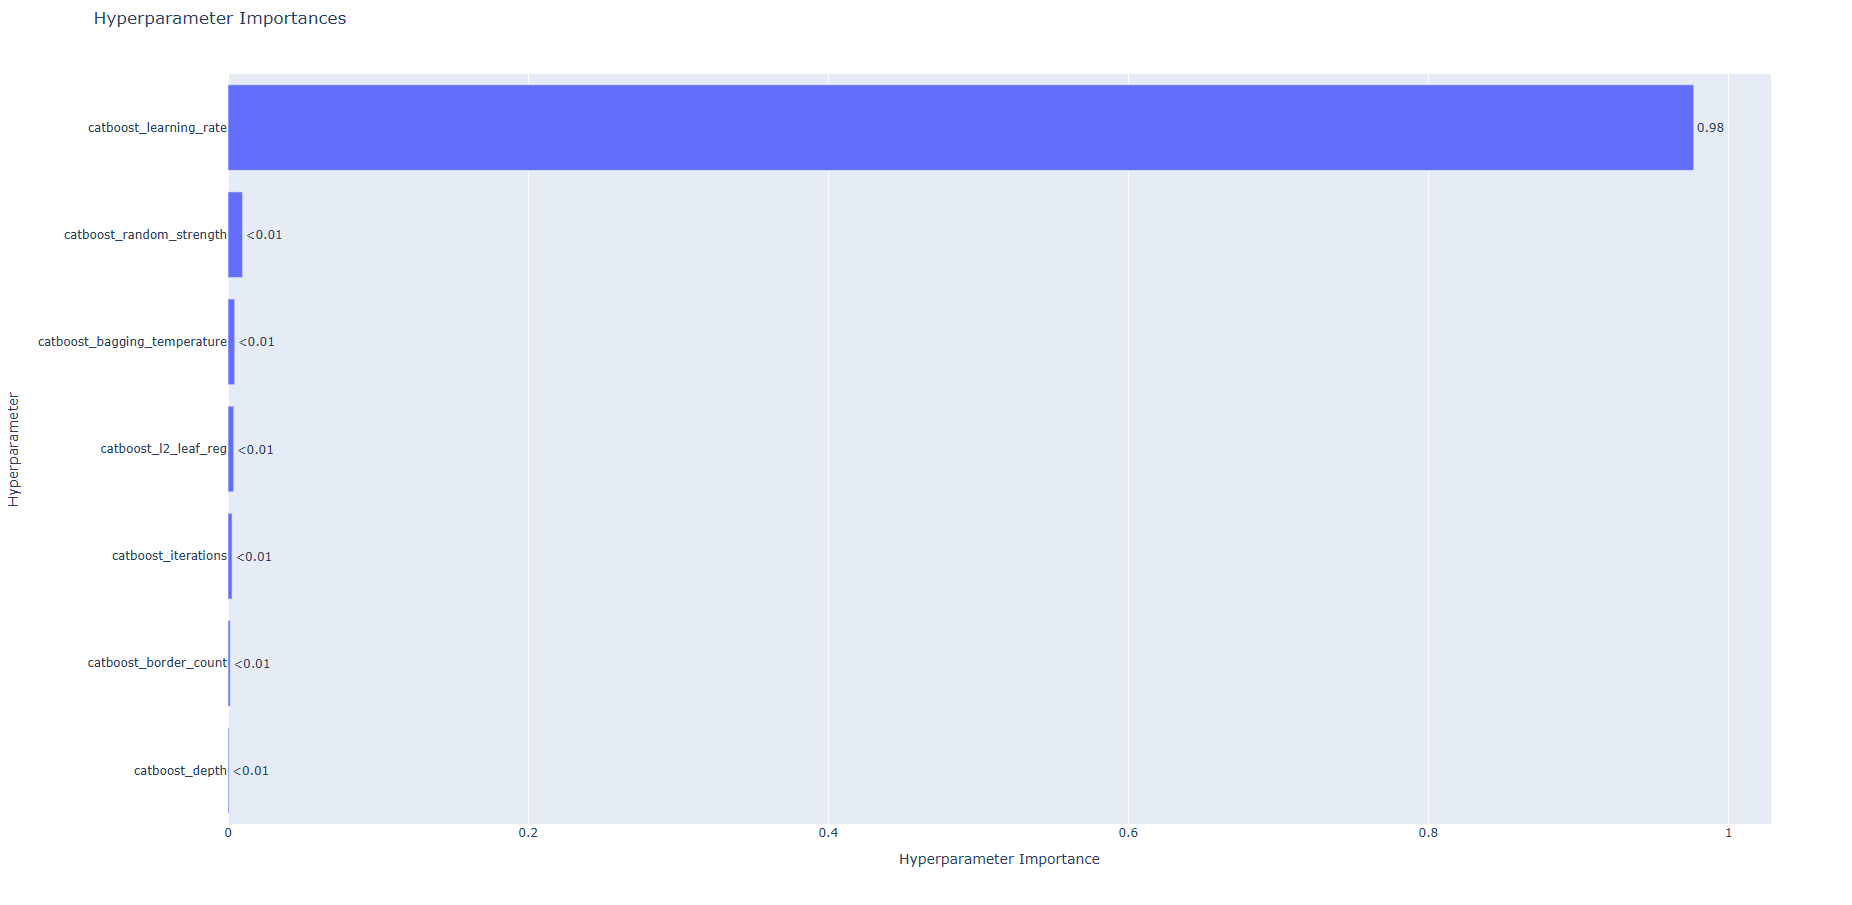
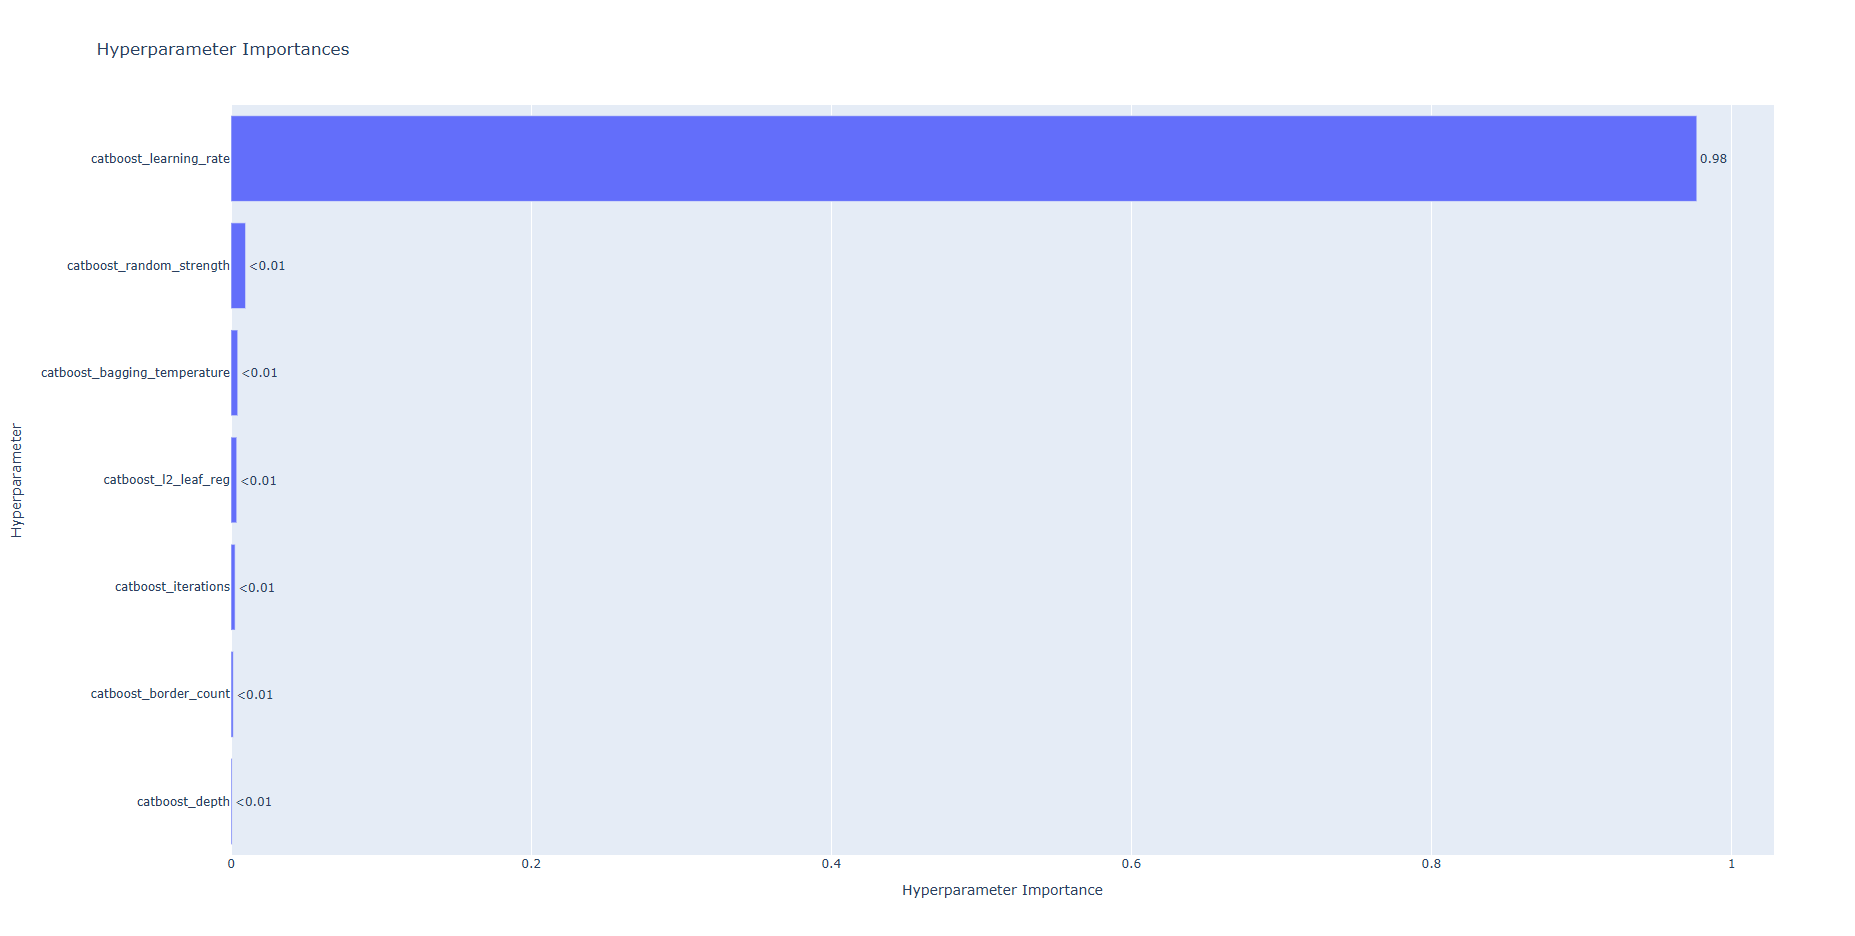

These three bar charts illustrate the relative importance of each hyperparameter in the final models for LightGBM, CatBoost, and XGBoost, as determined by the Optuna optimization process. In all three models, learning rate emerges as the most critical parameter—signifying how substantially it influences model performance and convergence. Here’s a brief breakdown for each chart:

* **LightGBM**: The learning rate overwhelmingly drives model performance, with max_depth and num_leaves next in importance. Subsample and min_split_gain help control overfitting, while regularization terms (reg_alpha, reg_lambda) have a lesser but still notable impact.


* **CatBoost**: Again, learning_rate stands out as the most influential parameter, followed by border_count (defining feature binning granularity) and l2_leaf_reg (regularization). Additional parameters like iterations, bagging_temperature, depth, and random_strength fine-tune the balance between bias and variance.


* **XGBoost**: The learning_rate dominates here too, with gamma—a parameter controlling split decisions—ranking second. Max_depth and subsample contribute to managing complexity and preventing overfitting, while colsample_bytree and regularization terms (reg_alpha, reg_lambda) round out the important factors.

This suggests that further improvements might be achieved by ensembling the best models. For instance, combining predictions through methods such as stacking, blending, or weighted averaging can harness the strengths of each model and potentially reduce both bias and variance.

In [165]:
# Build individual pipelines for each model and collect them in a list of estimators.
estimators = []
for model_name, model in final_models.items():
    pipe = Pipeline([
        ("preprocessor", create_preprocessor(numeric_features, categorical_features, use_ordinal_for_cats=True)),
        (model_name.lower(), model)
    ])
    estimators.append((model_name.lower(), pipe))

# Create the ensemble (voting regressor) from the pipelines.
ensemble = VotingRegressor(estimators=estimators)

# Evaluate the ensemble using 10-fold cross-validation.
scoring = {
    "rmse": "neg_root_mean_squared_error",
    "mae": "neg_mean_absolute_error",
    "r2": "r2"
}
kf = KFold(n_splits=10, shuffle=True, random_state=42)

cv_results = cross_validate(ensemble, X_train, y_train, scoring=scoring, cv=kf, n_jobs=-1)

# Compute metrics (note: negated metrics are converted to positive values)
rmse = -np.mean(cv_results["test_rmse"])
mae = -np.mean(cv_results["test_mae"])
r2 = np.mean(cv_results["test_r2"])

print("Ensemble evaluation from cv:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R2:   {r2:.4f}")

Ensemble evaluation from cv:
  RMSE: 122241.8517
  MAE:  88621.6190
  R2:   0.7687


By combining predictions from multiple optimized models, the ensemble achieves a slightly improved **MAE**, **RMSE** and **R²** compared to the best individual model, indicating that blending different learning algorithms can capture a broader range of patterns in the data.

In [166]:
ensemble.fit(X_train, y_train)

# Generate predictions on the test set
y_pred = ensemble.predict(X_test)

# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Ensemble evaluation on test set:")
print(f"  RMSE: {rmse:.4f}")
print(f"  MAE:  {mae:.4f}")
print(f"  R2:   {r2:.4f}")

Ensemble evaluation on test set:
  RMSE: 124816.7660
  MAE:  90750.4755
  R2:   0.7602


The ensemble evaluation on the test set shows better performance. This improvement over individual models indicates that combining predictions enhances accuracy, reduces errors, and better captures the underlying data patterns, leading to more robust and reliable performance on unseen data.

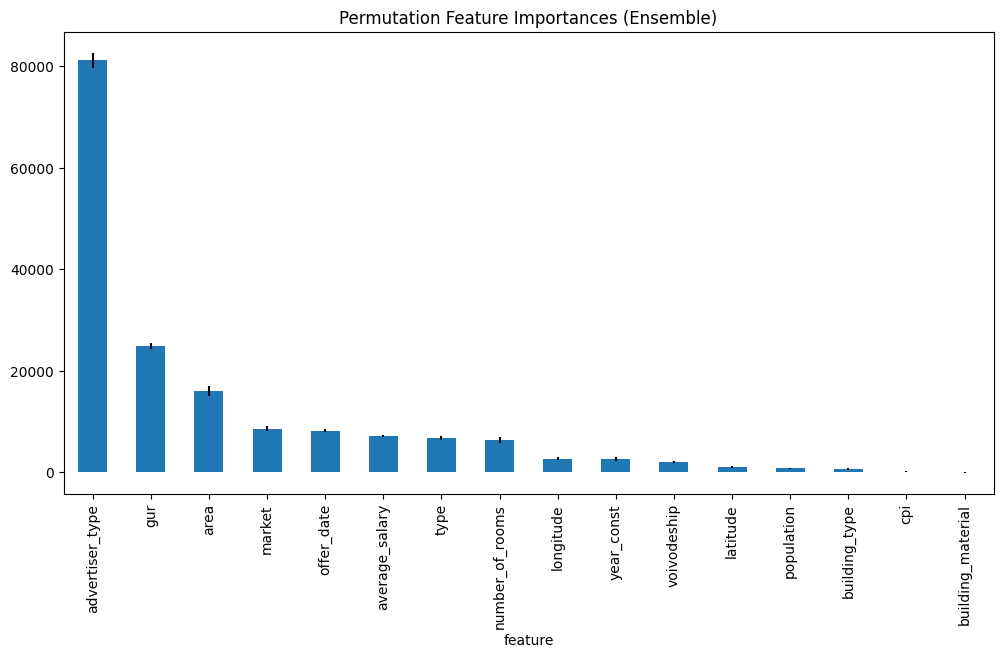

In [167]:
# Compute permutation importance on the ensemble using the test set
# We use the negative RMSE as the scoring metric (so a decrease means the feature is important)
perm_importance = permutation_importance(
    ensemble, X_test, y_test,
    scoring="neg_root_mean_squared_error",
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Extract the mean importance and standard deviation for each feature
importances = perm_importance.importances_mean
std = perm_importance.importances_std

# Get feature names (if available)
feature_names = X_test.columns if hasattr(X_test, "columns") else [f"f_{i}" for i in range(X_test.shape[1])]

# Create a DataFrame for feature importances and sort by importance
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances,
    "std": std
}).sort_values("importance", ascending=False)

# Plot the top 20 features
fig, ax = plt.subplots(figsize=(12, 6))
feat_imp_df.set_index("feature").head(20)["importance"].plot.bar(ax=ax, yerr=feat_imp_df.set_index("feature").head(20)["std"])
ax.set_title("Permutation Feature Importances (Ensemble)")
plt.show()

This permutation-based feature importance chart for the ensemble model shows that advertiser_type has the highest impact on predictions, followed by gur, area, market, and average_salary—indicating that these variables play key roles in explaining variations in the target. Features such as building_material and heating contribute minimally, suggesting that either they do not significantly affect the outcome or that other variables overshadow their influence. Overall, the model heavily relies on the type of advertiser, property attributes (like area), and market indicators to make its predictions, while certain property characteristics appear less critical in this dataset.

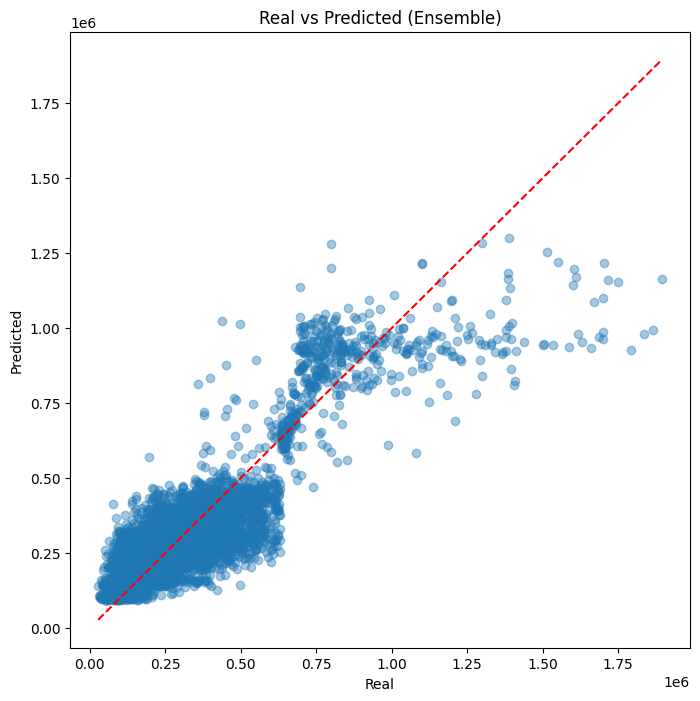

In [168]:
# --- Scatter Plot: Real vs Predicted (Ensemble) ---
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], "r--")
plt.xlabel("Real")
plt.ylabel("Predicted")
plt.title("Real vs Predicted (Ensemble)")
plt.show()

This scatter plot compares the true target values with the ensemble model’s predictions, with the red dashed line representing an ideal one-to-one correspondence. At lower property values, the predictions cluster tightly around the line, suggesting the ensemble handles typical or more common listings well. As real prices increase, however, the spread widens, indicating that the model’s predictions for high-value properties can deviate more substantially from the true values. This pattern often arises when there are fewer high-priced examples in the training data or when certain features fail to capture the nuances that drive exceptionally high property values.

# 4. Final conclusion

## Data Scraping

The first and basic step of our work was to collect data, we chose otodom.pl as our data source, and in this part we developed a script that downloaded data in three different categories ‘house’, ‘flat’ and ‘studio’.

## Coordinates Adding

In this step, we have developed a programme that allows us to add longitude and latitude columns based on the addresses obtained in the web scraping section.


### Data Preparation and Synthetic data Inclusion

In this section we took care of the preparation of our data, namely merging the retrieved offers from the three different types into one table, adding a type column, adding data retrieved from official sources such as `CPI`, `gur`, `average_salary` and `population`, we added it on the basis of an artificially created variable `offer_date`, which takes into account all the above-mentioned trends for `price`. We then filled in all numerical missing data using KNN and all categorical missing data using Decision Tree. The final step of data preparation, was the generation of synthetic data, including all trends, to make the data more realistic (more information about this you can find in **Generating synthetic data** subsection).

## Data Exploration 

This section was used to analyze the data obtained during the data preparation phase, where our primary focus was to verify the significance of the variables selected for prediction and to identify potential outliers. By employing various dependency graphs, such as scatter plots, correlation matrices, and box plots, we were able to visually assess relationships between variables, gauge the strength of these associations, and pinpoint anomalies or extreme values. This analysis helped us detect variables that were not significant to our study either because they did not contribute meaningfully to the predictive model or because their influence was confounded by other factors and to identify those variables that exhibited outliers. Consequently, this rigorous exploratory analysis enabled us to refine our feature set, ensuring that only the most informative and reliable predictors were incorporated into the final model.

## Model Comparing

In the **Model Design, Training, and Selection** chapter, we compared several models and evaluated their performance using both predictive and computational metrics. Specifically, we examined models including **LinearRegression**, **ElasticNet**, **RandomForest**, **XGBoost**, **LightGBM**, **CatBoost**, **KNN**, **SVR**, and a deep learning **KerasRegressor (MLP)**. The evaluation focused on metrics such as **RMSE**, **MAE**, and **R²**, as well as training time, CPU usage, and RAM consumption. The key findings were:

* Best-Performing Models:
    **LightGBM**, **XGBoost**, and **CatBoost** demonstrated robust performance with high predictive accuracy, largely due to their flexibility in handling outliers and complex data—an essential quality for real estate datasets.

* Models Not Selected:
    **KNN** and the **KerasRegressor (MLP)** were rejected because **KNN** is overly sensitive to outliers (which are prevalent in our data) and the deep learning model required extensive training while offering limited interpretability. Similarly, the simplicity of **linear models** and the inefficiency of **SVR** (in terms of both computation time and interpretability) resulted in suboptimal performance.

* Model Tuning and Ensemble:
    After selecting the top three models, they were further tuned to optimize their hyperparameters. These refined models were then combined into an ensemble, leveraging their complementary strengths to deliver more robust and reliable predictions. This ensemble achieved an **RMSE** of 124,816.77, an **MAE** of 90,750.48, and an **R²** of 0.7602 on the test set.

So our final model is an ensemble of the finely tuned LightGBM, XGBoost, and CatBoost models.

## Proof of Concept

The conclusions indicate that our proof of concept successfully demonstrates the potential to predict real estate prices using an ensemble approach. By combining the strengths of LightGBM, XGBoost, and CatBoost, the model achieved robust performance on the test set. Results confirms that the ensemble can effectively handle complex data with outliers, and that our rigorous data cleaning, imputation, and hyperparameter tuning process plays a crucial role in achieving accurate predictions.

## Faced Issues 

One of the major challenges we encountered was the need for a constant and stable internet connection during the web scraping process. This requirement meant that any interruptions in connectivity could result in incomplete or inconsistent data, undermining the quality of our dataset. Additionally, the data available in the public domain was often insufficient, with many key variables missing or not fully documented. This issue was further exacerbated by the fact that not all fields on the real estate sales websites were consistently filled out, leading to significant gaps in the collected information. Moreover, the limited time available for data collection constrained our ability to incorporate additional factors that are crucial for accurately determining real estate prices. These issues highlight the complexities inherent in gathering comprehensive real estate data and emphasize the need for improved data acquisition strategies and more robust, diverse data sources.

## GenAI Usage 

Generative AI was not used as the primary driving force in this work. All concepts and the overall structure of the code were developed by the team members based on their knowledge and experience.

However, AI was leveraged to streamline routine tasks, such as optimizing code, generating code comments, and accelerating the search for relevant information sources. Additionally, it assisted in refining documentation, improving readability, and ensuring consistency in formatting, ultimately enhancing workflow efficiency without replacing human expertise in decision-making and conceptual development.

Since Generative AI assisted in code development, team members discovered new ways to implement familiar methods.
By optimizing code, improving documentation, and streamlining routine tasks, AI helped uncover more efficient and scalable solutions. While it did not replace human expertise, it enhanced the team's understanding of best practices and fostered innovation in their approach.